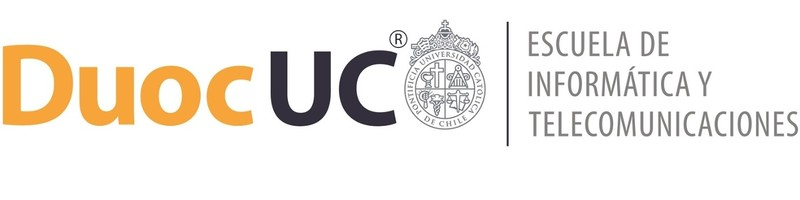

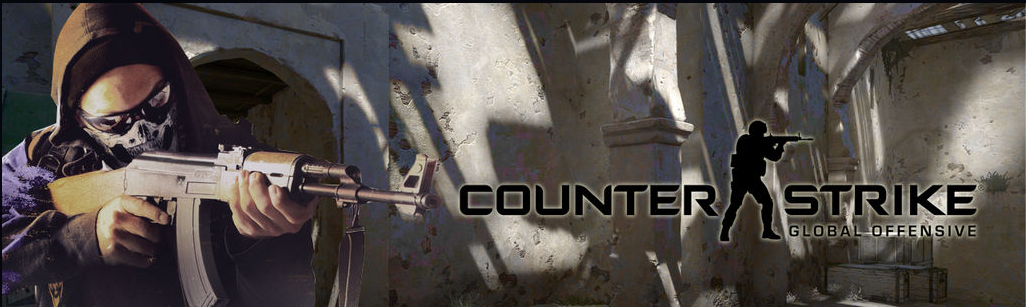

# Informe Técnico - Examen Transversal: Caso Counter Strike


Integrantes:
* Sofia Figueroa
* Elias Guala

Docente: Italo Andres Bonet Garrido     

Sección: MLY0100 - 003D

# Caso Fundamentos de Machine Learning

CONTEXTO CASO

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

### Libreria

In [106]:
#Importar las librerias necesarias para comprender y preparar los datos
import pandas as pd
import numpy as np
import seaborn as sb
from seaborn import boxplot
from seaborn import load_dataset
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_curve, precision_recall_curve, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from sklearn import linear_model



In [107]:
import pandas as pd

# Ruta relativa (si el archivo está en la misma carpeta que tu script)
df = pd.read_csv('Anexo ET_demo_round_traces_2022.csv', sep=';')

# O con ruta absoluta (ejemplo)
# df = pd.read_csv('C:/Users/tu_usuario/Documents/proyecto/datos.csv', sep=';')

C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\423176354.py:4: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Anexo ET_demo_round_traces_2022.csv', sep=';')


## Fase 1: Business Understanding

###**Datos relevantes**

Los datos más relevantes del conjunto incluyen el ID de partida y ronda, el equipo y mapa, si el jugador ganó o sobrevivió, kills, headshots, asistencias, tiempo vivo, distancia recorrida, tipo de arma usada, uso de granadas y el valor del equipamiento individual y del equipo. Estos permiten analizar el rendimiento del jugador y predecir resultados.


###**Hipótesis y tesis consideradas**

- Jugadores con mayor valor de equipamento al iniciar la ronda tienden a sobrevivir más tiempo.
- El tipo de arma tiene un impacto directo en el tiempo de supervivencia

En CS:GO, tener mejor equipamiento al comenzar una ronda y sobrevivir más tiempo aumentan las posibilidades de que un equipo gane, ya que estos factores dan ventaja en combate y en estrategia.

###**KPI'S RELEVANTES**

- Tiempo de Vida : TimeAlive (**objetivo**)
- Ratio de Equipamento : RoundStartingEquipmentValue / TeamStartingEquipmentValue (Aportará el contexto táctico)
- Rendimiento Ofensivo : Kills + Assists (Métrica bruta de impacto en combate)
- Precisión de ejecucuión :  Headshots / Kills (Indicarpa la calidad de las bajas realizadas)
- Movilidad táctica :  TravellDistance (Correlación con superviciencia)

###**PROBLEMA DE NEGOCIO (PREDICCION)**
Tipo de prediccion: Regresión
- Predecir el tiempo de supervivencia (TimeAlive) de un jugador en una ronda, usando variables como equipamiento, movilidad y desempeño
-Los jugadores que generan mayor impacto ofensivo durante la ronda —medido por la suma de Kills y Assists— y que permanecen vivos más tiempo (TimeAlive), tienen una mayor probabilidad de estar en el equipo ganador (MatchWinner).

## Fase 2: Data Understanding

###**Identificar tipos de variables/atributos**

In [108]:
df = df.drop(['Unnamed: 0'],axis=1)

Borramos el índice porque, aunque suele ser útil, en este caso puede afectar el rendimiento cuando se hacen muchas inserciones, actualizaciones o eliminaciones.

In [109]:
# Información de columnas y tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Map                          79157 non-null  object 
 1   Team                         79155 non-null  object 
 2   InternalTeamId               79157 non-null  int64  
 3   MatchId                      79157 non-null  int64  
 4   RoundId                      79157 non-null  int64  
 5   RoundWinner                  79157 non-null  object 
 6   MatchWinner                  79156 non-null  object 
 7   Survived                     79157 non-null  bool   
 8   AbnormalMatch                79157 non-null  bool   
 9   TimeAlive                    79157 non-null  object 
 10  TravelledDistance            79157 non-null  object 
 11  RLethalGrenadesThrown        79157 non-null  int64  
 12  RNonLethalGrenadesThrown     79157 non-null  int64  
 13  PrimaryAssaultRi

**Variables numéricas**
- **Variables int:**
InternalTeamId, MatchId, RoundId, RLethalGrenadesThrown, RNonLethalGrenadesThrown, PrimaryPistol, RoundKills, RoundAssists, RoundHeadshots, RoundFlankKills, RoundStartingEquipmentValue, TeamStartingEquipmentValue, MatchKills, MatchFlankKills, MatchAssists y MatchHeadshots

- **Variables float:**
PrimaryAssaultRifle, PrimarySniperRifle, PrimaryHeavy y PrimarySMG

**Variables categóricas**
- **Variables string:**
Map, Team, RoundWinner, MatchWinner, TimeAlive, TravelledDistance y FirstKillTime

- **Variables boolean:**
Survived y AbnormalMatch

In [110]:
pd.set_option('display.max_columns', None)
df.head(5)

Map       Team  InternalTeamId  MatchId  RoundId RoundWinner  \
0  de_inferno  Terrorist               1        4        1       False   
1  de_inferno  Terrorist               1        4        1       False   
2  de_inferno  Terrorist               1        4        1       False   
3  de_inferno  Terrorist               1        4        1       False   
4  de_inferno  Terrorist               1        4        1       False   

  MatchWinner  Survived  AbnormalMatch               TimeAlive  \
0        True     False          False  51.120.248.995.704.500   
1        True     False          False   4.348.662.552.266.170   
2        True     False          False   3.735.469.847.054.540   
3        True     False          False   4.767.886.136.441.470   
4        True      True          False   5.312.251.089.027.310   

        TravelledDistance  RLethalGrenadesThrown  RNonLethalGrenadesThrown  \
0  10.083.140.737.457.000                      0                         4   
1  60.960.883.184.688.400                      0                         0   
2   5.642.252.383.582.750                      0                         0   
3   8.963.473.313.229.970                      0                         0   
4  10.865.649.734.393.100                      1                         1   

   PrimaryAssaultRifle  PrimarySniperRifle  PrimaryHeavy  PrimarySMG  \
0                  0.0                 0.0           0.0         0.0   
1                  0.0                 0.0           0.0         0.0   
2                  0.0                 0.0           0.0         0.0   
3                  0.0                 0.0           0.0         0.0   
4                  0.0                 0.0           0.0         0.0   

   PrimaryPistol FirstKillTime  RoundKills  RoundAssists  RoundHeadshots  \
0              1           0.0           0             0               0   
1              1           0.0           0             0               0   
2              1           0.0           0             0               0   
3              1           0.0           0             0               0   
4              1           0.0           0             0               0   

   RoundFlankKills  RoundStartingEquipmentValue  TeamStartingEquipmentValue  \
0                0                          750                        4400   
1                0                          800                        4400   
2                0                         1000                        4400   
3                0                          850                        4400   
4                0                         1000                        4400   

   MatchKills  MatchFlankKills  MatchAssists  MatchHeadshots  
0           0                0             0               0  
1           0                0             0               0  
2           0                0             0               0  
3           0                0             0               0  
4           0                0             0               0

Podemos verque que la base de dato no muestra los datos de manera correcta, debido que 3 variables que definimos como categoricas son en verdad numerica y otro errores que se mostrar a continuación:

- **TimeAlive:** Tiene formato incorrecto (string con puntos), debería ser un número en segundos.

- **TravelledDistance:** Mismo problema de formato que TimeAlive, no es numérico real.

- **FirstKillTime:** String con formato inconsistente; debería ser numérico si representa segundos.

- **Map:** Variable categórica útil, pero está como texto; necesita codificación.

- **Team, RoundWinner, MatchWinner:** Categóricas en texto, deben codificarse.

- **Survived, AbnormalMatch:** Booleans correctos, útiles para análisis.


In [111]:
# Filtrar solo las columnas categóricas
categoricas = df.select_dtypes(include=['object', 'bool'])

# Mostrar los valores únicos de cada columna categórica
for col in categoricas.columns:
    print(f"Valores únicos de la columna '{col}':")
    print(df[col].unique())
    print("="*50)

Valores únicos de la columna 'Map':
['de_inferno' 'de_nuke' 'de_mirage' 'de_dust2']
Valores únicos de la columna 'Team':
['Terrorist' 'CounterTerrorist' nan]
Valores únicos de la columna 'RoundWinner':
['False' 'True' 'False4' True False]
Valores únicos de la columna 'MatchWinner':
[True False nan]
Valores únicos de la columna 'Survived':
[False  True]
Valores únicos de la columna 'AbnormalMatch':
[False]
Valores únicos de la columna 'TimeAlive':
['51.120.248.995.704.500' '4.348.662.552.266.170' '3.735.469.847.054.540'
 ... '5.914.717.797.783.930' '42.582.842.797.783.900'
 '8.004.793.109.418.280']
Valores únicos de la columna 'TravelledDistance':
['10.083.140.737.457.000' '60.960.883.184.688.400' '5.642.252.383.582.750'
 ... '6.005.168.938.274.500' '27.987.628.542.398.100'
 '9.867.724.708.696.010']
Valores únicos de la columna 'FirstKillTime':
['0.0' '373.547' '5.112.025' ... '59.147.180.000.000.000' '28.714.119'
 '438.720.474']


Podemos identificar que:
- **AbnormalMatch** tiene un unico valor, puede ser eliminado a futuro
- **RoundWinner** tiene valores duplicados y en string "True", "False", "False4". Para esto serán reemplazados por booleans antes de la codificación


###**Identificar Nulos**

In [112]:
#Verificar nulos
nulos = df.isnull().sum()
nulos = nulos[nulos > 0]
print(nulos)

Team           2
MatchWinner    1
dtype: int64


Observamos que hay 3 datos faltantes en las variables Team y MatchWinner. Podemos eliminar esos registros sin que afecte el análisis, ya que la cantidad es muy pequeña y no impactará en los resultados finales

###**Identificar Outliers**

KeyboardInterrupt: 

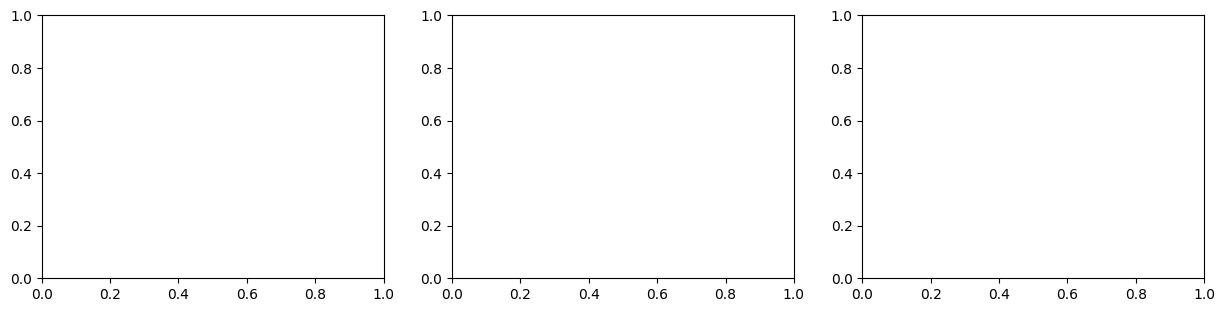

In [113]:
numeric_cols = df.select_dtypes(include='number').columns
outlier_counts = {}

# Identificar outliers con IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    outlier_counts[col] = outliers.shape[0]  # Número de outliers

# Parámetros del layout
n_cols = 3  # número de columnas en la cuadrícula
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Generar boxplots
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col].dropna(), ax=axes[i])
    axes[i].set_title(f'Diagrama de Caja - {col}')
    axes[i].set_ylabel(col)

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Mostrar el DataFrame de conteo de outliers ordenado
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Cantidad de Outliers'])
outlier_df = outlier_df.sort_values(by='Cantidad de Outliers', ascending=False)
display(outlier_df)

El grafico revela que hay un número significativo de valores atípicos en varias columnas que miden rendimiento o acciones dentro del juego, especialmente en: Kills (asesinatos), headshots (disparos a la cabeza) y armas primarias usadas.
Esto sugiere que el comportamiento de los jugadores puede variar mucho, posiblemente por diferencias de habilidad entre jugadores y/o diferencia de tácticas, junto con la posibilidad de diferencia en armamentos utilizados.
Variables que serán tratadas a futuro:
- RoundHeadshots

- RoundAssists

- RoundKills

- RoundFlankKills

- RLethalGrenadesThrown

###**Tranformaciones**

Primero trataremos la variable "RoundWinner" por sus valores unicos repetidos:

In [ ]:
df_modificado = df.copy()
# Reemplazar 'False4' por 'False' y convertir todos los valores a booleanos (True/False)
df_modificado['RoundWinner'] = df_modificado['RoundWinner'].replace({'False4': 'False', 'True': 'True', 'False': 'False'})
df_modificado['RoundWinner'] = df_modificado['RoundWinner'].astype(bool)

# Verificar los cambios
print(df_modificado['RoundWinner'].unique())

[ True False]


Avanzaremos con la eliminacion de la variable AbnormalMatch:

In [ ]:
df_modificado = df_modificado.drop(columns=['AbnormalMatch'])

Eliminamos abnormalMatch ya que solo entregaba datos Falsos que no son útiles para nuestra investigación

####**Tratamiento de Nulos**

Borraremos los nulos de las variables Team y MatchWinner

In [ ]:
df_cleaned = df_modificado.dropna(subset=['Team', 'MatchWinner'])

# Ver cuántos valores nulos hay después
print("\nDespués de limpiar:")
print(df_cleaned[['Team', 'MatchWinner']].isnull().sum())

# Verificar la cantidad de filas eliminadas
print(f"\nFilas eliminadas: {len(df) - len(df_cleaned)}")


Después de limpiar:
Team           0
MatchWinner    0
dtype: int64

Filas eliminadas: 3


Como se muestra en el gráfico anterior, decidimos eliminar los valores nulos para mejorar la precisión del análisis. Si no los eliminamos, los resultados posteriores podrían verse afectados y dar conclusiones incorrectas.

####**A numericos**

In [ ]:
df_var_num = df_cleaned.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Filtramos columnas de tipo 'object'
columnas_object = df_var_num.select_dtypes(include='object').columns

#Diccionario para guardar encoders
label_encoders = {}

#Codificamos cada columna categórica
for col in columnas_object:
    le = LabelEncoder()
    df_var_num[col] = le.fit_transform(df_var_num[col].astype(str))  # Convertimos todo a string por si hay mezclas raras
    label_encoders[col] = le

columnas_bool = df_var_num.select_dtypes(include='bool').columns

#Convertimos cada columna booleana a entero
df_var_num[columnas_bool] = df_var_num[columnas_bool].astype(int)

#Validar que todo quedó numérico
print(df_var_num.dtypes)

Map                              int32
Team                             int32
InternalTeamId                   int64
MatchId                          int64
RoundId                          int64
RoundWinner                      int32
MatchWinner                      int32
Survived                         int32
TimeAlive                        int32
TravelledDistance                int32
RLethalGrenadesThrown            int64
RNonLethalGrenadesThrown         int64
PrimaryAssaultRifle            float64
PrimarySniperRifle             float64
PrimaryHeavy                   float64
PrimarySMG                     float64
PrimaryPistol                    int64
FirstKillTime                    int32
RoundKills                       int64
RoundAssists                     int64
RoundHeadshots                   int64
RoundFlankKills                  int64
RoundStartingEquipmentValue      int64
TeamStartingEquipmentValue       int64
MatchKills                       int64
MatchFlankKills          

In [ ]:
df_var_num['TimeAlive'] = df_var_num['TimeAlive'].astype(str).str.replace('.', '').astype(float)
df_var_num['TravelledDistance'] = df_var_num['TravelledDistance'].astype(str).str.replace('.', '').astype(float)
df_var_num['FirstKillTime'] = df_var_num['FirstKillTime'].astype(str).str.replace('.', '').astype(float)

In [ ]:
print("TimeAlive máximo:", df_var_num['TimeAlive'].max(), "Wilisegundos")
print("TravelledDistance máximo:", df_var_num['TravelledDistance'].max(), "Wilimetros")
print("FirstKillTime máximo:", df_var_num['FirstKillTime'].max(), "Wilisegundos")

TimeAlive máximo: 51625.0 Wilisegundos
TravelledDistance máximo: 77997.0 Wilimetros
FirstKillTime máximo: 33854.0 Wilisegundos


In [ ]:
df_var_num2 = df_var_num.copy()

In [ ]:
# Convertir TimeAlive de milisegundos a segundos
df_var_num2['TimeAlive'] = df_var_num2['TimeAlive'] / 1000

# Convertir TravelledDistance de milímetros a metros
df_var_num2['TravelledDistance'] = df_var_num2['TravelledDistance'] / 1000

# Convertir FirstKillTime de milisegundos a segundos
df_var_num2['FirstKillTime'] = df_var_num2['FirstKillTime'] / 1000

In [ ]:
# Imprimir los valores máximos en la nueva unidad
print("TimeAlive máximo:", df_var_num2['TimeAlive'].mean(), "Segundos")
print("TravelledDistance máximo:", df_var_num2['TravelledDistance'].mean(), "Metros")
print("FirstKillTime máximo:", df_var_num2['FirstKillTime'].mean(), "Segundos")

TimeAlive máximo: 25.913037660762566 Segundos
TravelledDistance máximo: 38.85841966293553 Metros
FirstKillTime máximo: 15.828022399373376 Segundos


####**Tratamiento de Outliers**

Vamos a tratar solo a las variables relevantes o importantes para nuestro objetivo de prediccion.

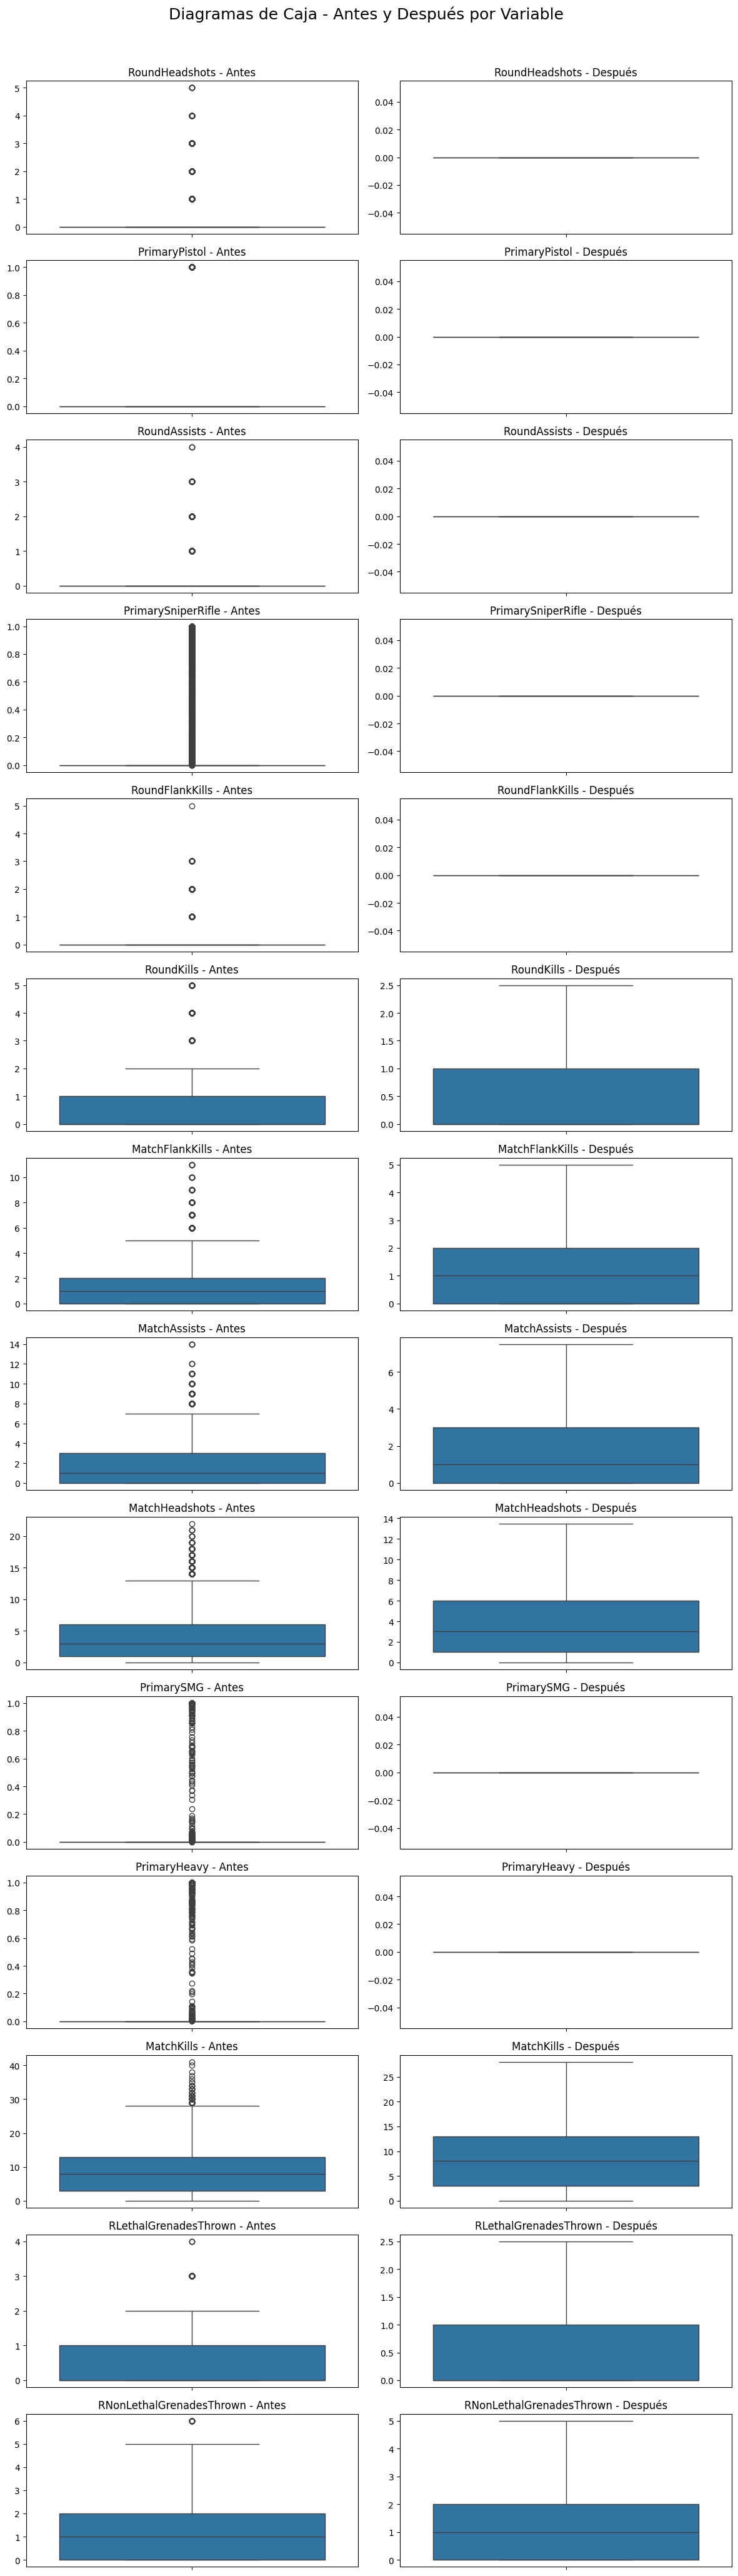


Tabla de outliers antes y después de la Winsorización:
                    Variable Outliers Antes  Outliers Después
0             RoundHeadshots          19582                 0
1              PrimaryPistol          17555                 0
2               RoundAssists          10692                 0
3         PrimarySniperRifle           9570                 0
4            RoundFlankKills           6962                 0
5                 RoundKills           3505                 0
6            MatchFlankKills           1184                 0
7               MatchAssists            781                 0
8             MatchHeadshots            724                 0
9                 PrimarySMG            655                 0
10              PrimaryHeavy            561                 0
11                MatchKills            162                 0
12     RLethalGrenadesThrown             98                 0
13  RNonLethalGrenadesThrown             15                 0


In [ ]:
# Lista de variables a tratar
vars_to_winsorize = [
    'RoundHeadshots', 'PrimaryPistol', 'RoundAssists', 'PrimarySniperRifle',
    'RoundFlankKills', 'RoundKills', 'MatchFlankKills', 'MatchAssists',
    'MatchHeadshots', 'PrimarySMG', 'PrimaryHeavy', 'MatchKills',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown'
]

# Copia del DataFrame original para no modificarlo directamente
df_before = df_var_num2[vars_to_winsorize].copy()
df_winsorized = df_var_num2[vars_to_winsorize].copy()

# Tabla para guardar número de outliers por variable
outliers_table = pd.DataFrame(columns=['Variable', 'Outliers Antes'])

# Winsorización por variable
for col in vars_to_winsorize:
    Q1 = df_winsorized[col].quantile(0.25)
    Q3 = df_winsorized[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Contar outliers antes de winsorizar
    outliers_count = ((df_winsorized[col] < lower_limit) | (df_winsorized[col] > upper_limit)).sum()

    # Agregar a la tabla usando pd.concat()
    outliers_table = pd.concat([
        outliers_table,
        pd.DataFrame({'Variable': [col], 'Outliers Antes': [outliers_count]})
    ], ignore_index=True)

    # Winsorizar
    df_winsorized[col] = np.where(df_winsorized[col] < lower_limit, lower_limit,
                                  np.where(df_winsorized[col] > upper_limit, upper_limit, df_winsorized[col]))

# Tabla comparativa para mostrar que está limpio (sin outliers)
outliers_table['Outliers Después'] = [
    ((df_winsorized[col] < df_winsorized[col].quantile(0.25) - 1.5 * (df_winsorized[col].quantile(0.75) - df_winsorized[col].quantile(0.25))) |
     (df_winsorized[col] > df_winsorized[col].quantile(0.75) + 1.5 * (df_winsorized[col].quantile(0.75) - df_winsorized[col].quantile(0.25)))).sum()
    for col in vars_to_winsorize
]

# --- Gráfico de diagramas de caja ---
num_vars = len(vars_to_winsorize)
fig, axes = plt.subplots(nrows=num_vars, ncols=2, figsize=(12, num_vars * 3))
fig.suptitle('Diagramas de Caja - Antes y Después por Variable', fontsize=18)

for i, col in enumerate(vars_to_winsorize):
    sns.boxplot(y=df_before[col], ax=axes[i][0])
    axes[i][0].set_title(f'{col} - Antes')
    axes[i][0].set_ylabel('')

    sns.boxplot(y=df_winsorized[col], ax=axes[i][1])
    axes[i][1].set_title(f'{col} - Después')
    axes[i][1].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# --- Mostrar tabla con número de outliers antes y después ---
print("\nTabla de outliers antes y después de la Winsorización:")
print(outliers_table)


La tabla indica que la base de datos contenía una gran cantidad de valores extremos que podían afectar la calidad del análisis. Al aplicar la winsorización, se logró limpiar todas las variables sin eliminar datos, haciendo que la información sea mucho más adecuada para análisis futuros.

###**Análisis estadisticos Básicos**

In [ ]:
df_var_num2.head(300)

Map  Team  InternalTeamId  MatchId  RoundId  RoundWinner  MatchWinner  \
0      1     1               1        4        1            1            1   
1      1     1               1        4        1            1            1   
2      1     1               1        4        1            1            1   
3      1     1               1        4        1            1            1   
4      1     1               1        4        1            1            1   
..   ...   ...             ...      ...      ...          ...          ...   
298    3     0               2        6        7            1            0   
299    3     0               2        6        7            1            0   
300    3     1               1        6        8            1            1   
301    3     1               1        6        8            1            1   
302    3     1               1        6        8            1            1   

     Survived  TimeAlive  TravelledDistance  RLethalGrenadesThrown  \
0           0     28.534              5.115                      0   
1           0     19.413             56.144                      0   
2           0     13.799             46.009                      0   
3           0     21.161             70.549                      0   
4           1     25.840              8.942                      1   
..        ...        ...                ...                    ...   
298         1      5.153              0.000                      0   
299         1      0.000              0.000                      0   
300         1     22.523              0.000                      0   
301         1     39.510              0.000                      0   
302         1     50.165              0.001                      0   

     RNonLethalGrenadesThrown  PrimaryAssaultRifle  PrimarySniperRifle  \
0                           4                  0.0                 0.0   
1                           0                  0.0                 0.0   
2                           0                  0.0                 0.0   
3                           0                  0.0                 0.0   
4                           1                  0.0                 0.0   
..                        ...                  ...                 ...   
298                         0                  0.0                 0.0   
299                         0                  0.0                 0.0   
300                         0                  1.0                 0.0   
301                         0                  1.0                 0.0   
302                         0                  0.0                 0.0   

     PrimaryHeavy  PrimarySMG  PrimaryPistol  FirstKillTime  RoundKills  \
0             0.0         0.0              1          0.000           0   
1             0.0         0.0              1          0.000           0   
2             0.0         0.0              1          0.000           0   
3             0.0         0.0              1          0.000           0   
4             0.0         0.0              1          0.000           0   
..            ...         ...            ...            ...         ...   
298           0.0         0.0              1          9.862           0   
299           0.0         0.0              1          0.000           0   
300           0.0         0.0              0         27.335           0   
301           0.0         0.0              0          1.181           0   
302           0.0         0.0              1          0.000           0   

     RoundAssists  RoundHeadshots  RoundFlankKills  \
0               0               0                0   
1               0               0                0   
2               0               0                0   
3               0               0                0   
4               0               0                0   
..            ...             ...              ...   
298             0               0                0   
299  

In [ ]:
df_var_num2.describe().T

count          mean          std  min  \
Map                          79154.0      1.305695     1.001169  0.0   
Team                         79154.0      0.500177     0.500003  0.0   
InternalTeamId               79154.0      1.500000     0.500003  1.0   
MatchId                      79154.0    250.534376   149.552937  4.0   
RoundId                      79154.0     12.765899     7.432717  1.0   
RoundWinner                  79154.0      0.706964     0.455158  0.0   
MatchWinner                  79154.0      0.469187     0.499053  0.0   
Survived                     79154.0      0.403530     0.490608  0.0   
TimeAlive                    79154.0     25.913038    15.445411  0.0   
TravelledDistance            79154.0     38.858420    22.599504  0.0   
RLethalGrenadesThrown        79154.0      0.498673     0.597989  0.0   
RNonLethalGrenadesThrown     79154.0      1.258104     1.184906  0.0   
PrimaryAssaultRifle          79154.0      0.675376     0.464120  0.0   
PrimarySniperRifle           79154.0      0.089844     0.279801  0.0   
PrimaryHeavy                 79154.0      0.005964     0.075498  0.0   
PrimarySMG                   79154.0      0.007034     0.082379  0.0   
PrimaryPistol                79154.0      0.221783     0.415448  0.0   
FirstKillTime                79154.0     15.828022    10.338258  0.0   
RoundKills                   79154.0      0.671362     0.881808  0.0   
RoundAssists                 79154.0      0.146183     0.385608  0.0   
RoundHeadshots               79154.0      0.301564     0.578851  0.0   
RoundFlankKills              79154.0      0.095636     0.320646  0.0   
RoundStartingEquipmentValue  79154.0   3778.153347  2111.287720  0.0   
TeamStartingEquipmentValue   79154.0  18890.255704  9743.166727  0.0   
MatchKills                   79154.0      8.511850     6.195036  0.0   
MatchFlankKills              79154.0      1.209958     1.435158  0.0   
MatchAssists                 79154.0      1.874877     1.824044  0.0   
MatchHeadshots               79154.0      3.858592     3.246762  0.0   

                                     25%         50%          75%        max  
Map                              1.00000      1.0000      2.00000      3.000  
Team                             0.00000      1.0000      1.00000      1.000  
InternalTeamId                   1.00000      1.5000      2.00000      2.000  
MatchId                        128.00000    236.0000    373.00000    511.000  
RoundId                          6.00000     12.0000     19.00000     36.000  
RoundWinner                      0.00000      1.0000      1.00000      1.000  
MatchWinner                      0.00000      0.0000      1.00000      1.000  
Survived                         0.00000      0.0000      1.00000      1.000  
TimeAlive                       12.12025     26.5375     39.52175     51.625  
TravelledDistance               19.27325     38.8665     58.42675     77.997  
RLethalGrenadesThrown            0.00000      0.0000      1.00000      4.000  
RNonLethalGrenadesThrown         0.00000      1.0000      2.00000      6.000  
PrimaryAssaultRifle              0.00000      1.0000      1.00000      1.000  
PrimarySniperRifle               0.00000      0.0000      0.00000      1.000  
PrimaryHeavy                     0.00000      0.0000      0.00000      1.000  
PrimarySMG                       0.00000      0.0000      0.00000      1.000  
PrimaryPistol                    0.00000      0.0000      0.00000      1.000  
FirstKillTime                    6.76100     15.6910     24.86075     33.854  
RoundKills                       0.00000      0.0000      1.00000      5.000  
RoundAssists                     0.00000      0.0000      0.00000      4.000  
RoundHeadshots                   0.00000      0.0000      0.00000      5.000  
RoundFlankKills                  0.00000      0.0000      0.00000      5.000  
RoundStartingEquipmentValue   1600.00000   4700.0000   5200.00000   8850.000  
TeamStartingEquipmentValue   10900.00000  2255

**TimeAlive:** La mayoría de los jugadores vive entre 12 y 40 segundos, pocos llegan al máximo (52).
**→** Nos ayuda a medir la supervivencia promedio y detectar patrones de duración en combate.

**Equipo inicial (jugador y equipo):** Hay mucha diferencia en lo que compran al empezar. A más equipo, posiblemente más chances de vivir.
**→** Sirve para analizar cómo influye la inversión inicial en el rendimiento y supervivencia.

**Kills y asistencias:** La mayoría no mata ni asiste en una ronda, pero unos pocos hacen muchas bajas.
**→** Nos permite identificar jugadores con mayor impacto ofensivo.

**Headshots:** Muy pocos jugadores hacen tiros a la cabeza.
**→**Indica la precisión y calidad de las eliminaciones, útil para evaluar ejecución técnica.

**Distancia recorrida:** En promedio se mueven bastante; los que más se mueven podrían vivir más.
**→** Puede ayudar a estudiar si la movilidad influye en la supervivencia o desempeño.

###**Matriz de Correlación**

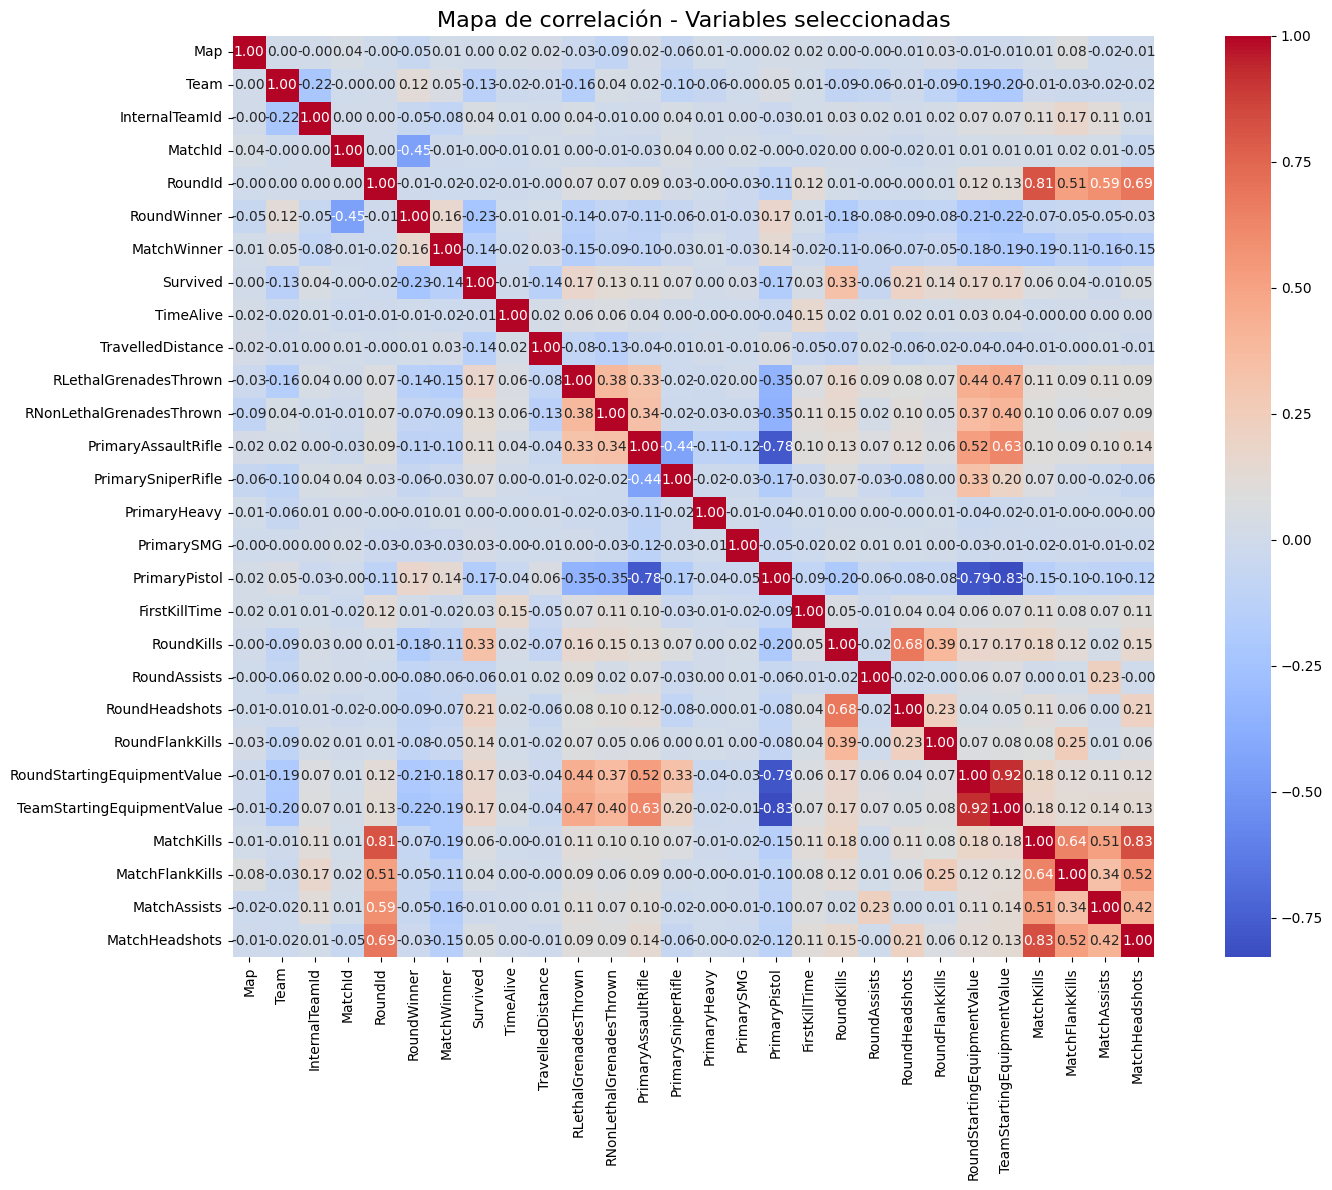

Correlación de variables con TimeAlive:
TimeAlive                      1.000000
FirstKillTime                  0.153232
RNonLethalGrenadesThrown       0.062707
RLethalGrenadesThrown          0.055345
TeamStartingEquipmentValue     0.036279
PrimaryAssaultRifle            0.035006
RoundStartingEquipmentValue    0.029435
RoundKills                     0.024526
RoundHeadshots                 0.017942
Map                            0.016720
TravelledDistance              0.015795
RoundFlankKills                0.011395
RoundAssists                   0.010686
InternalTeamId                 0.009412
MatchAssists                   0.002677
MatchHeadshots                 0.002576
PrimarySniperRifle             0.002086
MatchFlankKills                0.000322
MatchKills                    -0.000185
PrimarySMG                    -0.000626
PrimaryHeavy                  -0.002137
RoundWinner                   -0.006438
Survived                      -0.008137
RoundId                       -0.008173


In [ ]:
df_corr = df_var_num2.select_dtypes(include='number')

# Calcular la correlación
corr = df_corr.corr()

# Dibujar el mapa de calor
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de correlación - Variables seleccionadas", fontsize=16)
plt.tight_layout()
plt.show()

# Mostrar correlaciones con TimeAlive en orden descendente
correlaciones_timealive = corr["TimeAlive"].sort_values(ascending=False)
print("Correlación de variables con TimeAlive:")
print(correlaciones_timealive)

FirstKillTime es la variable que más se relaciona con el tiempo que un jugador permanece vivo, aunque la relación es débil. Esto se debe a que, si un jugador elimina a un enemigo rápido, reduce el riesgo de ser eliminado y tiene más probabilidad de sobrevivir.

PrimaryPistol tiene la relación más débil con el tiempo de vida, ya que usar una pistola no afecta mucho cuánto tiempo vive el jugador, depende más de otras decisiones y acciones.

###**Patrones/comportamientos detectados**



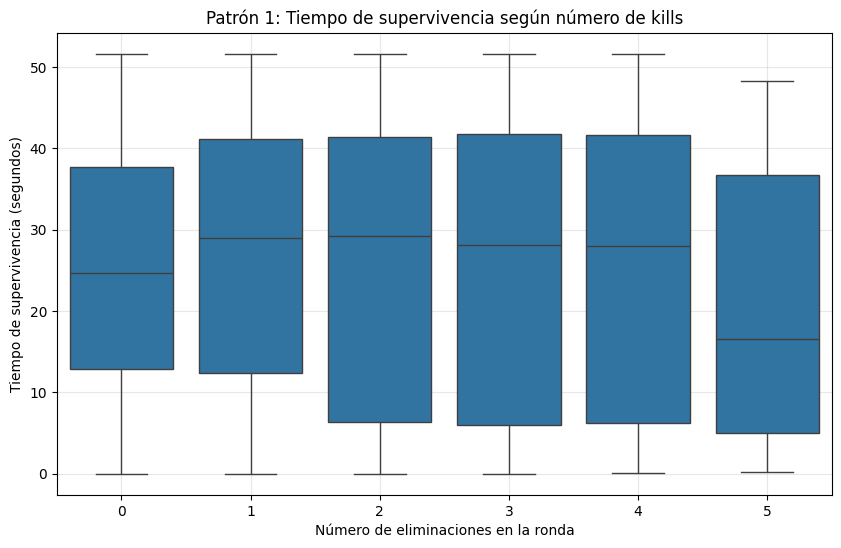

Tiempo medio de supervivencia según número de kills:
   RoundKills  TimeAlive
0           0  25.302157
1           1  26.977375
2           2  26.223890
3           3  25.696511
4           4  25.766590
5           5  20.739149


In [ ]:
# Patrón 1: Relación entre RoundKills y TimeAlive
plt.figure(figsize=(10, 6))
sns.boxplot(x='RoundKills', y='TimeAlive', data=df_var_num2[df_var_num2['RoundKills'] <= 5])
plt.title('Patrón 1: Tiempo de supervivencia según número de kills')
plt.xlabel('Número de eliminaciones en la ronda')
plt.ylabel('Tiempo de supervivencia (segundos)')
plt.grid(alpha=0.3)
plt.show()

# Análisis estadístico por número de kills
print("Tiempo medio de supervivencia según número de kills:")
print(df_var_num2.groupby('RoundKills')['TimeAlive'].mean().reset_index().head(6))


El gráfico sugiere que no hay una correlación lineal clara entre número de kills y tiempo de supervivencia. Jugadores pueden eliminar más y aun así morir rápido. Esto puede indicar que otros factores (como estrategia, ubicación o entre otro) influyen más en el tiempo que sobreviven.

Investigar ese gráfico sirve para entender la relación entre el número de kills (eliminaciones) y el tiempo de supervivencia en una partida. Esta información puede ser útil en varios contextos:
Identificar patrones de juego:
Puedes ver si los jugadores que sobreviven más tiempo suelen hacer más kills.Esto ayuda a entender distintos estilos de juego (ej. jugadores agresivos vs. jugadores que se esconden y sobreviven).

Evaluar habilidades o estrategias:
En análisis de rendimiento de jugadores, podrías detectar si alguien sobrevive mucho pero no mata (pasivo), o mata mucho pero muere rápido (agresivo).

Descartar hipótesis:
A veces se asume que más kills = más tiempo vivo.

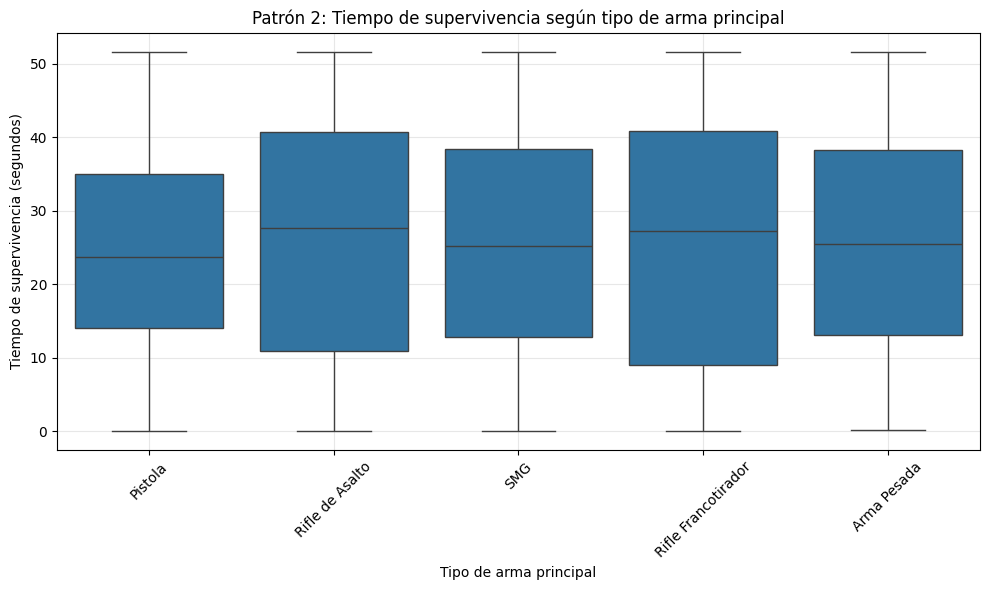

Tiempo medio de supervivencia según tipo de arma:
                       count       mean        std
WeaponCategory                                    
Arma Pesada            480.0  25.620665  14.976969
Pistola              17555.0  24.755748  13.052824
Rifle Francotirador   7046.0  26.012610  16.307165
Rifle de Asalto      53512.0  26.284562  16.035474
SMG                    561.0  25.688335  14.667307


In [ ]:
# Patrón 2: Análisis de supervivencia por tipo de arma primaria
# Crear variable para identificar el tipo de arma principal usada
df_var_num2['PrimaryWeaponType'] = np.argmax(df_var_num2[['PrimaryAssaultRifle', 'PrimarySniperRifle',
                                                        'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol']].values, axis=1)

weapon_names = {0: 'Rifle de Asalto', 1: 'Rifle Francotirador', 2: 'Arma Pesada',
               3: 'SMG', 4: 'Pistola'}

# Convertir a categorías nombradas
df_var_num2['WeaponCategory'] = df_var_num2['PrimaryWeaponType'].map(weapon_names)

plt.figure(figsize=(10, 6))
sns.boxplot(x='WeaponCategory', y='TimeAlive', data=df_var_num2)
plt.title('Patrón 2: Tiempo de supervivencia según tipo de arma principal')
plt.xlabel('Tipo de arma principal')
plt.ylabel('Tiempo de supervivencia (segundos)')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Tiempo medio de supervivencia según tipo de arma:")
print(df_var_num2.groupby('WeaponCategory')['TimeAlive'].describe()[['count', 'mean', 'std']])

El análisis indica que los jugadores que utilizan rifles de asalto y rifles francotiradores tienen un tiempo promedio de supervivencia más largo, lo cual parece estar relacionado con las características de estas armas y las estrategias de juego que fomentan. En contraste, el uso de pistolas se asocia con un menor tiempo de supervivencia, posiblemente por su uso en situaciones de desventaja.

Estudiar este gráfico es útil para entender cómo el tipo de arma influye en el tiempo de supervivencia del jugador, lo que puede ser valioso para ajustar las mecánicas del juego o diseñar estrategias. Este análisis tiene una relación directa con nuestra propuesta, ya que en ambos casos se busca predecir el tiempo de supervivencia, en tu caso usando variables como equipamiento, movilidad y desempeño. El gráfico muestra como diferentes tipos de armas los cuales afectan el tiempo de vida, lo cual puede contribuir a ajustar las variables y mejorar la precisión del modelo predictivo de tu propuesta.

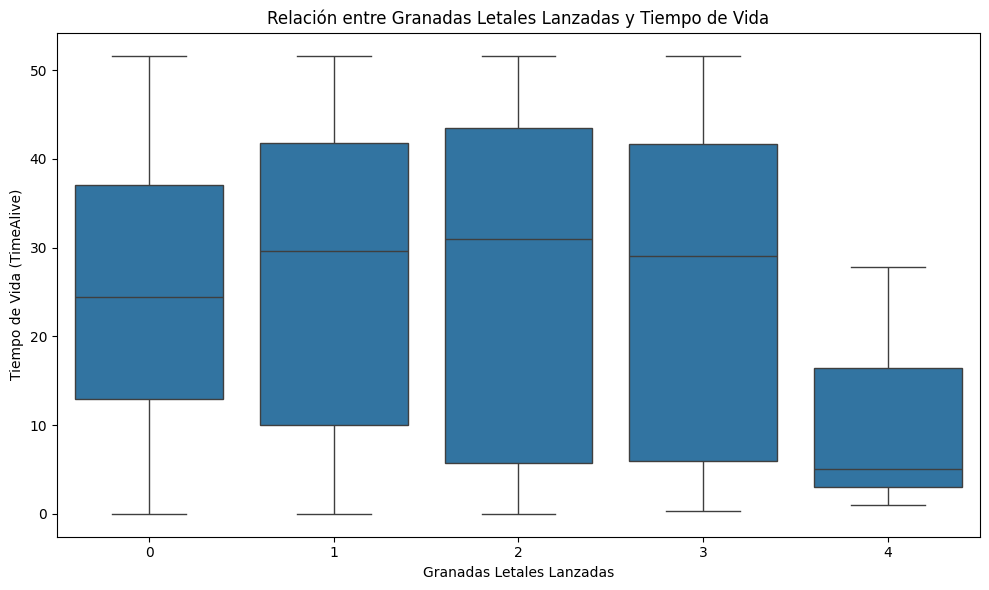

In [ ]:
# Patrón 3: Análisis de supervivencia por uso de granadas letales
plt.figure(figsize=(10, 6))
sns.boxplot(x='RLethalGrenadesThrown', y='TimeAlive', data=df_var_num2)

# Etiquetas y título
plt.xlabel('Granadas Letales Lanzadas')
plt.ylabel('Tiempo de Vida (TimeAlive)')
plt.title('Relación entre Granadas Letales Lanzadas y Tiempo de Vida')

# Mostrar gráfico
plt.tight_layout()
plt.show()


El gráfico muestra que los jugadores que lanzan entre 1 y 3 granadas letales tienden a tener un mayor tiempo de vida en promedio, mientras que quienes no lanzan ninguna o lanzan 4 presentan tiempos de vida más bajos. En especial, lanzar 4 granadas parece estar asociado con una supervivencia significativamente menor. Esto sugiere que existe un punto óptimo en el uso de granadas que podría estar vinculado con un estilo de juego más estratégico o efectivo, mientras que un uso excesivo o nulo podría relacionarse con comportamientos menos eficientes o situaciones de riesgo.

Estudiar este gráfico sirve para entender cómo una variable específica de equipamiento —en este caso, las granadas letales lanzadas— influye en el tiempo de supervivencia del jugador. Esto es útil para analizar comportamientos dentro del juego y puede ayudar en la toma de decisiones sobre diseño o balance de mecánicas.

Este análisis tiene relación busca predecir el tiempo de supervivencia (TimeAlive) en función de variables como el equipamiento. Este gráfico aporta evidencia sobre cómo el uso de granadas puede ser una variable significativa dentro del modelo.

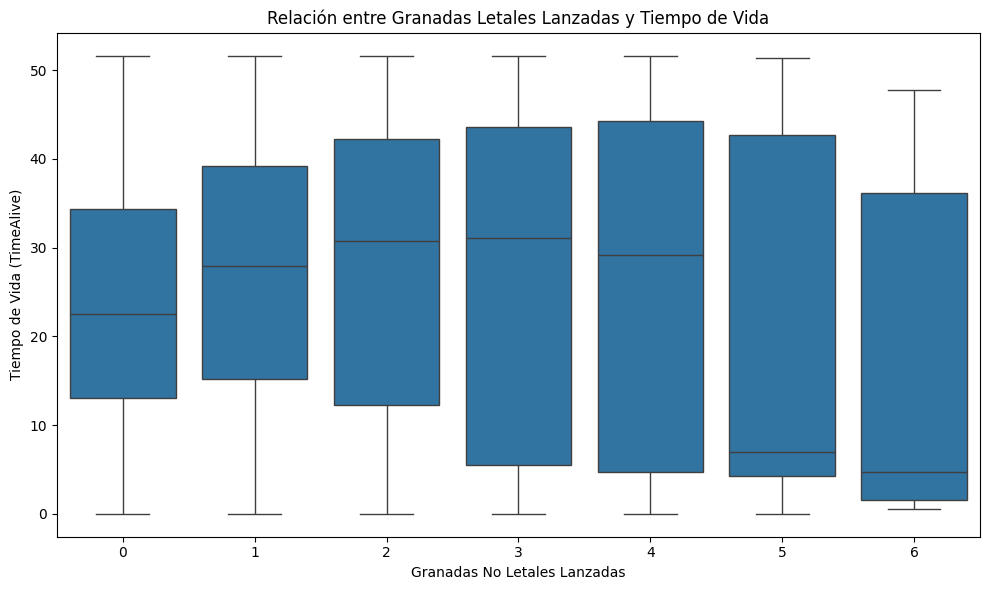

In [ ]:
# Patrón 3.1: Análisis de supervivencia por uso de granadas no letales
plt.figure(figsize=(10, 6))
sns.boxplot(x='RNonLethalGrenadesThrown', y='TimeAlive', data=df_var_num2)

# Etiquetas y título
plt.xlabel('Granadas No Letales Lanzadas')
plt.ylabel('Tiempo de Vida (TimeAlive)')
plt.title('Relación entre Granadas Letales Lanzadas y Tiempo de Vida')

# Mostrar gráfico
plt.tight_layout()
plt.show()

A partir del gráfico, se puede inferir que lanzar más granadas no letales no garantiza un mayor tiempo de vida (TimeAlive). De hecho, a partir de 3 o más granadas, el tiempo de vida tiende a volverse más inestable y, en muchos casos, incluso más bajo que cuando se lanzan menos o ninguna. Esto sugiere que el uso excesivo de granadas no letales podría no ser una estrategia efectiva para sobrevivir más tiempo, posiblemente porque se expone más el jugador o se descuida la cobertura.

Estudiar este gráfico sirve para detectar patrones entre la cantidad de acciones ofensivas (granadas lanzadas) y su impacto en cuánto tiempo permanece con vida el jugador. Puede ayudar a optimizar estrategias en entornos del videojuegos, al identificar puntos donde una acción deja de ser útil.

En relación con tu propuesta de tipo de predicción (regresión), este gráfico apoya su pertinencia, el tiempo de vida es un dato continuo influenciado por otro dato (granadas lanzadas), por lo tanto, modelarlo como un problema de regresión es adecuado.

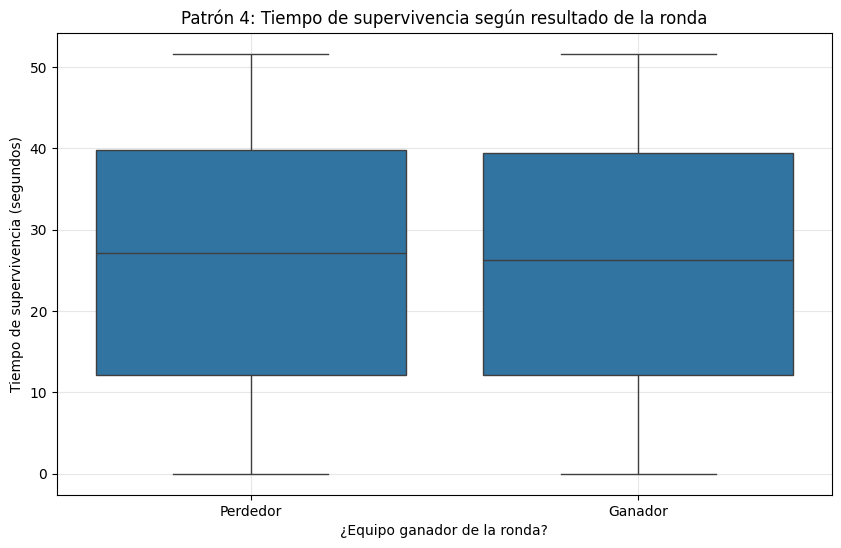

Tiempo medio de supervivencia según resultado de la ronda:
               count       mean        std
RoundWinner                               
0            23195.0  26.067481  15.621537
1            55959.0  25.849021  15.371501


In [ ]:
# Patrón 4: Análisis de tiempo de supervivencia por resultado de la ronda
plt.figure(figsize=(10, 6))
sns.boxplot(x='RoundWinner', y='TimeAlive', data=df_var_num2)
plt.title('Patrón 4: Tiempo de supervivencia según resultado de la ronda')
plt.xlabel('¿Equipo ganador de la ronda?')
plt.ylabel('Tiempo de supervivencia (segundos)')
plt.xticks([0, 1], ['Perdedor', 'Ganador'])
plt.grid(alpha=0.3)
plt.show()

print("Tiempo medio de supervivencia según resultado de la ronda:")
print(df_var_num2.groupby('RoundWinner')['TimeAlive'].describe()[['count', 'mean', 'std']])

El tiempo de supervivencia promedio es prácticamente igual tanto para jugadores del equipo perdedor como para los del equipo ganador (26.07 vs 25.85 segundos), lo que indica que sobrevivir más tiempo no necesariamente está relacionado con ganar la ronda. Ambos grupos presentan una distribución similar, con amplios rangos y una mediana muy cercana, lo que sugiere que otros factores influyen más en el resultado de la ronda que simplemente sobrevivir más tiempo.

Estudiar este gráfico sirve para entender si existe alguna conexión entre el rendimiento individual (medido por tiempo con vida) y el éxito colectivo del equipo. Es útil para evaluar la importancia del tiempo de supervivencia como indicador de victoria.

En relación con tu propuesta de predicción por regresión, este gráfico refuerza la idea de que el tiempo de supervivencia puede predecirse como un dato continuo. Aunque aquí se compara con un resultado binario (ganar o perder), el enfoque de regresión sigue siendo adecuado si tu interés está en predecir el tiempo con vida a partir de otras acciones del jugador o condiciones de la partida.

###**Nuevas variables a partir de análisis**

In [ ]:
df_news_var = df_var_num2.copy()

In [ ]:
# 1. Ratio de equipamiento: Porcentaje del equipamiento del jugador respecto al total del equipo
df_news_var['EquipmentRatio'] = df_news_var['RoundStartingEquipmentValue'] / df_news_var['TeamStartingEquipmentValue']

# 2. Eficiencia de combate: Ratio de kills por segundo de vida
df_news_var['CombatEfficiency'] = np.where(df_news_var['TimeAlive'] > 0,
                                          df_news_var['RoundKills'] / df_news_var['TimeAlive'],
                                          0)

# 3. Precisión de combate: Porcentaje de headshots sobre total de kills
df_news_var['HeadshotRatio'] = np.where(df_news_var['RoundKills'] > 0,
                                       df_news_var['RoundHeadshots'] / df_news_var['RoundKills'],
                                       0)

# 4. Índice de movilidad: Distancia recorrida por segundo de vida
df_news_var['MobilityIndex'] = np.where(df_news_var['TimeAlive'] > 0,
                                       df_news_var['TravelledDistance'] / df_news_var['TimeAlive'],
                                       0)

# 5. Índice de utilidad: Granadas lanzadas por segundo de vida
df_news_var['TotalGrenades'] = df_news_var['RLethalGrenadesThrown'] + df_news_var['RNonLethalGrenadesThrown']
df_news_var['UtilityIndex'] = np.where(df_news_var['TimeAlive'] > 0,
                                      df_news_var['TotalGrenades'] / df_news_var['TimeAlive'],
                                      0)

# 6. Índice de impacto: Combinación de kills y asistencias por segundo de vida
df_news_var['ImpactIndex'] = np.where(df_news_var['TimeAlive'] > 0,
                                     (df_news_var['RoundKills'] + 0.5*df_news_var['RoundAssists']) / df_news_var['TimeAlive'],
                                     0)

# 7. Índice táctico: Combinación ponderada de equipamiento, granadas y movilidad
df_news_var['TacticalIndex'] = (
    0.4 * df_news_var['EquipmentRatio'] +
    0.3 * df_news_var['UtilityIndex'] +
    0.3 * df_news_var['MobilityIndex']
)

# 8. Binning del tiempo de supervivencia en categorías
df_news_var['SurvivalCategory'] = pd.qcut(df_news_var['TimeAlive'], 4, labels=['Muy Corto', 'Corto', 'Medio', 'Largo'])

**EquipmentRatio:** Mide qué proporción del equipo total fue comprada por el jugador al inicio de la ronda.

**CombatEfficiency:** Indica cuántos enemigos eliminó el jugador por cada segundo que estuvo con vida.

**HeadshotRatio:** Representa el porcentaje de kills que fueron hechos con disparos a la cabeza.

**MobilityIndex:** Muestra qué tan rápido se movió el jugador en promedio durante la ronda.

**UtilityIndex:** Indica cuántas granadas lanzó el jugador por cada segundo de vida.

**ImpactIndex:** Refleja el impacto del jugador combinando kills y asistencias en relación a su tiempo vivo.

**TacticalIndex:** Resume el desempeño táctico del jugador considerando equipamiento, movilidad y uso de granadas.

**SurvivalCategory:** Clasifica al jugador según cuánto tiempo sobrevivió durante la ronda.

###**Matriz de Correlación con las Nuevas Variables**

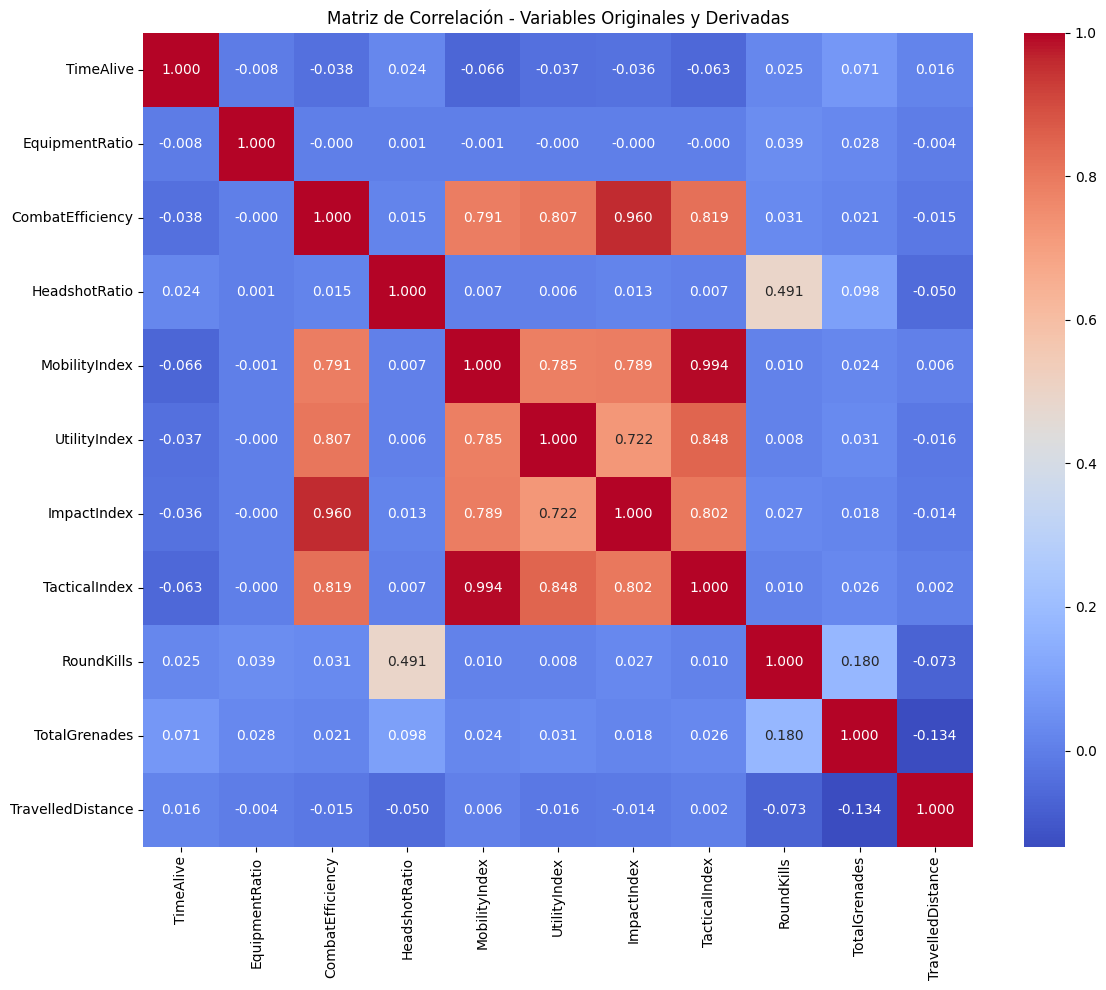

Correlaciones con TimeAlive (incluyendo variables derivadas):
TimeAlive            1.000000
TotalGrenades        0.070757
RoundKills           0.024526
HeadshotRatio        0.024425
TravelledDistance    0.015795
EquipmentRatio      -0.007707
ImpactIndex         -0.035630
UtilityIndex        -0.037186
CombatEfficiency    -0.037867
TacticalIndex       -0.062716
MobilityIndex       -0.065622
Name: TimeAlive, dtype: float64


In [ ]:
# Seleccionar variables relevantes incluyendo las nuevas
variables_ampliadas = ['TimeAlive', 'EquipmentRatio', 'CombatEfficiency', 'HeadshotRatio',
                      'MobilityIndex', 'UtilityIndex', 'ImpactIndex', 'TacticalIndex',
                      'RoundKills', 'TotalGrenades', 'TravelledDistance']

# Calcular correlaciones
plt.figure(figsize=(12, 10))
corr_matrix_ampliada = df_news_var[variables_ampliadas].corr()
sns.heatmap(corr_matrix_ampliada, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Matriz de Correlación - Variables Originales y Derivadas')
plt.tight_layout()
plt.show()

# Mostrar correlaciones con TimeAlive
correlacion_ampliada = df_news_var[variables_ampliadas].corr()['TimeAlive'].sort_values(ascending=False)
print("Correlaciones con TimeAlive (incluyendo variables derivadas):")
print(correlacion_ampliada)

El análisis muestra las correlaciones entre el tiempo de vida (TimeAlive) y diferentes variables, incluyendo las que fueron derivadas a partir de los datos originales. La única variable con una correlación ligeramente positiva destacable es el total de granadas lanzadas (TotalGrenades), con un valor de 0.07, lo que indica una relación muy débil. El número de muertes (RoundKills), la proporción de disparos a la cabeza (HeadshotRatio) y la distancia recorrida (TravelledDistance) también presentan correlaciones positivas pero mínimas. Por otro lado, índices como el de equipamiento, impacto, utilidad, eficiencia en combate, táctica y movilidad tienen correlaciones negativas, también muy débiles.

Esto indica que ninguna de las variables por sí sola tiene una relación fuerte con el tiempo de vida, lo que sugiere que la supervivencia del jugador podría depender de una combinación de múltiples factores más que de uno solo.

Estudiar este gráfico es útil para identificar qué variables podrían ser más relevantes al momento de construir un modelo predictivo y cuáles tal vez no aporten mucho valor por sí solas. En el contexto de nuestra propuesta de regresión, esta información es importante porque ayuda a seleccionar adecuadamente las variables que incluiremos en el modelo para predecir el tiempo de supervivencia (TimeAlive). Aunque las correlaciones son débiles, algunas combinaciones podrían ser significativas cuando se analizan juntas, lo cual es precisamente lo que permite un modelo de regresión multivariable

###**Patrones/comportamientos detectados con las nuevas variables**

<Figure size 1000x600 with 0 Axes>

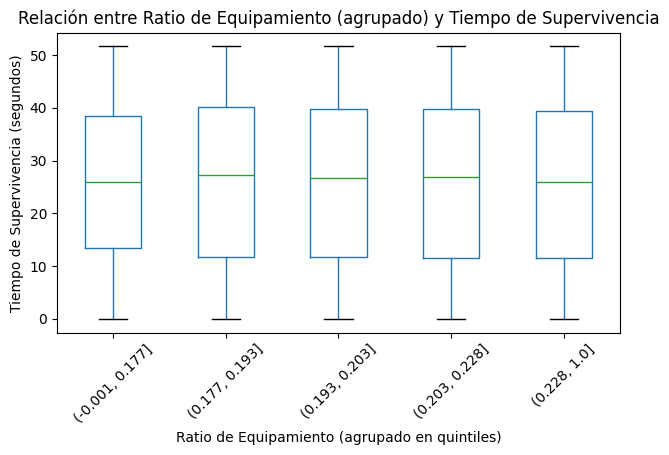

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Opcional: crear categorías para EquipmentRatio (por ejemplo, 5 grupos)
df_news_var['EquipmentRatio_bins'] = pd.qcut(df_news_var['EquipmentRatio'], q=5, duplicates='drop')

# Diagrama de caja: TimeAlive en función de los rangos de EquipmentRatio
plt.figure(figsize=(10, 6))
df_news_var.boxplot(column='TimeAlive', by='EquipmentRatio_bins', grid=False)

plt.title('Relación entre Ratio de Equipamiento (agrupado) y Tiempo de Supervivencia')
plt.suptitle('')  # Elimina el título automático generado por pandas
plt.xlabel('Ratio de Equipamiento (agrupado en quintiles)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Este diagrama de caja busca responder si invertir en mejor equipo realmente te ayuda a durar más tiempo en una ronda de Counter-Strike. Es una forma visual de ver si hay una relación clara entre tener un equipamiento valioso y la supervivencia de un jugador, lo cual es fundamental para las decisiones económicas y tácticas dentro del juego.
La línea dentro de cada caja es la mediana, que nos dice el tiempo de supervivencia típico para los jugadores en ese grupo de equipo. Si las cajas en los grupos de "más ratio de equipamiento" (a la derecha) son consistentemente más altas o sus medianas están más arriba, eso nos diría que los jugadores con mejor equipo tienden a sobrevivir más tiempo. Por otro lado, si las cajas se ven muy similares a lo largo de todos los grupos, podría indicar que el EquipmentRatio no tiene un impacto tan fuerte en el TimeAlive.

C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\1103674602.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EquipGroup', y='TimeAlive', data=df_news_var, palette=palette,
C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\1103674602.py:14: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='EquipGroup', y='TimeAlive', data=df_news_var, palette=palette,


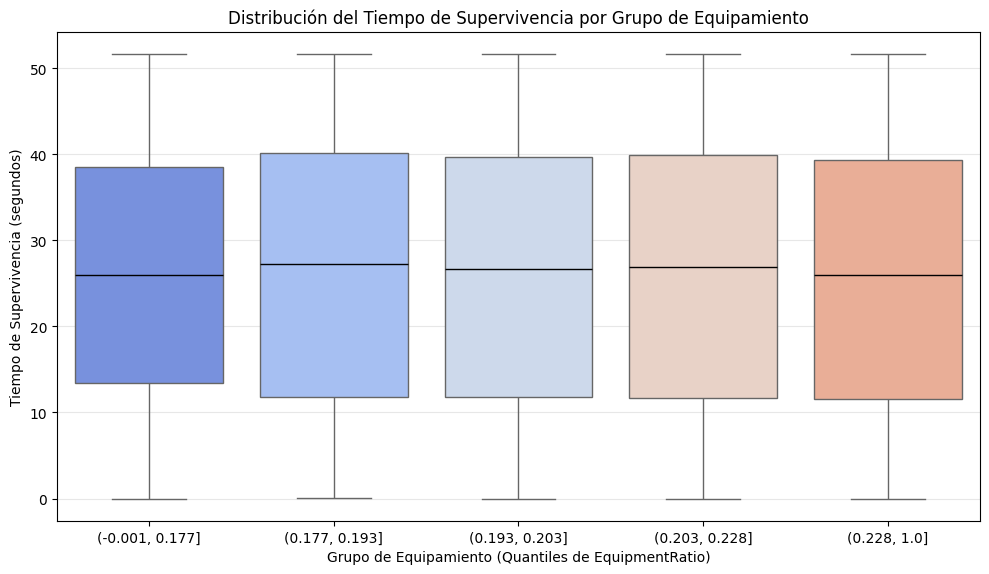

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear grupos basados en EquipmentRatio (5 cuantiles)
df_news_var['EquipGroup'] = pd.qcut(df_news_var['EquipmentRatio'], q=5, duplicates='drop')

# Paleta de colores (puedes cambiar 'coolwarm' por otra paleta)
palette = sns.color_palette("coolwarm", n_colors=len(df_news_var['EquipGroup'].unique()))

plt.figure(figsize=(10, 6))

# Crear boxplot con seaborn para mejor estilo y color
sns.boxplot(x='EquipGroup', y='TimeAlive', data=df_news_var, palette=palette,
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor='gray', markersize=4, alpha=0.6))

plt.title('Distribución del Tiempo de Supervivencia por Grupo de Equipamiento')
plt.xlabel('Grupo de Equipamiento (Quantiles de EquipmentRatio)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.grid(alpha=0.3, axis='y')
plt.suptitle('')  # Elimina el título automático de seaborn
plt.tight_layout()
plt.show()

El gráfico muestra la relación entre el Ratio de Equipamiento (proporción del equipamiento del jugador respecto al total del equipo) y el Tiempo de Supervivencia en una partida de Counter-Strike. La distribución dispersa de los puntos y el valor del coeficiente de correlación (-0.008) indican que no existe una relación lineal significativa entre estas dos variables. Es decir, contar con más o menos equipamiento en comparación con el equipo no parece influir directamente en cuánto tiempo sobrevive un jugador en la ronda.

Estudiar este gráfico es útil porque permite evaluar si una variable como el Ratio de Equipamiento debería incluirse como predictor en un modelo de regresión. En este caso, la baja correlación sugiere que, por sí sola, esta variable no tiene un valor predictivo relevante para el Tiempo de Supervivencia. Sin embargo, podría adquirir mayor utilidad si se combina con otras variables derivadas. Esta información es importante para nuestra propuesta de regresión, ya que nos ayuda a identificar qué factores tienen un verdadero impacto y cuáles podrían descartarse o ajustarse dentro del modelo predictivo que estamos desarrollando.

El análisis revela que existe una relación ligeramente negativa (-0.066) entre la movilidad de los jugadores y su tiempo de supervivencia. Los datos muestran que los jugadores con mayor movimiento (especialmente arriba de 5 m/s) tienden a vivir menos tiempo, posiblemente por mayor exposición al enemigo. Sin embargo, la correlación débil indica que la movilidad por sí sola no es determinante - otros factores como posición táctica y trabajo en equipo probablemente influyen más. El gráfico sugiere que encontrar un balance en la movilidad (evitando extremos) podría ser la estrategia óptima para maximizar el tiempo de vida en la partida.

C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\1393057723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['MobilityGroup'] = pd.qcut(df_filtrado['MobilityIndex'], q=5, duplicates='drop')
C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\1393057723.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MobilityGroup', y='TimeAlive', data=df_filtrado, palette=palette,


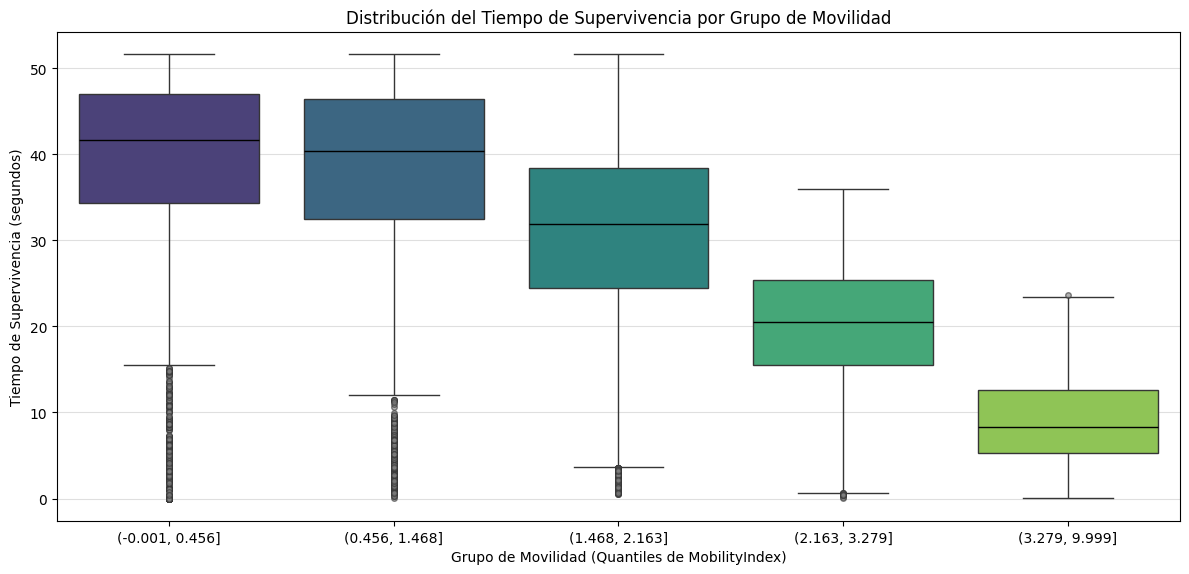

Correlación entre MobilityIndex y TimeAlive: -0.745


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar datos (máximo 10 m/s)
df_filtrado = df_news_var[df_news_var['MobilityIndex'] <= 10]

# Crear grupos basados en MobilityIndex (por ejemplo, 5 cuantiles)
df_filtrado['MobilityGroup'] = pd.qcut(df_filtrado['MobilityIndex'], q=5, duplicates='drop')

# Paleta de colores (puedes cambiar 'viridis' por otra paleta como 'coolwarm', 'plasma', etc.)
palette = sns.color_palette("viridis", n_colors=len(df_filtrado['MobilityGroup'].unique()))

# Gráfico boxplot con estilo y color
plt.figure(figsize=(12, 6))
sns.boxplot(x='MobilityGroup', y='TimeAlive', data=df_filtrado, palette=palette,
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor='gray', markersize=4, alpha=0.6))

# Configuración del gráfico
plt.title('Distribución del Tiempo de Supervivencia por Grupo de Movilidad')
plt.xlabel('Grupo de Movilidad (Quantiles de MobilityIndex)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.grid(True, axis='y', alpha=0.4)
plt.suptitle('')
plt.tight_layout()
plt.show()

# Mostrar correlación
print(f"Correlación entre MobilityIndex y TimeAlive: {df_filtrado['MobilityIndex'].corr(df_filtrado['TimeAlive']):.3f}")

El diagrama de caja muestra visualmente la dispersión del tiempo que un jugador pasa vivo (eje vertical) para cada uno de los cinco grupos de equipamiento (eje horizontal). La línea horizontal dentro de cada caja representa el tiempo de supervivencia promedio para ese grupo de equipo. Las cajas nos dan una idea de dónde se concentra la mayoría de los datos, y las líneas que salen de las cajas muestran el rango general de supervivencia.

C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\2168570848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['ImpactGroup'] = pd.qcut(df_filtrado['ImpactIndex'], q=5, duplicates='drop')
C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\2168570848.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ImpactGroup', y='TimeAlive', data=df_filtrado, palette=palette,


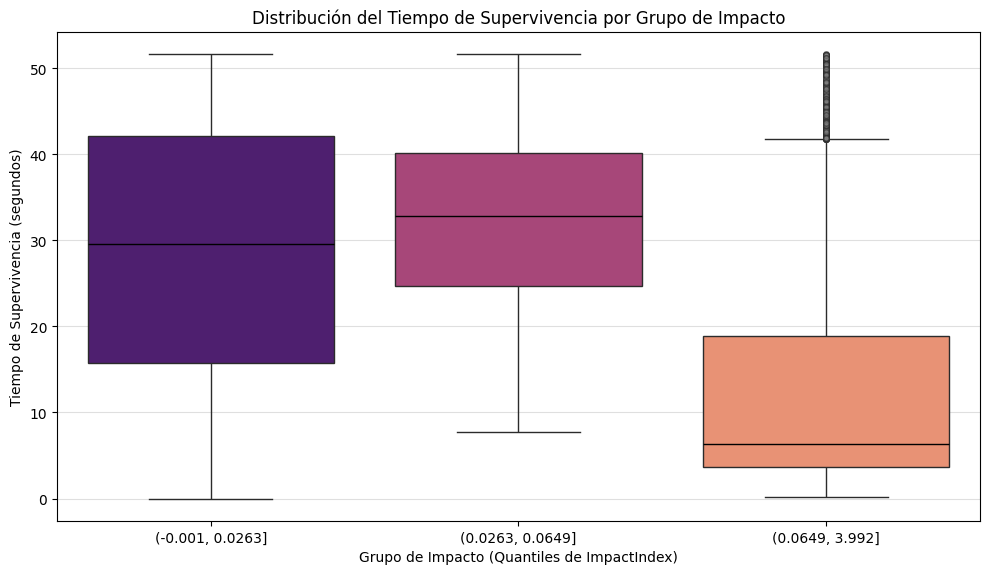

Correlación entre ImpactIndex y TimeAlive: -0.357


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar datos (máximo ImpactIndex = 4)
df_filtrado = df_news_var[df_news_var['ImpactIndex'] <= 4]

# Crear grupos basados en ImpactIndex (5 cuantiles)
df_filtrado['ImpactGroup'] = pd.qcut(df_filtrado['ImpactIndex'], q=5, duplicates='drop')

# Paleta de colores (puedes cambiar 'magma' por otra paleta como 'viridis', 'coolwarm', etc.)
palette = sns.color_palette("magma", n_colors=len(df_filtrado['ImpactGroup'].unique()))

# Gráfico boxplot con estilo y color
plt.figure(figsize=(10, 6))
sns.boxplot(x='ImpactGroup', y='TimeAlive', data=df_filtrado, palette=palette,
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor='gray', markersize=4, alpha=0.6))

# Configuración del gráfico
plt.title('Distribución del Tiempo de Supervivencia por Grupo de Impacto')
plt.xlabel('Grupo de Impacto (Quantiles de ImpactIndex)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.grid(True, axis='y', alpha=0.4)
plt.suptitle('')
plt.tight_layout()
plt.show()

# Mostrar correlación
print(f"Correlación entre ImpactIndex y TimeAlive: {df_filtrado['ImpactIndex'].corr(df_filtrado['TimeAlive']):.3f}")

El gráfico muestra una relación ligeramente negativa (-0.036) entre el índice de impacto (kills + asistencias por segundo) y el tiempo de supervivencia, indicando que los jugadores más agresivos tienden a vivir un poco menos. Aunque la correlación es débil, se observa que: 1) los jugadores con alto índice de impacto (≥3) muestran menor tiempo de vida promedio, 2) existe mayor dispersión en los resultados entre los jugadores más activos, y 3) la línea de tendencia confirma un descenso mínimo pero consistente. Esto sugiere que el estilo de juego hiper-agresivo, aunque efectivo para conseguir kills, puede comprometer levemente la supervivencia, posiblemente por asumir mayores riesgos posicionales.

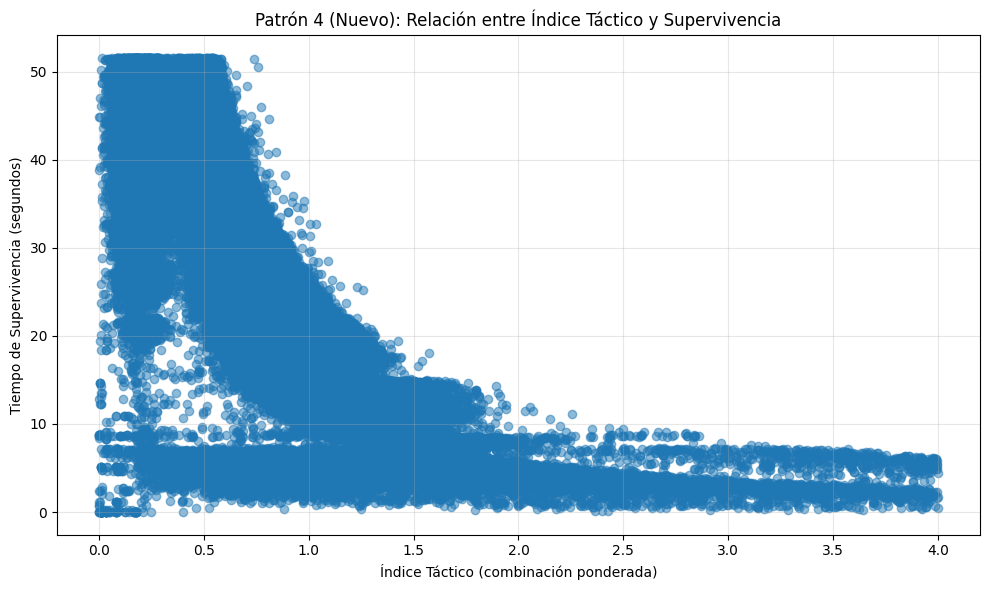

Correlación entre TacticalIndex y TimeAlive: -0.063


In [ ]:
# Patrón 4: Análisis del Índice Táctico

df_filtrado = df_news_var[df_news_var['TacticalIndex'] <= 4]
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['TacticalIndex'], df_filtrado['TimeAlive'], alpha=0.5)

plt.title('Patrón 4 (Nuevo): Relación entre Índice Táctico y Supervivencia')
plt.xlabel('Índice Táctico (combinación ponderada)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Correlación entre TacticalIndex y TimeAlive: {df_news_var['TacticalIndex'].corr(df_news_var['TimeAlive']):.3f}")

C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\309440048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['TacticalGroup'] = pd.qcut(df_filtrado['TacticalIndex'], q=5, duplicates='drop')
C:\Users\Elias\AppData\Local\Temp\ipykernel_1540\309440048.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TacticalGroup', y='TimeAlive', data=df_filtrado, palette=palette,


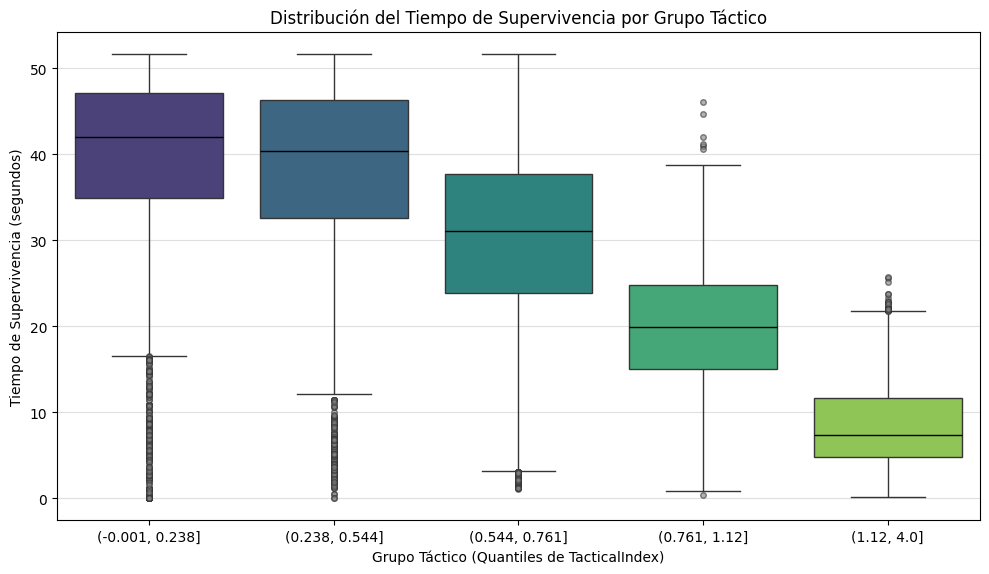

Correlación entre TacticalIndex y TimeAlive: -0.738


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar datos (máximo TacticalIndex = 4)
df_filtrado = df_news_var[df_news_var['TacticalIndex'] <= 4]

# Crear grupos basados en TacticalIndex (5 cuantiles)
df_filtrado['TacticalGroup'] = pd.qcut(df_filtrado['TacticalIndex'], q=5, duplicates='drop')

# Paleta de colores (puedes cambiar 'viridis' por otras como 'coolwarm', 'plasma', etc.)
palette = sns.color_palette("viridis", n_colors=len(df_filtrado['TacticalGroup'].unique()))

# Gráfico boxplot con estilo y color
plt.figure(figsize=(10, 6))
sns.boxplot(x='TacticalGroup', y='TimeAlive', data=df_filtrado, palette=palette,
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor='gray', markersize=4, alpha=0.6))

# Configuración del gráfico
plt.title('Distribución del Tiempo de Supervivencia por Grupo Táctico')
plt.xlabel('Grupo Táctico (Quantiles de TacticalIndex)')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.grid(True, axis='y', alpha=0.4)
plt.suptitle('')
plt.tight_layout()
plt.show()

# Mostrar correlación usando el DataFrame filtrado
print(f"Correlación entre TacticalIndex y TimeAlive: {df_filtrado['TacticalIndex'].corr(df_filtrado['TimeAlive']):.3f}")

El gráfico muestra la relación entre el Índice Táctico (una combinación del equipamiento, el uso de granadas y la movilidad) y el Tiempo de Supervivencia. La correlación es baja y negativa (-0.063), lo que indica que no hay una relación clara entre tener un buen valor táctico y vivir más tiempo en la partida. Esto puede significar que, aunque un jugador esté bien equipado, se mueva mucho y use granadas, eso no garantiza que sobreviva más.

Estudiar este gráfico sirve para saber si el Índice Táctico ayuda a predecir el Tiempo de Supervivencia. En este caso, parece que no tiene mucha influencia por sí solo. Sin embargo, puede ser útil si se analiza junto con otras variables. Esto se relaciona con nuestra propuesta de regresión porque estamos buscando qué factores ayudan a predecir cuánto vive un jugador, y este análisis nos ayuda a tomar decisiones sobre qué incluir en el modelo.

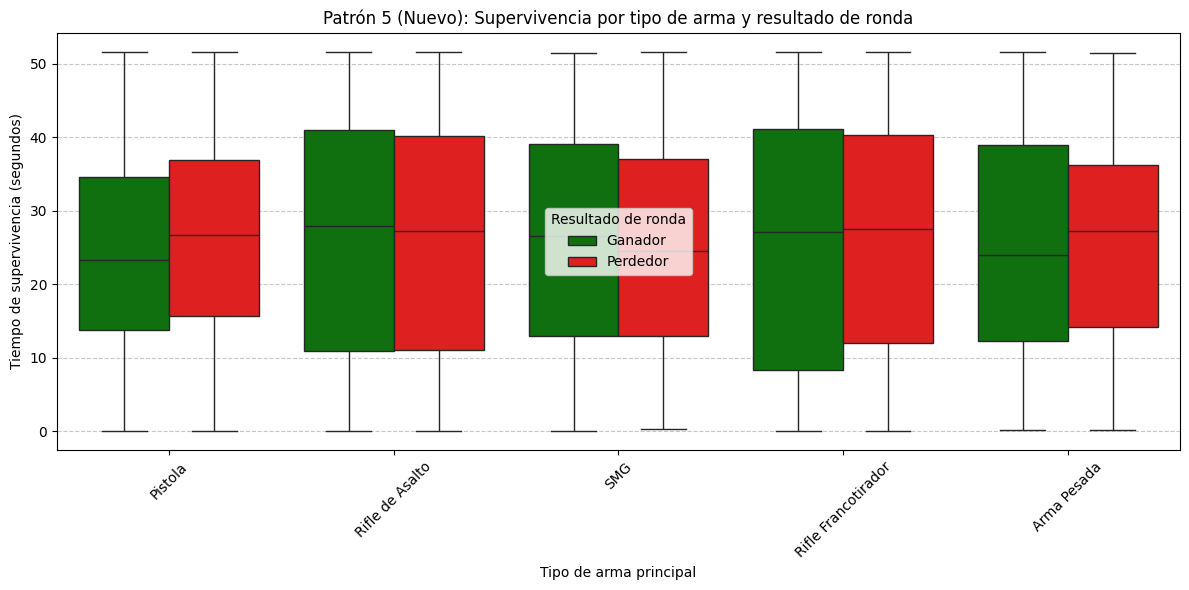

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))

# Especifica colores personalizados para 'Perdedor' y 'Ganador'
custom_palette = {"Perdedor": "red", "Ganador": "green"}

# Map numerical values in 'RoundWinner' to string labels
# Assuming 0 corresponds to 'Perdedor' and 1 corresponds to 'Ganador'
df_news_var['RoundWinner_Label'] = df_news_var['RoundWinner'].map({0: 'Perdedor', 1: 'Ganador'})


sns.boxplot(
    x='WeaponCategory',
    y='TimeAlive',
    hue='RoundWinner_Label', # Use the new column with string labels
    data=df_news_var,
    palette=custom_palette  # Aplica la paleta de colores
)

plt.title('Patrón 5 (Nuevo): Supervivencia por tipo de arma y resultado de ronda')
plt.xlabel('Tipo de arma principal')
plt.ylabel('Tiempo de supervivencia (segundos)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# The legend should now automatically pick up the labels from 'RoundWinner_Label'
# You might not need the explicit legend handles definition anymore, but keeping it
# doesn't hurt if you want to be explicit.
plt.legend(title='Resultado de ronda')


plt.tight_layout()
plt.show()

El gráfico muestra el tiempo medio de supervivencia según el tipo de arma utilizada y si el jugador ganó o perdió la ronda. Se observa que los jugadores que ganan tienden a tener tiempos de supervivencia más altos con rifles de asalto, rifles francotiradores y subfusiles (SMG), mientras que las pistolas y armas pesadas presentan una disminución notable en el tiempo de vida cuando se gana la ronda. En general, los rifles de asalto son el único tipo de arma con un aumento claro de tiempo de supervivencia en rondas ganadas, lo que sugiere que podrían estar relacionados con estilos de juego más eficaces o que permiten mantener la vida durante más tiempo en contextos de éxito.

Estudiar este gráfico es útil para entender cómo el desempeño de los jugadores y su tiempo de vida varían dependiendo del armamento y del resultado de la ronda. Esta información es valiosa para afinar estrategias y, sobre todo, para definir variables relevantes dentro de modelos predictivos. Está directamente relacionada con nuestra propuesta de regresión, ya que aporta evidencia de que el tipo de arma y el resultado de la ronda podrían ser variables importantes para predecir el Tiempo de Supervivencia.

###**Hallazgos clave y próximos pasos potenciales**

FirstKillTime tiene la correlación más fuerte (aunque débil) con TimeAlive, sugiriendo que las primeras kills podrían ser importantes.

Otros outliers podrían requerir tratamientos similares o diferentes.

Modelado: Basado en el EDA, se podrían desarrollar modelos predictivos para predecir TimeAlive. Características como tipo de arma principal, uso de granadas, valor del equipamiento, kills y características diseñadas podrían usarse en el modelo.

Investigaciones más profundas sobre interacciones entre características y relaciones no lineales podrían proporcionar más insights valiosos.

El análisis exploratorio de datos (EDA) realizado sobre el conjunto de datos de partidas de Counter-Strike: GO reveló patrones interesantes sobre el tiempo de supervivencia de los jugadores.

Si bien no se encontraron correlaciones fuertes entre el tiempo de vida y variables individuales como el equipamiento, las kills o la movilidad, se identificaron algunas tendencias que sugieren la importancia de analizar combinaciones de variables.

El uso de granadas, tanto letales como no letales, mostró una relación no lineal con el tiempo de supervivencia. Se observó que las nuevas variables derivadas (EquipmentRatio, CombatEfficiency, etc.) no mostraron correlaciones significativas con TimeAlive por sí solas, pero podrían ser útiles en combinación con otras variables.


## Fase 3: Data Preparation

###**Escalamiento**

In [ ]:
import pandas as pd
from sklearn import preprocessing
# Seleccionar solo columnas numéricas de la base dato
columnas_numericas = df_news_var.select_dtypes(include=['float64', 'int64'])

# Aplicar escalado estándar a esas columnas
datos_std_scaler = preprocessing.StandardScaler().fit_transform(columnas_numericas)

# Crear un nuevo DataFrame con los datos escalados y los mismos nombres de columnas
df_escalado = pd.DataFrame(datos_std_scaler, columns=columnas_numericas.columns)

In [ ]:
from sklearn import preprocessing
columnas_sin_nan = columnas_numericas.dropna()

normalizador = preprocessing.Normalizer()

# Aplicamos normalización por fila
datos_normalizados = normalizador.fit_transform(columnas_sin_nan)

# Creamos un nuevo DataFrame con los datos normalizados
df_normalizado = pd.DataFrame(datos_normalizados, columns=columnas_sin_nan.columns)

df_normalizado.head(10)

InternalTeamId   MatchId   RoundId  TimeAlive  TravelledDistance  \
0        0.000224  0.000896  0.000224   0.006393           0.001146   
1        0.000224  0.000894  0.000224   0.004340           0.012553   
2        0.000222  0.000886  0.000222   0.003058           0.010196   
3        0.000223  0.000892  0.000223   0.004721           0.015741   
4        0.000222  0.000886  0.000222   0.005727           0.001982   
5        0.000520  0.001040  0.000260   0.006719           0.018663   
6        0.000530  0.001060  0.000265   0.006851           0.017422   
7        0.000522  0.001043  0.000261   0.006738           0.014397   
8        0.000520  0.001040  0.000260   0.006719           0.018069   
9        0.000520  0.001040  0.000260   0.006719           0.016406   

   RLethalGrenadesThrown  RNonLethalGrenadesThrown  PrimaryAssaultRifle  \
0               0.000000                  0.000896                  0.0   
1               0.000000                  0.000000                  0.0   
2               0.000000                  0.000000                  0.0   
3               0.000000                  0.000000                  0.0   
4               0.000222                  0.000222                  0.0   
5               0.000000                  0.000000                  0.0   
6               0.000000                  0.000530                  0.0   
7               0.000000                  0.000000                  0.0   
8               0.000000                  0.000000                  0.0   
9               0.000000                  0.000000                  0.0   

   PrimarySniperRifle  PrimaryHeavy  PrimarySMG  PrimaryPistol  FirstKillTime  \
0                 0.0           0.0         0.0       0.000224       0.000000   
1                 0.0           0.0         0.0       0.000224       0.000000   
2                 0.0           0.0         0.0       0.000222       0.000000   
3                 0.0           0.0         0.0       0.000223       0.000000   
4                 0.0           0.0         0.0       0.000222       0.000000   
5                 0.0           0.0         0.0       0.000260       0.000000   
6                 0.0           0.0         0.0       0.000265       0.000000   
7                 0.0           0.0         0.0       0.000261       0.000000   
8                 0.0           0.0         0.0       0.000260       0.002795   
9                 0.0           0.0         0.0       0.000260       0.004367   

   RoundKills  RoundAssists  RoundHeadshots  RoundFlankKills  \
0     0.00000      0.000000         0.00000          0.00000   
1     0.00000      0.000000         0.00000          0.00000   
2     0.00000      0.000000         0.00000          0.00000   
3     0.00000      0.000000         0.00000          0.00000   
4     0.00000      0.000000         0.00000          0.00000   
5     0.00000      0.000000         0.00000          0.00000   
6     0.00000      0.000000         0.00000          0.00000   
7     0.00000      0.000261         0.00000          0.00000   
8     0.00078      0.000000         0.00026          0.00026   
9     0.00052      0.000000         0.00052          0.00000   

   RoundStartingEquipmentValue  TeamStartingEquipmentValue  MatchKills  \
0                     0.168027                    0.985759     0.00000   
1                     0.178869                    0.983782     0.00000   
2                     0.221608                    0.975076     0.00000   
3                     0.189649                    0.981713     0.00000   
4                     0.221617                    0.975114     0.00000   
5                     0.221015                    0.975067     0.00000   
6                     0.106046                    0.994183     0.00000   
7                     0.208612                    0.977868     0.00000   
8                     0.221017                    0.975073     0.00078   
9                     0.221022                    0.975096



Primero, el código selecciona solo las columnas numéricas (que son de tipo "float64" o "int64") de un DataFrame llamado "df\_news\_var". Esto asegura que solo se trabajen con los datos numéricos, como las estadísticas del jugador en *CS\:GO*, que incluyen eliminaciones, muertes y precisión, y se ignoren otros tipos de datos no relevantes.

Luego, se aplica una técnica llamada "escalado estándar". El escalado estándar ajusta los datos para que tengan una media de 0 y una desviación estándar de 1. Esto es útil en *CS\:GO* porque las métricas como eliminaciones y precisión pueden tener rangos muy diferentes. El escalado asegura que todas las estadísticas estén en una escala similar, lo que permite compararlas de manera justa.

Después de aplicar el escalado, se crea un nuevo DataFrame "df\_escalado" con los datos transformados. Este DataFrame tiene las mismas columnas que el original, pero los valores han sido ajustados para estar en la misma escala.

Este proceso es útil porque facilita el análisis y la comparación de las estadísticas de los jugadores, sin que las métricas con valores más grandes (como eliminaciones) dominen sobre otras métricas más pequeñas (como precisión).



Primero, el código elimina las filas que tienen valores vacíos (NaN) en las columnas numéricas. Esto se hace para asegurarse de que solo se trabajen con filas completas y no haya problemas al realizar cálculos o transformaciones. Si se dejara un valor faltante, podría afectar los resultados, ya que muchos algoritmos y técnicas no funcionan bien con datos incompletos.

Luego, se crea un "normalizador", que es una herramienta para hacer que todos los valores de cada fila sean más comparables. La normalización ajusta los valores de cada fila para que tengan una magnitud de 1, pero sin cambiar la relación entre los valores dentro de la fila. Esto es útil cuando se necesitan comparar datos que pueden estar en escalas muy diferentes, como las estadísticas de un jugador en CS:GO (por ejemplo, número de eliminaciones y porcentaje de precisión). Sin la normalización, las métricas con valores grandes (como eliminaciones) dominarían otras más pequeñas (como precisión), lo que podría distorsionar el análisis de rendimiento del jugador.

El normalizador se aplica a los datos, y convierte cada fila en un vector cuya magnitud es 1. De esta forma, todas las filas se tratan de manera similar, sin que los valores grandes o pequeños interfieran en el análisis. Esto es útil, especialmente en algoritmos de aprendizaje automático, ya que muchos modelos, como las redes neuronales o las máquinas de soporte vectorial, son sensibles a las escalas de los datos.

Finalmente, se crea un nuevo conjunto de datos con los valores normalizados y se muestran las primeras filas de este nuevo conjunto para ver cómo quedaron los datos después de la normalización. Al mostrar solo una muestra, se puede verificar que el proceso se haya realizado correctamente y comprobar que las filas ahora tienen una magnitud uniforme.

## Fase 4: Modeling

## Modelos de Regresion

####**Hipótesis 1 (Regresión):**
El objetivo es predecir `TimeAlive` (Tiempo de Vida) usando `TravelledDistance` (Distancia Recorrida) y `RoundKills` (Muertes por Ronda). Se probaron varios modelos de regresión y se optimizaron para encontrar el mejor desempeño.

Variables predictoras (X) para H1:


=== MODELOS BÁSICOS DE REGRESIÓN CON GRID SEARCH ===

Regresión Lineal:
R squared on training set: 52.58%
R squared on test set: 50.55%


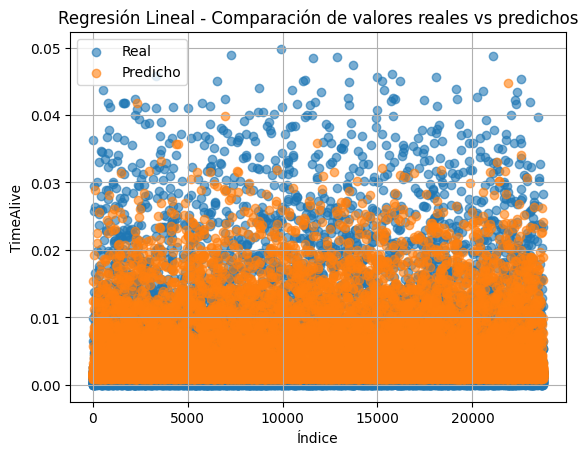


Optimizando SVR con GridSearch...
Mejores parámetros para SVR: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}
Mejor score (R2) en validación cruzada: -1300.03%

SVR:
R squared on training set: -1300.44%
R squared on test set: -1296.10%


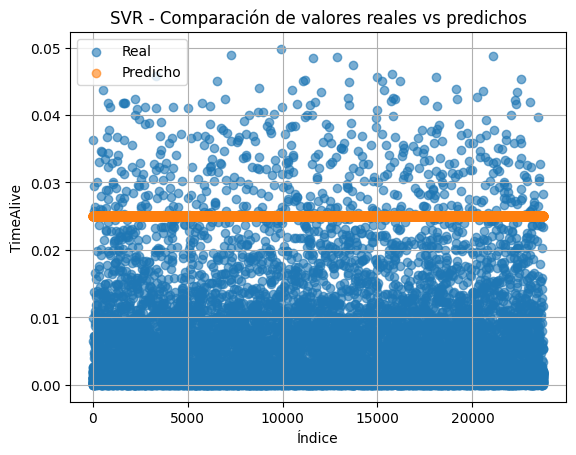


Optimizando Árbol de Decisión con GridSearch...
Mejores parámetros para Árbol de Decisión: {'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_split': 2}
Mejor score (R2) en validación cruzada: 56.85%

Árbol de Decisión:
R squared on training set: 57.91%
R squared on test set: 54.18%


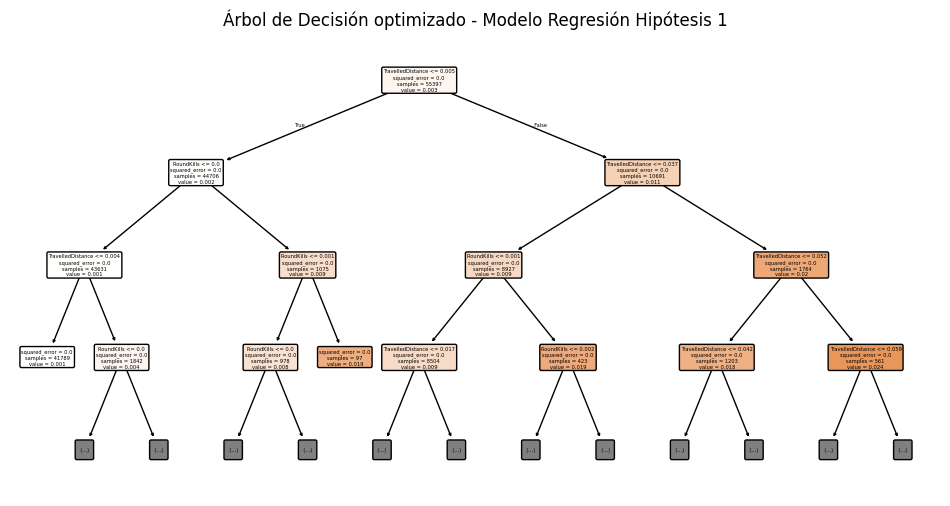


Resumen de métricas para modelos básicos optimizados:
                        MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal   0.001974  0.000018  0.004209   0.505533   0.525809
SVR                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión  0.001868  0.000016  0.004052   0.541781   0.579141

=== RANDOM FOREST REGRESSOR ===
Best score:  0.5701756963345227
Best params:  {'max_leaf_nodes': 15, 'min_samples_split': 2, 'n_estimators': 100}
MSE:  1.632628772162015e-05
MAE:  0.0018502574454612067
R^2:  0.5436732323584685

=== ADABOOST REGRESSOR ===
Best score:  0.44279799496554684
Best params:  {'estimator__max_depth': 3, 'estimator__max_leaf_nodes': 5, 'estimator__min_samples_split': 2, 'n_estimators': 10}
MSE:  2.084326348234832e-05
MAE:  0.0025909200239039305
R^2:  0.41742181601973405

=== RESUMEN FINAL DE TODOS LOS MODELOS ===
                        MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal   0.001974  0.000018  0.004209   0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Datos para Hipótesis 1 (Regresión)
X = df_normalizado[["TravelledDistance", "RoundKills"]]
y = df_normalizado["TimeAlive"]

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==============================================
# PRIMER CONJUNTO DE MODELOS (REGRESIÓN BÁSICA CON OPTIMIZACIÓN)
# ==============================================

print("\n=== MODELOS BÁSICOS DE REGRESIÓN CON GRID SEARCH ===")
modelos_basicos = {
    "Regresión Lineal": LinearRegression(),
    "SVR": SVR(),
    "Árbol de Decisión": DecisionTreeRegressor(random_state=42)
}

# Parámetros para GridSearch
params_basicos = {
    "SVR": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'epsilon': [0.1, 0.2]
    },
    "Árbol de Decisión": {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'max_leaf_nodes': [5, 10, 20]
    }
}

resultados = {}

for nombre, modelo in modelos_basicos.items():
    if nombre in params_basicos:
        # Usamos GridSearch para modelos con parámetros definidos
        print(f"\nOptimizando {nombre} con GridSearch...")
        grid = GridSearchCV(estimator=modelo, param_grid=params_basicos[nombre], cv=5)
        grid.fit(X_train, y_train)
        modelo = grid.best_estimator_

        print(f"Mejores parámetros para {nombre}: {grid.best_params_}")
        print(f"Mejor score (R2) en validación cruzada: {grid.best_score_:.2%}")
    else:
        # Para regresión lineal (sin GridSearch)
        modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_train_pred = modelo.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    resultados[nombre] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2_test": r2_test,
        "R2_train": r2_train
    }

    print(f"\n{nombre}:")
    print("R squared on training set: {:.2%}".format(r2_train))
    print("R squared on test set: {:.2%}".format(r2_test))

    # Visualización con colores separados solo para regresión lineal y SVR
    if nombre != "Árbol de Decisión":
        plt.figure()
        plt.scatter(range(len(y_test)), y_test, label="Real", alpha=0.6)
        plt.scatter(range(len(y_pred)), y_pred, label="Predicho", alpha=0.6)
        plt.xlabel("Índice")
        plt.ylabel("TimeAlive")
        plt.title(f"{nombre} - Comparación de valores reales vs predichos")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Visualizar el árbol si es un modelo de árbol
    if nombre == "Árbol de Decisión":
        plt.figure(figsize=(12, 6))
        plot_tree(modelo, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
        plt.title("Árbol de Decisión optimizado - Modelo Regresión Hipótesis 1")
        plt.show()

# Mostrar resultados
print("\nResumen de métricas para modelos básicos optimizados:")
print(pd.DataFrame(resultados).T)

# ==============================================
# MODELO RANDOM FOREST CON GRID SEARCH
# ==============================================

print("\n=== RANDOM FOREST REGRESSOR ===")
# Nueva división de datos (80% train, 20% test)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(random_state=42)

params_rf = {
    "n_estimators": [100],
    "min_samples_split": [2, 3, 4],
    "max_leaf_nodes": [5, 8, 10, 15]
}

grid_rf = GridSearchCV(estimator=model_rf, param_grid=params_rf, cv=5)
grid_rf.fit(Xtrain, Ytrain)

print("Best score: ", grid_rf.best_score_)
print("Best params: ", grid_rf.best_params_)

Yhat = grid_rf.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados["Random Forest"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_rf.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# MODELO ADABOOST CON GRID SEARCH
# ==============================================

print("\n=== ADABOOST REGRESSOR ===")
# Usamos la misma división de datos que para Random Forest

base_estimator = DecisionTreeRegressor(random_state=42)
model_ada = AdaBoostRegressor(base_estimator, random_state=42)

params_ada = {
    "n_estimators": [10, 50],
    "estimator__max_depth": [2, 3],
    "estimator__max_leaf_nodes": [5, 8],
    "estimator__min_samples_split": [2, 3, 4]
}

grid_ada = GridSearchCV(estimator=model_ada, param_grid=params_ada, cv=5)
grid_ada.fit(Xtrain, Ytrain)

print("Best score: ", grid_ada.best_score_)
print("Best params: ", grid_ada.best_params_)

Yhat = grid_ada.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados["AdaBoost"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_ada.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# RESUMEN FINAL DE TODOS LOS MODELOS
# ==============================================

print("\n=== RESUMEN FINAL DE TODOS LOS MODELOS ===")
print(pd.DataFrame(resultados).T)

- **Regresión Lineal:**
    - **R-cuadrado (R2) en entrenamiento:** 52.58%
    - **R-cuadrado (R2) en prueba:** 50.55%
    - **Gráfico de comparación:** Muestra que las predicciones (puntos anaranjados) de la regresión lineal siguen una tendencia similar a los valores reales (puntos azules), pero hay una dispersión considerable. **Logra capturar una parte de la relación, pero no es muy precisa para todos los puntos.** El R2 de aproximadamente 50% indica que explica la mitad de la variabilidad de `TimeAlive`, lo cual es un punto de partida razonable.
- **SVR (Support Vector Regressor):**
    - **Mejores parámetros encontrados:** C=0.1, épsilon=0.2, kernel='linear'.
    - **Mejor R2 en validación cruzada:** -1300.03% (muy negativo).
    - **R-cuadrado (R2) en entrenamiento y prueba:** -1300.44% y -1296.10% respectivamente.
    - **Gráfico de comparación:** Las predicciones (puntos anaranjados) son una **línea horizontal casi constante**. Esto es una señal muy clara de que el modelo **no ha aprendido absolutamente nada** de los datos. Un R2 negativo y tan grande indica que el modelo es peor que simplemente predecir la media de `TimeAlive`. En este caso, el SVR con estos parámetros **no es útil para la predicción**.
- **Árbol de Decisión:**
    - **Mejores parámetros encontrados:** max_depth=7, max_leaf_nodes=20, min_samples_split=2.
    - **Mejor R2 en validación cruzada:** 56.85%.
    - **R-cuadrado (R2) en entrenamiento:** 57.91%
    - **R-cuadrado (R2) en prueba:** 54.18%
    - **Análisis:** Este modelo muestra un desempeño un poco mejor que la Regresión Lineal, tanto en entrenamiento como en prueba, lo que es una buena señal. El hecho de que el R2 de prueba sea cercano al de entrenamiento sugiere que no hay un sobreajuste significativo.

- **Random Forest Regressor:**
    - **Mejores parámetros encontrados:** max_leaf_nodes=15, min_samples_split=2, n_estimators=100.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** 57.01%.
    - **R-cuadrado (R2) en prueba:** 54.37%.
    - **Análisis:** El Random Forest obtuvo un R2 en prueba muy similar al del Árbol de Decisión optimizado. Es un modelo robusto y su rendimiento es consistente entre entrenamiento y prueba.
- **AdaBoost Regressor:**
    - **Mejores parámetros encontrados:** estimator__max_depth=3, estimator__max_leaf_nodes=8, estimator__min_samples_split=2, n_estimators=10.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** 46.33%.
    - **R-cuadrado (R2) en prueba:** 45.25%.
    - **Análisis:** AdaBoost tuvo el R2 más bajo de todos los modelos que se ajustaron correctamente. Si bien es positivo que el R2 de prueba sea cercano al de entrenamiento (sin sobreajuste), su capacidad predictiva es menor que la Regresión Lineal, el Árbol de Decisión o Random Forest.


**El SVR con los parámetros probados es el peor modelo** para esta tarea, indicando que no pudo aprender ninguna relación útil.
**La Regresión Lineal, el Árbol de Decisión y Random Forest** ofrecen rendimientos similares, explicando entre el 50% y el 54% de la variabilidad en `TimeAlive`. El **Árbol de Decisión y Random Forest** son ligeramente mejores, lo que sugiere que las relaciones entre `TimeAlive` y las variables predictoras podrían no ser puramente lineales y pueden beneficiarse de modelos más complejos que capturen interacciones o umbrales.
**AdaBoost** tuvo el rendimiento más bajo entre los modelos exitosos.
En resumen, los resultados sugieren que el `TimeAlive` puede ser parcialmente predicho por `TravelledDistance` y `RoundKills`, con el **Árbol de Decisión optimizado y Random Forest** siendo los modelos con el mejor rendimiento en esta comparación. Sin embargo, un R2 de aproximadamente 50-54% significa que aún hay una parte significativa de la variabilidad de `TimeAlive` que no está siendo explicada por estas dos variables predictoras, lo que podría indicar la necesidad de incluir más variables o explorar modelos aún más complejos.

####**Hipótesis 2 (Regresión):**
En la Hipótesis 2, el objetivo es predecir TimeAlive (Tiempo de Vida), pero utilizando un nuevo conjunto de variables predictoras: RNonLethalGrenadesThrown (Granadas No Letales Lanzadas) y RoundAssists (Asistencias por Ronda). Se aplicaron los mismos modelos de Machine Learning y la misma metodología de optimización que en la Hipótesis 1 para comparar su desempeño con estas nuevas variables.

Variables predictoras (X) para H2:


=== MODELOS BÁSICOS DE REGRESIÓN - HIPÓTESIS 2 ===

Regresión Lineal H2:
R squared on training set: 5.39%
R squared on test set: 6.12%


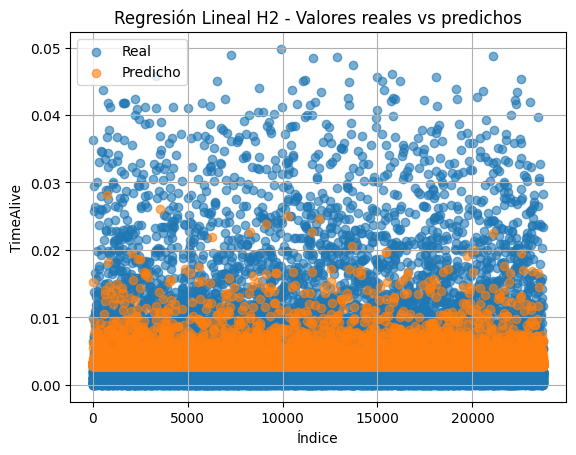


Optimizando SVR H2 con GridSearch...
Mejores parámetros para SVR H2: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}
Mejor score (R2) en validación cruzada: -1300.03%

SVR H2:
R squared on training set: -1300.44%
R squared on test set: -1296.10%


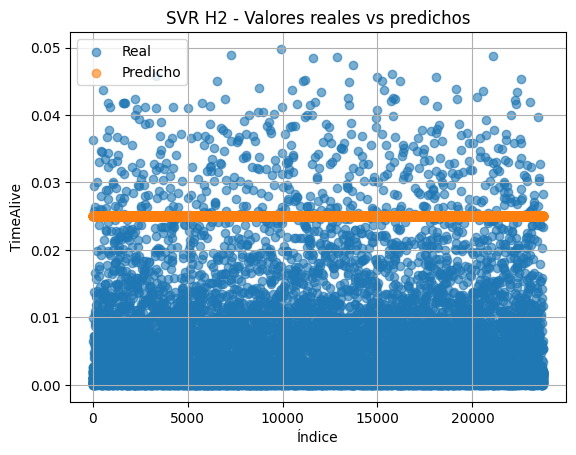


Optimizando Árbol de Decisión H2 con GridSearch...
Mejores parámetros para Árbol de Decisión H2: {'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_split': 2}
Mejor score (R2) en validación cruzada: 26.27%

Árbol de Decisión H2:
R squared on training set: 27.06%
R squared on test set: 26.25%


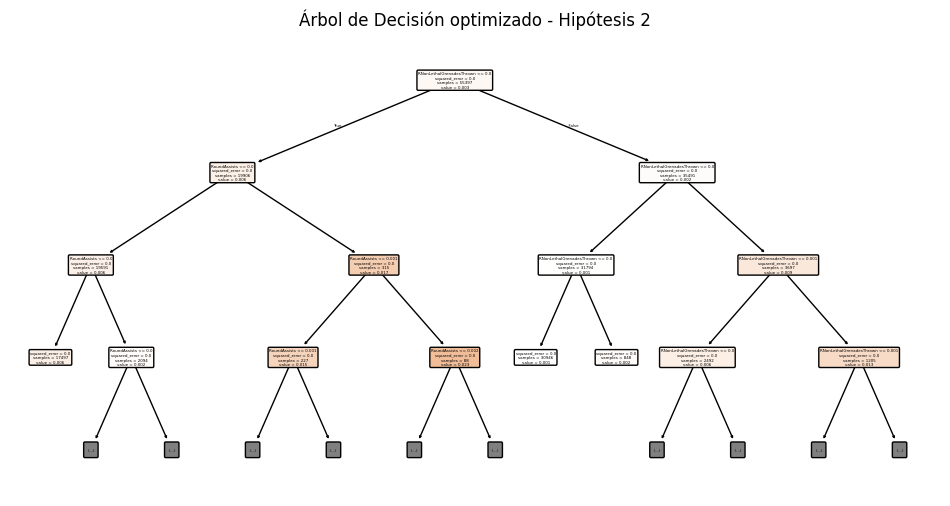


Resumen de métricas para modelos básicos (Hipótesis 2):
                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal H2   0.003395  0.000034  0.005799   0.061160   0.053876
SVR H2                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión H2  0.002748  0.000026  0.005140   0.262527   0.270616

=== RANDOM FOREST REGRESSOR - HIPÓTESIS 2 ===
Best score:  0.2663359893344955
Best params:  {'max_leaf_nodes': 15, 'min_samples_split': 2, 'n_estimators': 100}
MSE:  2.6421020377855924e-05
MAE:  0.0027315268723988122
R^2:  0.2615211104694667

=== ADABOOST REGRESSOR - HIPÓTESIS 2 ===
Best score:  0.08119124815715595
Best params:  {'estimator__max_depth': 3, 'estimator__max_leaf_nodes': 8, 'estimator__min_samples_split': 2, 'n_estimators': 10}
MSE:  3.301872138613563e-05
MAE:  0.0034710369672985826
R^2:  0.07711252804649427

=== RESUMEN FINAL - HIPÓTESIS 2 ===
                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Li

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================
# DATOS PARA HIPÓTESIS 2 (REGRESIÓN)
# ==============================================
X = df_normalizado[["RNonLethalGrenadesThrown", "RoundAssists"]]
y = df_normalizado["TimeAlive"]

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==============================================
# MODELOS BÁSICOS DE REGRESIÓN CON GRID SEARCH
# ==============================================
print("\n=== MODELOS BÁSICOS DE REGRESIÓN - HIPÓTESIS 2 ===")

modelos_basicos_h2 = {
    "Regresión Lineal H2": LinearRegression(),
    "SVR H2": SVR(),
    "Árbol de Decisión H2": DecisionTreeRegressor(random_state=42)
}

# Parámetros para GridSearch
params_basicos_h2 = {
    "SVR H2": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'epsilon': [0.1, 0.2]
    },
    "Árbol de Decisión H2": {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'max_leaf_nodes': [5, 10, 20]
    }
}

resultados_h2 = {}

for nombre, modelo in modelos_basicos_h2.items():
    if nombre in params_basicos_h2:
        print(f"\nOptimizando {nombre} con GridSearch...")
        grid = GridSearchCV(estimator=modelo, param_grid=params_basicos_h2[nombre], cv=5)
        grid.fit(X_train, y_train)
        modelo = grid.best_estimator_

        print(f"Mejores parámetros para {nombre}: {grid.best_params_}")
        print(f"Mejor score (R2) en validación cruzada: {grid.best_score_:.2%}")
    else:
        modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_train_pred = modelo.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    resultados_h2[nombre] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2_test": r2_test,
        "R2_train": r2_train
    }

    print(f"\n{nombre}:")
    print("R squared on training set: {:.2%}".format(r2_train))
    print("R squared on test set: {:.2%}".format(r2_test))

    # Visualización
    if nombre != "Árbol de Decisión H2":
        plt.figure()
        plt.scatter(range(len(y_test)), y_test, label="Real", alpha=0.6)
        plt.scatter(range(len(y_pred)), y_pred, label="Predicho", alpha=0.6)
        plt.xlabel("Índice")
        plt.ylabel("TimeAlive")
        plt.title(f"{nombre} - Valores reales vs predichos")
        plt.legend()
        plt.grid(True)
        plt.show()

    if nombre == "Árbol de Decisión H2":
        plt.figure(figsize=(12, 6))
        plot_tree(modelo, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
        plt.title("Árbol de Decisión optimizado - Hipótesis 2")
        plt.show()

# Mostrar resultados
print("\nResumen de métricas para modelos básicos (Hipótesis 2):")
print(pd.DataFrame(resultados_h2).T)

# ==============================================
# RANDOM FOREST PARA HIPÓTESIS 2
# ==============================================
print("\n=== RANDOM FOREST REGRESSOR - HIPÓTESIS 2 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf_h2 = RandomForestRegressor(random_state=42)

params_rf_h2 = {
    "n_estimators": [100],
    "min_samples_split": [2, 3, 4],
    "max_leaf_nodes": [5, 8, 10, 15]
}

grid_rf_h2 = GridSearchCV(estimator=model_rf_h2, param_grid=params_rf_h2, cv=5)
grid_rf_h2.fit(Xtrain, Ytrain)

print("Best score: ", grid_rf_h2.best_score_)
print("Best params: ", grid_rf_h2.best_params_)

Yhat = grid_rf_h2.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados_h2["Random Forest H2"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_rf_h2.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# ADABOOST PARA HIPÓTESIS 2
# ==============================================
print("\n=== ADABOOST REGRESSOR - HIPÓTESIS 2 ===")

base_estimator_h2 = DecisionTreeRegressor(random_state=42)
model_ada_h2 = AdaBoostRegressor(base_estimator_h2, random_state=42)

params_ada_h2 = {
    "n_estimators": [10, 50],
    "estimator__max_depth": [2, 3],
    "estimator__max_leaf_nodes": [5, 8],
    "estimator__min_samples_split": [2, 3, 4]
}

grid_ada_h2 = GridSearchCV(estimator=model_ada_h2, param_grid=params_ada_h2, cv=5)
grid_ada_h2.fit(Xtrain, Ytrain)

print("Best score: ", grid_ada_h2.best_score_)
print("Best params: ", grid_ada_h2.best_params_)

Yhat = grid_ada_h2.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados_h2["AdaBoost H2"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_ada_h2.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# RESUMEN FINAL HIPÓTESIS 2
# ==============================================
print("\n=== RESUMEN FINAL - HIPÓTESIS 2 ===")
resultados_df_h2 = pd.DataFrame(resultados_h2).T
print(resultados_df_h2)

- **Regresión Lineal H2:**
    - **R-cuadrado (R2) en entrenamiento:** 5.39%
    - **R-cuadrado (R2) en prueba:** 6.12%
    - **Gráfico de comparación:** Muestra que las predicciones (puntos anaranjados) de la regresión lineal son una línea casi plana. Aunque hay alguna variación, **las predicciones están muy lejos de seguir el patrón de los valores reales** (puntos azules). Los valores de R2, que son muy bajos (alrededor del 6%), confirman que este modelo explica muy poca de la variabilidad en `TimeAlive` usando estas dos variables.
- **SVR H2 (Support Vector Regressor):**
    - **Mejores parámetros encontrados:** C=0.1, épsilon=0.2, kernel='linear'.
    - **Mejor R2 en validación cruzada:** -1300.03% (muy negativo).
    - **R-cuadrado (R2) en entrenamiento y prueba:** -1300.44% y -1296.10% respectivamente.
    - **Gráfico de comparación:** Al igual que en la Hipótesis 1, las predicciones (puntos anaranjados) son una **línea horizontal constante**. Un R2 tan negativo indica que este modelo es **completamente ineficaz** para predecir `TimeAlive` con estas variables. Es peor que simplemente predecir el promedio de `TimeAlive`.
- **Árbol de Decisión H2:**
    - **Mejores parámetros encontrados:** max_depth=7, max_leaf_nodes=20, min_samples_split=2.
    - **Mejor R2 en validación cruzada:** 26.27%.
    - **R-cuadrado (R2) en entrenamiento:** 27.06%
    - **R-cuadrado (R2) en prueba:** 26.25%
    - **Análisis:** Este modelo muestra un R2 de aproximadamente 26%, lo que indica que es capaz de explicar un cuarto de la variabilidad de `TimeAlive` con las nuevas variables. Es notablemente mejor que la Regresión Lineal y SVR, y muestra una consistencia entre el rendimiento de entrenamiento y prueba, lo que es positivo.
- **Random Forest Regressor H2:**
    - **Mejores parámetros encontrados:** max_leaf_nodes=15, min_samples_split=2, n_estimators=100.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** 26.33%.
    - **R-cuadrado (R2) en prueba:** 26.15%.
    - **Análisis:** El Random Forest obtuvo un R2 muy similar al del Árbol de Decisión optimizado (alrededor del 26%). Esto refuerza la idea de que los modelos basados en árboles tienen un rendimiento similar con estas variables, siendo los más capaces de capturar alguna relación.
- **AdaBoost Regressor H2:**
    - **Mejores parámetros encontrados:** estimator__max_depth=3, estimator__max_leaf_nodes=8, estimator__min_samples_split=2, n_estimators=10.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** 8.07%.
    - **R-cuadrado (R2) en prueba:** 7.73%.
    - **Análisis:** AdaBoost tuvo un rendimiento muy bajo (aproximadamente 8% de R2), siendo el segundo peor modelo después de SVR. Esto sugiere que para estas variables específicas, la forma en que AdaBoost combina los estimadores no es efectiva para mejorar la predicción significativamente.}


En general, la capacidad predictiva de los modelos para `TimeAlive` usando `RNonLethalGrenadesThrown` y `RoundAssists` (Hipótesis 2) es **considerablemente menor** que cuando se usaban `TravelledDistance` y `RoundKills` (Hipótesis 1).
- En H1, los mejores R2 de prueba estaban en el rango del 50-54%.
- En H2, los mejores R2 de prueba están en el rango del 26%.
En la Hipótesis 2, los modelos basados en árboles (Árbol de Decisión y Random Forest) siguen siendo los que obtienen los mejores resultados, aunque su R2 es significativamente más bajo que en la Hipótesis 1.

En resumen, las variables **`RNonLethalGrenadesThrown` y `RoundAssists` tienen una capacidad mucho menor para predecir `TimeAlive`** que las variables de la primera hipótesis. Si el objetivo es predecir `TimeAlive` de manera efectiva, las variables de la Hipótesis 1 (`TravelledDistance`, `RoundKills`) son significativamente mejores predictores.

####**Hipótesis 3 (Regresión):**
Para la Hipótesis 3, el objetivo es predecir TimeAlive (Tiempo de Vida) utilizando las variables: RoundStartingEquipmentValue (Valor del Equipamiento al Inicio de la Ronda), PrimarySniperRifle (Arma Primaria: Rifle de Francotirador) y PrimaryHeavy (Arma Primaria: Pesada). Se empleó la misma metodología de evaluación y optimización de modelos que en las hipótesis anteriores.

Variables predictoras (X) para H3:


=== MODELOS BÁSICOS DE REGRESIÓN - HIPÓTESIS 3 ===

Regresión Lineal H3:
R squared on training set: 0.82%
R squared on test set: 0.22%


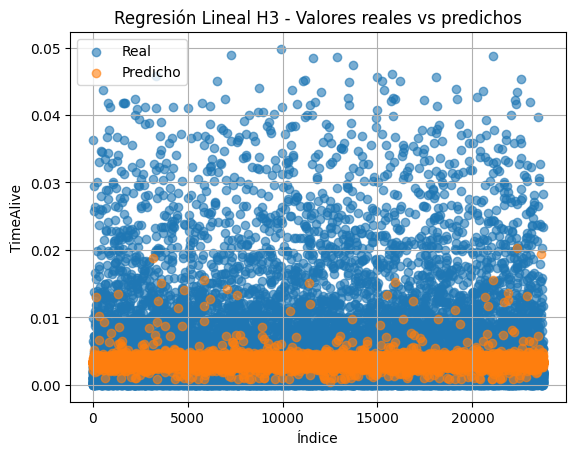


Optimizando SVR H3 con GridSearch...
Mejores parámetros para SVR H3: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}
Mejor score (R2) en validación cruzada: -1300.03%

SVR H3:
R squared on training set: -1300.44%
R squared on test set: -1296.10%


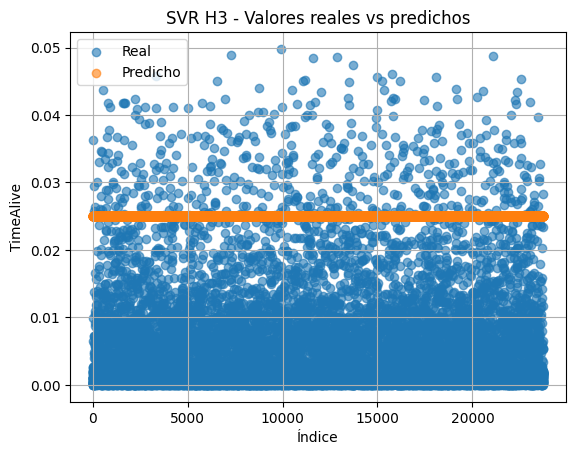


Optimizando Árbol de Decisión H3 con GridSearch...
Mejores parámetros para Árbol de Decisión H3: {'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_split': 2}
Mejor score (R2) en validación cruzada: 12.44%

Árbol de Decisión H3:
R squared on training set: 13.33%
R squared on test set: 12.50%


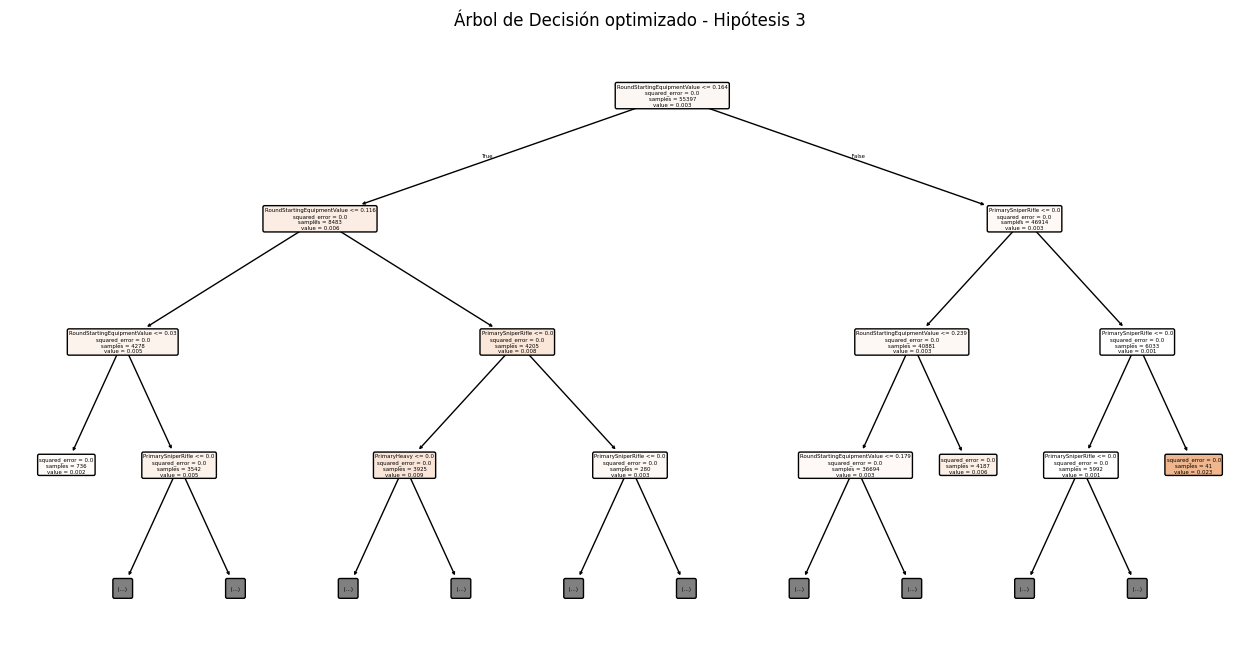


Resumen de métricas para modelos básicos (Hipótesis 3):
                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal H3   0.003620  0.000036  0.005979   0.002235   0.008248
SVR H3                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión H3  0.003139  0.000031  0.005599   0.125032   0.133264

=== RANDOM FOREST REGRESSOR - HIPÓTESIS 3 ===
Best score:  0.12549401100994068
Best params:  {'max_leaf_nodes': 15, 'min_samples_split': 2, 'n_estimators': 200}
MSE:  3.153953132127122e-05
MAE:  0.003154505267765797
R^2:  0.1184565269111707

=== ADABOOST REGRESSOR - HIPÓTESIS 3 ===
Best score:  -0.06465331376774061
Best params:  {'estimator__max_depth': 4, 'estimator__max_leaf_nodes': 5, 'estimator__min_samples_split': 2, 'n_estimators': 10}
MSE:  4.02244831513386e-05
MAE:  0.004859234545727253
R^2:  -0.12429161420414236

=== RESUMEN FINAL - HIPÓTESIS 3 ===
                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Lin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================
# DATOS PARA HIPÓTESIS 3 (REGRESIÓN)
# ==============================================
X = df_normalizado[["RoundStartingEquipmentValue", "PrimarySniperRifle", "PrimaryHeavy"]]
y = df_normalizado["TimeAlive"]

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==============================================
# MODELOS BÁSICOS DE REGRESIÓN CON GRID SEARCH
# ==============================================
print("\n=== MODELOS BÁSICOS DE REGRESIÓN - HIPÓTESIS 3 ===")

modelos_basicos_h3 = {
    "Regresión Lineal H3": LinearRegression(),
    "SVR H3": SVR(),
    "Árbol de Decisión H3": DecisionTreeRegressor(random_state=42)
}

# Parámetros para GridSearch
params_basicos_h3 = {
    "SVR H3": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'epsilon': [0.1, 0.2]
    },
    "Árbol de Decisión H3": {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'max_leaf_nodes': [5, 10, 20]
    }
}

resultados_h3 = {}

for nombre, modelo in modelos_basicos_h3.items():
    if nombre in params_basicos_h3:
        print(f"\nOptimizando {nombre} con GridSearch...")
        grid = GridSearchCV(estimator=modelo, param_grid=params_basicos_h3[nombre], cv=5)
        grid.fit(X_train, y_train)
        modelo = grid.best_estimator_

        print(f"Mejores parámetros para {nombre}: {grid.best_params_}")
        print(f"Mejor score (R2) en validación cruzada: {grid.best_score_:.2%}")
    else:
        modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_train_pred = modelo.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    resultados_h3[nombre] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2_test": r2_test,
        "R2_train": r2_train
    }

    print(f"\n{nombre}:")
    print("R squared on training set: {:.2%}".format(r2_train))
    print("R squared on test set: {:.2%}".format(r2_test))

    # Visualización
    if nombre != "Árbol de Decisión H3":
        plt.figure()
        plt.scatter(range(len(y_test)), y_test, label="Real", alpha=0.6)
        plt.scatter(range(len(y_pred)), y_pred, label="Predicho", alpha=0.6)
        plt.xlabel("Índice")
        plt.ylabel("TimeAlive")
        plt.title(f"{nombre} - Valores reales vs predichos")
        plt.legend()
        plt.grid(True)
        plt.show()

    if nombre == "Árbol de Decisión H3":
        plt.figure(figsize=(16, 8))  # Aumentado el tamaño por tener más features
        plot_tree(modelo, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
        plt.title("Árbol de Decisión optimizado - Hipótesis 3")
        plt.show()

# Mostrar resultados
print("\nResumen de métricas para modelos básicos (Hipótesis 3):")
print(pd.DataFrame(resultados_h3).T)

# ==============================================
# RANDOM FOREST PARA HIPÓTESIS 3
# ==============================================
print("\n=== RANDOM FOREST REGRESSOR - HIPÓTESIS 3 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf_h3 = RandomForestRegressor(random_state=42)

params_rf_h3 = {
    "n_estimators": [100, 200],
    "min_samples_split": [2, 3, 4],
    "max_leaf_nodes": [5, 8, 10, 15]
}

grid_rf_h3 = GridSearchCV(estimator=model_rf_h3, param_grid=params_rf_h3, cv=5)
grid_rf_h3.fit(Xtrain, Ytrain)

print("Best score: ", grid_rf_h3.best_score_)
print("Best params: ", grid_rf_h3.best_params_)

Yhat = grid_rf_h3.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados_h3["Random Forest H3"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_rf_h3.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# ADABOOST PARA HIPÓTESIS 3
# ==============================================
print("\n=== ADABOOST REGRESSOR - HIPÓTESIS 3 ===")

base_estimator_h3 = DecisionTreeRegressor(random_state=42)
model_ada_h3 = AdaBoostRegressor(base_estimator_h3, random_state=42)

params_ada_h3 = {
    "n_estimators": [10, 50, 100],
    "estimator__max_depth": [2, 3, 4],
    "estimator__max_leaf_nodes": [5, 8, 10],
    "estimator__min_samples_split": [2, 3, 4]
}

grid_ada_h3 = GridSearchCV(estimator=model_ada_h3, param_grid=params_ada_h3, cv=5)
grid_ada_h3.fit(Xtrain, Ytrain)

print("Best score: ", grid_ada_h3.best_score_)
print("Best params: ", grid_ada_h3.best_params_)

Yhat = grid_ada_h3.predict(Xtest)

mse = mean_squared_error(Ytest, Yhat)
mae = mean_absolute_error(Ytest, Yhat)
R2 = r2_score(Ytest, Yhat)

resultados_h3["AdaBoost H3"] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2_test": R2,
    "R2_train": grid_ada_h3.best_score_
}

print("MSE: ", mse)
print("MAE: ", mae)
print("R^2: ", R2)

# ==============================================
# RESUMEN FINAL HIPÓTESIS 3
# ==============================================
print("\n=== RESUMEN FINAL - HIPÓTESIS 3 ===")
resultados_df_h3 = pd.DataFrame(resultados_h3).T
print(resultados_df_h3)

- **Regresión Lineal H3:**
    - **R-cuadrado (R2) en entrenamiento:** 0.82%
    - **R-cuadrado (R2) en prueba:** 0.22%
    - **Gráfico de comparación:** Muestra que las predicciones (puntos anaranjados) de la regresión lineal son una línea casi plana, y además, están muy concentradas en un valor muy bajo, muy lejos de la distribución de los valores reales (puntos azules). Los valores de R2 son extremadamente bajos (cercanos a 0%), lo que indica que este modelo es **prácticamente inútil** para predecir `TimeAlive` usando estas variables. Explica menos del 1% de la variabilidad.
- **SVR H3 (Support Vector Regressor):**
    - **Mejores parámetros encontrados:** C=0.1, épsilon=0.2, kernel='linear'.
    - **Mejor R2 en validación cruzada:** -1300.03% (muy negativo).
    - **R-cuadrado (R2) en entrenamiento y prueba:** -1300.44% y -1296.10% respectivamente.
    - **Gráfico de comparación:** Una vez más, las predicciones (puntos anaranjados) son una **línea horizontal constante**. El R2 tan extremadamente negativo confirma que este modelo **no ha aprendido absolutamente nada** y es peor que una predicción aleatoria o la media de los datos.
- **Árbol de Decisión H3:**
    - **Mejores parámetros encontrados:** max_depth=7, max_leaf_nodes=20, min_samples_split=2.
    - **Mejor R2 en validación cruzada:** 12.44%.
    - **R-cuadrado (R2) en entrenamiento:** 13.33%
    - **R-cuadrado (R2) en prueba:** 12.50%
    - **Análisis:** Este modelo es el que muestra un rendimiento relativamente "mejor" entre los modelos básicos, con un R2 de alrededor del 12-13%. Aunque es bajo en términos absolutos, demuestra que las variables de equipamiento y tipo de arma tienen una relación débil, pero existente, con `TimeAlive`, que los modelos de árboles pueden capturar mejor que los lineales. La cercanía entre el R2 de entrenamiento y prueba indica que no hay un sobreajuste significativo.
- **Random Forest Regressor H3:**
    - **Mejores parámetros encontrados:** max_leaf_nodes=15, min_samples_split=2, n_estimators=200.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** 12.55%.
    - **R-cuadrado (R2) en prueba:** 11.85%.
    - **Análisis:** El Random Forest obtiene un R2 de prueba muy similar al del Árbol de Decisión optimizado (alrededor del 12%). A pesar de probar un mayor número de estimadores, el rendimiento no mejora sustancialmente, lo que sugiere que las variables predictoras en sí mismas no tienen una fuerte relación con `TimeAlive`.
- **AdaBoost Regressor H3:**
    - **Mejores parámetros encontrados:** estimator__max_depth=4, estimator__max_leaf_nodes=5, estimator__min_samples_split=2, n_estimators=10.
    - **Mejor R2 en validación cruzada (y R2 de entrenamiento):** -0.06%.
    - **R-cuadrado (R2) en prueba:** -0.11%.
    - **Análisis:** AdaBoost aquí muestra un R2 negativo, lo que significa que su rendimiento es peor que simplemente predecir la media. A pesar de la ampliación en los rangos de optimización, no logró encontrar una configuración que generara un modelo útil con estas variables. Es ligeramente mejor que SVR, pero sigue siendo un modelo ineficaz.


La Hipótesis 3, que utiliza el valor de equipamiento y el tipo de arma principal, muestra el **rendimiento predictivo más bajo de las tres hipótesis**. Los R2 más altos (alrededor del 12-13%) son significativamente inferiores a los de la Hipótesis 1 (50-54%) y también por debajo de los de la Hipótesis 2 (26%).

El SVR se mantiene como un modelo no funcional para este problema de predicción con los parámetros explorados.

 En esta hipótesis, los modelos basados en árboles (Árbol de Decisión y Random Forest) son los únicos que muestran una capacidad predictiva positiva, aunque muy limitada.

En resumen, las variables **`RoundStartingEquipmentValue`, `PrimarySniperRifle` y `PrimaryHeavy` son predictores muy débiles de `TimeAlive`**. Si bien los modelos de árboles lograron encontrar una pequeña relación, estas variables por sí solas no son suficientes para construir un modelo de regresión robusto para predecir el tiempo de vida.

## Modelos de Clasificación

####**Hipótesis 1 (Clasificación):**
El objetivo es predecir la variable categórica RoundWinner (Ganador de la Ronda), utilizando las variables numéricas RoundKills (Muertes en la ronda) y RoundHeadshots (Disparos a la cabeza en la ronda)

Variables predictoras (X) para H1:


=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 1 ===

Modelo: Regresión Logística H1
              precision    recall  f1-score   support

           0       0.50      0.05      0.09      6959
           1       0.71      0.98      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.60      0.51      0.46     23747
weighted avg       0.65      0.71      0.61     23747



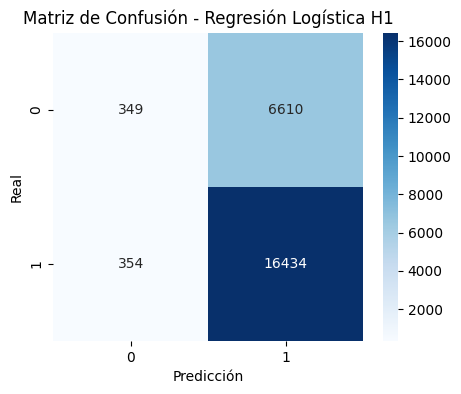


Modelo: SVM H1
              precision    recall  f1-score   support

           0       0.56      0.02      0.04      6959
           1       0.71      0.99      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.63      0.51      0.44     23747
weighted avg       0.67      0.71      0.60     23747



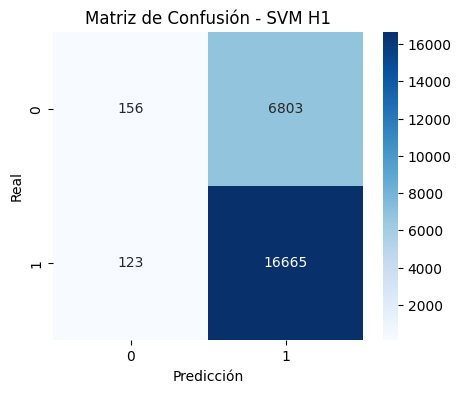


Modelo: Árbol de Decisión H1
              precision    recall  f1-score   support

           0       0.56      0.01      0.01      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.63      0.50      0.42     23747
weighted avg       0.66      0.71      0.59     23747



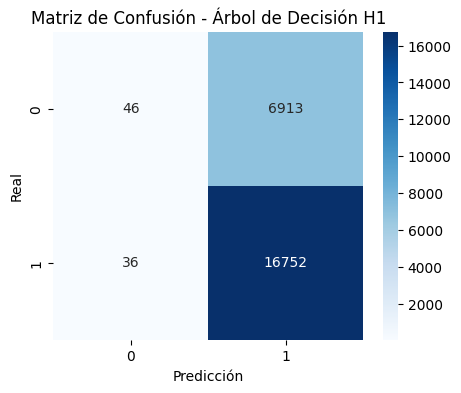

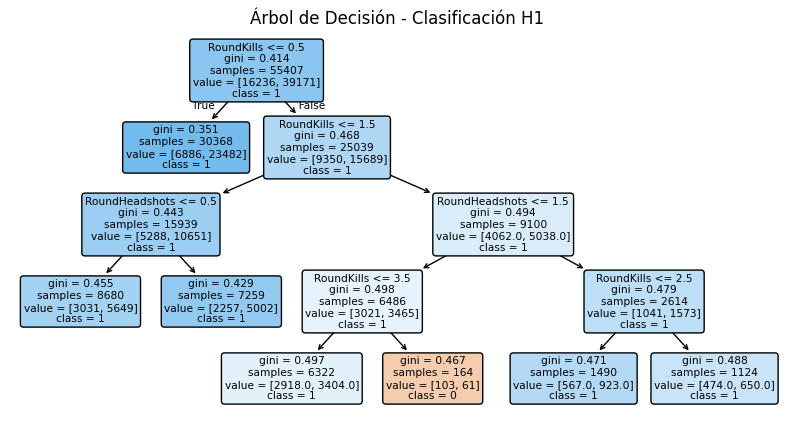


=== K-NEAREST NEIGHBORS - HIPÓTESIS 1 ===
Accuracy (train): 65.08%
Accuracy (test): 65.17%
              precision    recall  f1-score   support

           0       0.40      0.38      0.39      6959
           1       0.75      0.77      0.76     16788

    accuracy                           0.65     23747
   macro avg       0.57      0.57      0.57     23747
weighted avg       0.65      0.65      0.65     23747



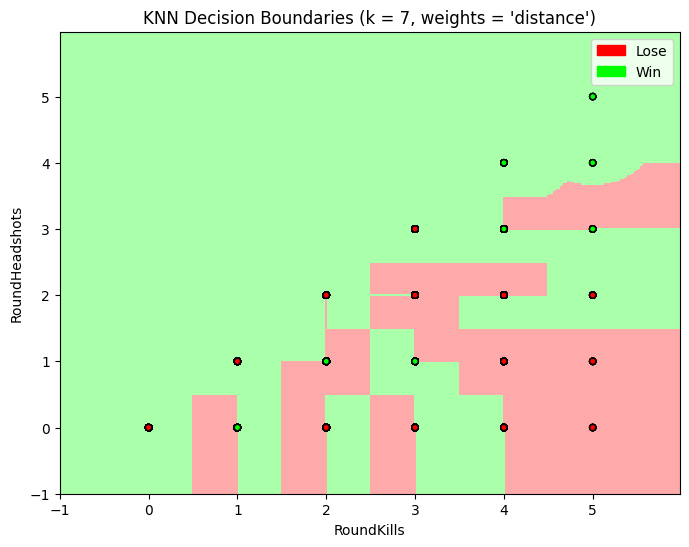


=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 1 ===
Best score:  0.7072153885826483
Best params:  {'max_depth': 3, 'max_leaf_nodes': 8, 'min_samples_split': 2, 'n_estimators': 10}
[[    0  4639]
 [    0 11192]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg       0.35      0.50      0.41     15831
weighted avg       0.50      0.71      0.59     15831


=== ADABOOST CLASSIFIER - HIPÓTESIS 1 ===
Best score:  0.7079891858298009
Best params:  {'estimator__max_depth': 2, 'estimator__max_leaf_nodes': 5, 'estimator__min_samples_split': 2, 'n_estimators': 50}
[[   24  4615]
 [   25 11167]]
              precision    recall  f1-score   support

           0       0.49      0.01      0.01      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg 

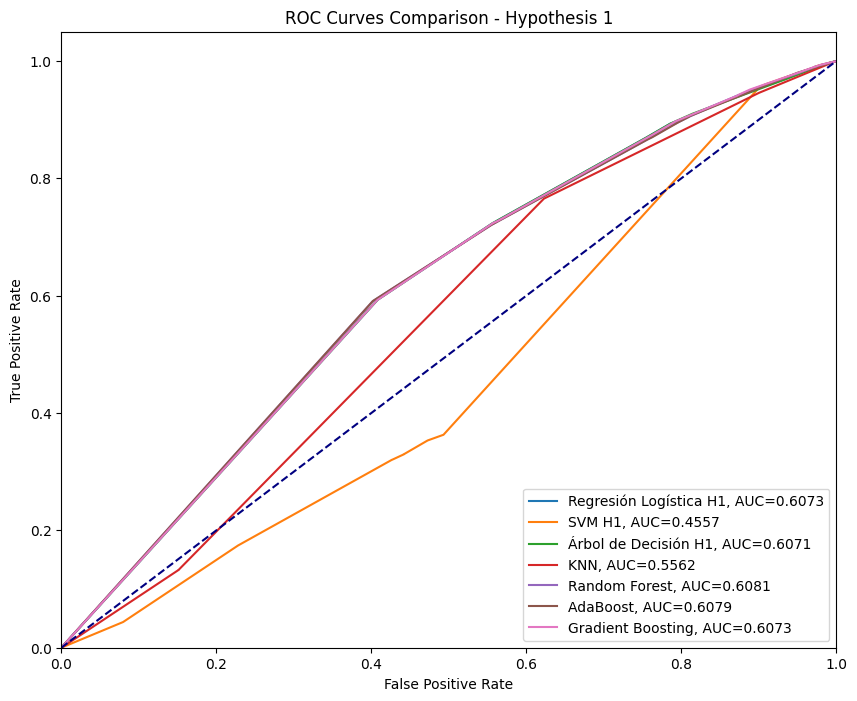


=== RESUMEN COMPARATIVO - CLASIFICACIÓN H1 ===
                        Accuracy  F1 Score
Regresión Logística H1    0.7067    0.6100
SVM H1                    0.7083    0.5980
Árbol de Decisión H1      0.7074    0.5893
KNN H1                    0.6517    0.6486
Random Forest H1          0.7070    0.5856
AdaBoost H1               0.7069    0.5884
Gradient Boosting H1      0.7080    0.6001


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (RandomForestClassifier,
                            AdaBoostClassifier,
                            GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                           classification_report,
                           confusion_matrix,
                           roc_curve, roc_auc_score)
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics

# ==============================================
# DATOS PARA HIPÓTESIS 1 (CLASIFICACIÓN)
# ==============================================
X = df_var_num2[["RoundKills", "RoundHeadshots"]].values
y = df_var_num2["RoundWinner"].astype(int).values

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================================
# MODELOS BÁSICOS DE CLASIFICACIÓN
# ==============================================
print("\n=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 1 ===")

modelos_clf_h1 = {
    "Regresión Logística H1": LogisticRegression(max_iter=1000, random_state=42),
    "SVM H1": SVC(probability=True, random_state=42),
    "Árbol de Decisión H1": DecisionTreeClassifier(max_depth=4, random_state=42)
}

resumen_clf_h1 = {}
roc_curves = []

for nombre, modelo in modelos_clf_h1.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else [0]*len(y_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resumen_clf_h1[nombre] = {
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    }

    print(f"\nModelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Visualizar árbol si aplica
    if nombre == "Árbol de Decisión H1":
        plt.figure(figsize=(10, 5))
        plot_tree(modelo, feature_names=["RoundKills", "RoundHeadshots"],
                 class_names=["0", "1"],
                 filled=True, rounded=True)
        plt.title("Árbol de Decisión - Clasificación H1")
        plt.show()

    # ROC Curve data
    if hasattr(modelo, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        roc_curves.append((fpr, tpr, f"{nombre}, AUC={auc}"))

# ==============================================
# KNN CON VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
# ==============================================
print("\n=== K-NEAREST NEIGHBORS - HIPÓTESIS 1 ===")

h = .02  # step size in the mesh
n_neighbors = 7

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Train KNN
knn_h1 = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn_h1.fit(X_train, y_train)

# Predictions
y_pred = knn_h1.predict(X_test)
y_proba = knn_h1.predict_proba(X_test)[:, 1]

# Metrics
resumen_clf_h1["KNN H1"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print('Accuracy (train): {:.2%}'.format(knn_h1.score(X_train, y_train)))
print('Accuracy (test): {:.2%}'.format(knn_h1.score(X_test, y_test)))
print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"KNN, AUC={auc}"))

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Z = knn_h1.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
           edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Create legend
patch0 = mpatches.Patch(color='#FF0000', label='Lose')
patch1 = mpatches.Patch(color='#00FF00', label='Win')
plt.legend(handles=[patch0, patch1])

plt.title(f"KNN Decision Boundaries (k = {n_neighbors}, weights = 'distance')")
plt.xlabel("RoundKills")
plt.ylabel("RoundHeadshots")
plt.show()

# ==============================================
# RANDOM FOREST CON GRID SEARCH
# ==============================================
print("\n=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 1 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_rf_h1 = RandomForestClassifier(random_state=42)

params_rf_h1 = {
    "n_estimators": [10, 50],
    "max_depth": [2, 3],
    "min_samples_split": [2, 3, 4],
    "max_leaf_nodes": [5, 8]
}

grid_rf_h1 = GridSearchCV(model_rf_h1, params_rf_h1, cv=5)
grid_rf_h1.fit(Xtrain, Ytrain)

print("Best score: ", grid_rf_h1.best_score_)
print("Best params: ", grid_rf_h1.best_params_)

Yhat = grid_rf_h1.predict(Xtest)
Y_proba = grid_rf_h1.predict_proba(Xtest)[:, 1]

resumen_clf_h1["Random Forest H1"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"Random Forest, AUC={auc}"))

# ==============================================
# ADABOOST CON GRID SEARCH
# ==============================================
print("\n=== ADABOOST CLASSIFIER - HIPÓTESIS 1 ===")

base_est_h1 = DecisionTreeClassifier(random_state=42)
model_ada_h1 = AdaBoostClassifier(base_est_h1, random_state=42)

params_ada_h1 = {
    "n_estimators": [10, 50],
    "estimator__max_depth": [2, 3],
    "estimator__min_samples_split": [2, 3, 4],
    "estimator__max_leaf_nodes": [5, 8]
}

grid_ada_h1 = GridSearchCV(model_ada_h1, params_ada_h1, cv=5)
grid_ada_h1.fit(Xtrain, Ytrain)

print("Best score: ", grid_ada_h1.best_score_)
print("Best params: ", grid_ada_h1.best_params_)

Yhat = grid_ada_h1.predict(Xtest)
Y_proba = grid_ada_h1.predict_proba(Xtest)[:, 1]

resumen_clf_h1["AdaBoost H1"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"AdaBoost, AUC={auc}"))

# ==============================================
# GRADIENT BOOSTING
# ==============================================
print("\n=== GRADIENT BOOSTING - HIPÓTESIS 1 ===")

gb_h1 = GradientBoostingClassifier(random_state=42)
gb_h1.fit(X_train, y_train)

y_pred = gb_h1.predict(X_test)
y_proba = gb_h1.predict_proba(X_test)[:, 1]

resumen_clf_h1["Gradient Boosting H1"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"Gradient Boosting, AUC={auc}"))

# ==============================================
# CURVAS ROC COMPARATIVAS
# ==============================================
plt.figure(figsize=(10, 8))
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, label=label)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - Hypothesis 1')
plt.legend(loc="lower right")
plt.show()

# ==============================================
# RESUMEN FINAL
# ==============================================
print("\n=== RESUMEN COMPARATIVO - CLASIFICACIÓN H1 ===")
resultados_clf_df_h1 = pd.DataFrame(resumen_clf_h1).T
print(resultados_clf_df_h1)

####**Hipótesis 2 (Clasificación):**
Aqui pones en que consiste

Variables predictoras (X) para H2:


=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 2 ===

Modelo: Regresión Logística H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



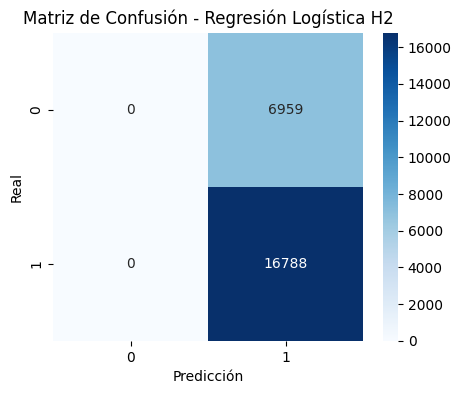


Modelo: SVM H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



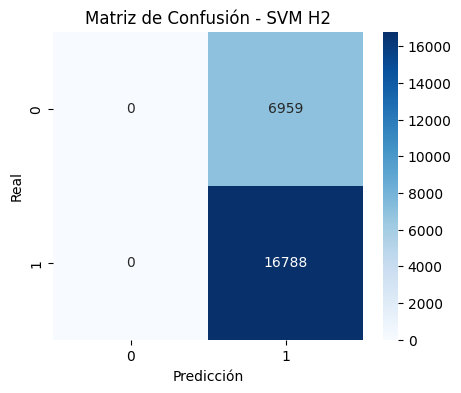


Modelo: Árbol de Decisión H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



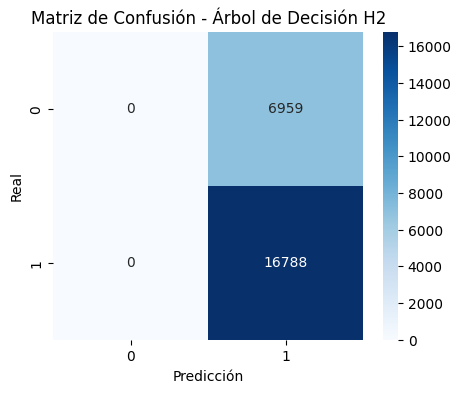

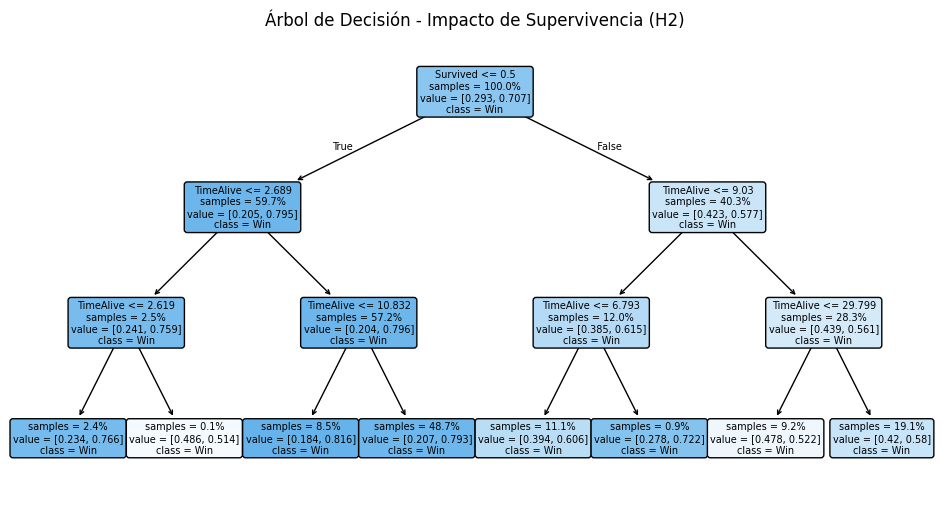


=== K-NEAREST NEIGHBORS - HIPÓTESIS 2 ===
Accuracy (train): 94.20%
Accuracy (test): 77.26%
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      6959
           1       0.82      0.86      0.84     16788

    accuracy                           0.77     23747
   macro avg       0.73      0.71      0.72     23747
weighted avg       0.77      0.77      0.77     23747



C:\Users\Elias\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


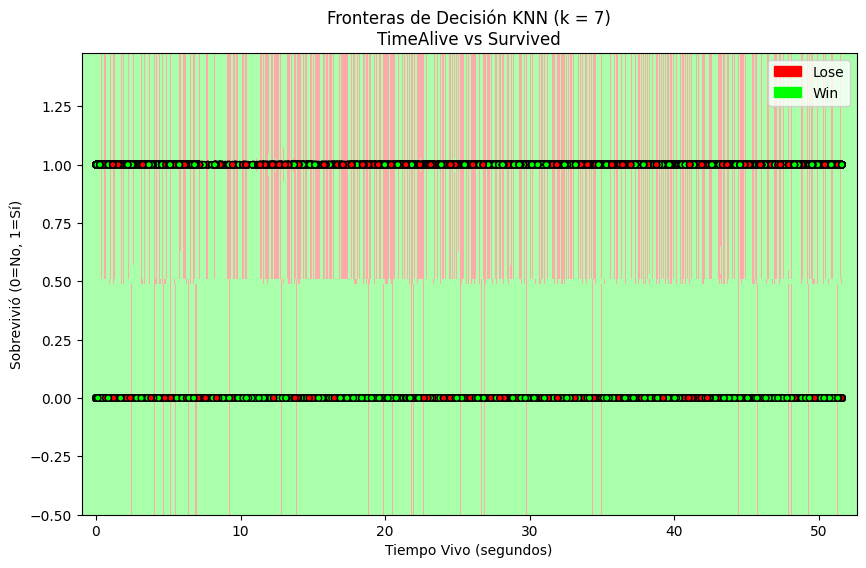


=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 2 ===
Best score (AUC):  0.6410228113194452
Best params:  {'max_depth': 4, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
[[   55  4584]
 [   47 11145]]
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg       0.62      0.50      0.43     15831
weighted avg       0.66      0.71      0.59     15831



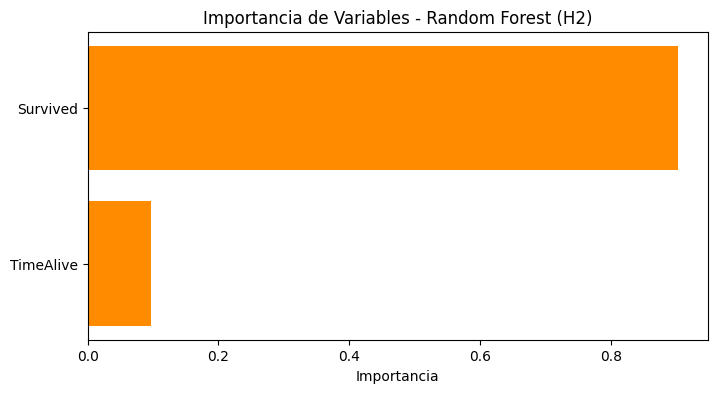


=== ADABOOST CLASSIFIER - HIPÓTESIS 2 ===
Best score (AUC):  0.6363106973647106
Best params:  {'learning_rate': 0.5, 'n_estimators': 100}
[[  514  4125]
 [  583 10609]]
              precision    recall  f1-score   support

           0       0.47      0.11      0.18      4639
           1       0.72      0.95      0.82     11192

    accuracy                           0.70     15831
   macro avg       0.59      0.53      0.50     15831
weighted avg       0.65      0.70      0.63     15831


=== GRADIENT BOOSTING - HIPÓTESIS 2 ===
              precision    recall  f1-score   support

           0       0.55      0.00      0.01      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.63      0.50      0.42     23747
weighted avg       0.66      0.71      0.59     23747



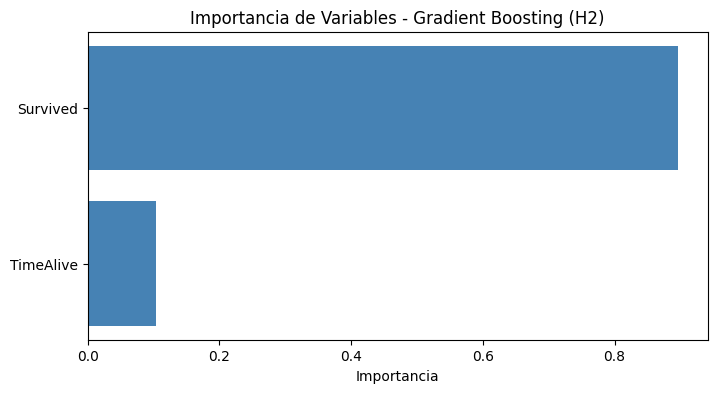

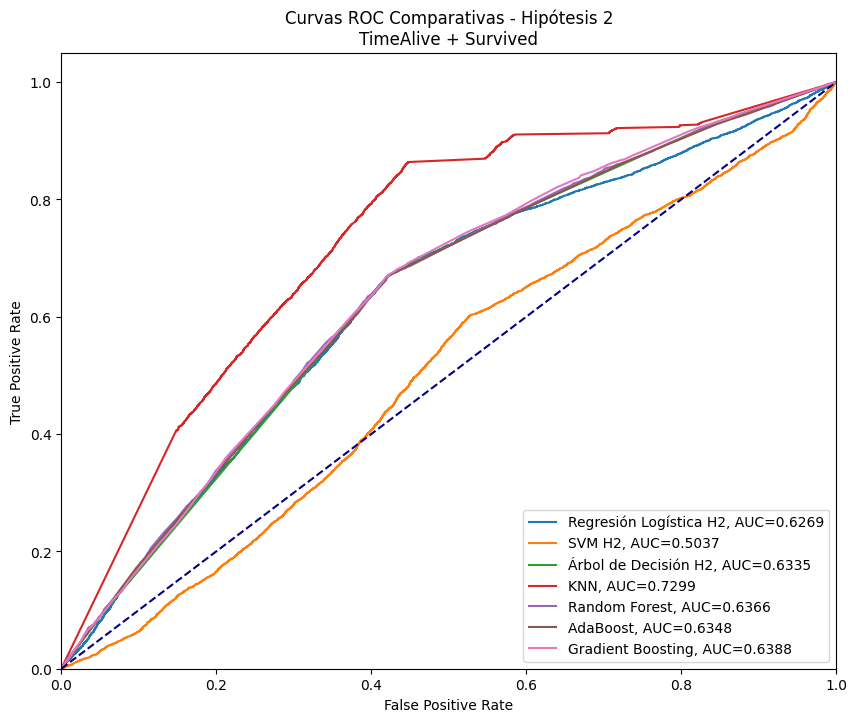


=== RESUMEN COMPARATIVO - CLASIFICACIÓN H2 ===
                        Accuracy  F1 Score     AUC
Random Forest H2          0.7075    0.5922  0.6410
AdaBoost H2               0.7026    0.6311  0.6363
Regresión Logística H2    0.7070    0.5856     NaN
SVM H2                    0.7070    0.5856     NaN
Árbol de Decisión H2      0.7070    0.5856     NaN
KNN H2                    0.7726    0.7681     NaN
Gradient Boosting H2      0.7071    0.5875     NaN


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (RandomForestClassifier,
                            AdaBoostClassifier,
                            GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                           classification_report,
                           confusion_matrix,
                           roc_curve, roc_auc_score)
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics

# ==============================================
# DATOS PARA HIPÓTESIS 2 (CLASIFICACIÓN)
# ==============================================
X = df_var_num2[["TimeAlive", "Survived"]].values
y = df_var_num2["RoundWinner"].astype(int).values

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================================
# MODELOS BÁSICOS DE CLASIFICACIÓN
# ==============================================
print("\n=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 2 ===")

modelos_clf_h2 = {
    "Regresión Logística H2": LogisticRegression(max_iter=1000, random_state=42),
    "SVM H2": SVC(probability=True, random_state=42),
    "Árbol de Decisión H2": DecisionTreeClassifier(max_depth=3, random_state=42)  # Reducida profundidad para mejor visualización
}

resumen_clf_h2 = {}
roc_curves = []

for nombre, modelo in modelos_clf_h2.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else [0]*len(y_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resumen_clf_h2[nombre] = {
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    }

    print(f"\nModelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Visualizar árbol si aplica
    if nombre == "Árbol de Decisión H2":
        plt.figure(figsize=(12, 6))
        plot_tree(modelo,
                 feature_names=["TimeAlive", "Survived"],  # Nombres correctos de características
                 class_names=["Lose", "Win"],  # Etiquetas más descriptivas
                 filled=True,
                 rounded=True,
                 proportion=True,
                 impurity=False)
        plt.title("Árbol de Decisión - Impacto de Supervivencia (H2)")
        plt.show()

    # ROC Curve data
    if hasattr(modelo, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        roc_curves.append((fpr, tpr, f"{nombre}, AUC={auc}"))

# ==============================================
# KNN CON VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
# ==============================================
print("\n=== K-NEAREST NEIGHBORS - HIPÓTESIS 2 ===")

h = .02  # step size in the mesh
n_neighbors = 7

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Train KNN
knn_h2 = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn_h2.fit(X_train, y_train)

# Predictions
y_pred = knn_h2.predict(X_test)
y_proba = knn_h2.predict_proba(X_test)[:, 1]

# Metrics
resumen_clf_h2["KNN H2"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print('Accuracy (train): {:.2%}'.format(knn_h2.score(X_train, y_train)))
print('Accuracy (test): {:.2%}'.format(knn_h2.score(X_test, y_test)))
print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"KNN, AUC={auc}"))

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = -0.5, 1.5  # Límites para Survived (binario)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Z = knn_h2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
           edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Create legend
patch0 = mpatches.Patch(color='#FF0000', label='Lose')
patch1 = mpatches.Patch(color='#00FF00', label='Win')
plt.legend(handles=[patch0, patch1])

plt.title(f"Fronteras de Decisión KNN (k = {n_neighbors})\nTimeAlive vs Survived")
plt.xlabel("Tiempo Vivo (segundos)")
plt.ylabel("Sobrevivió (0=No, 1=Sí)")
plt.show()

# ==============================================
# RANDOM FOREST CON GRID SEARCH
# ==============================================
print("\n=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 2 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_rf_h2 = RandomForestClassifier(random_state=42)

params_rf_h2 = {
    "n_estimators": [50, 100],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5],
    "max_features": ['sqrt', None]
}

grid_rf_h2 = GridSearchCV(model_rf_h2, params_rf_h2, cv=5, scoring='roc_auc')
grid_rf_h2.fit(Xtrain, Ytrain)

print("Best score (AUC): ", grid_rf_h2.best_score_)
print("Best params: ", grid_rf_h2.best_params_)

Yhat = grid_rf_h2.predict(Xtest)
Y_proba = grid_rf_h2.predict_proba(Xtest)[:, 1]

resumen_clf_h2["Random Forest H2"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4),
    "AUC": round(grid_rf_h2.best_score_, 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# Feature Importance
importances = grid_rf_h2.best_estimator_.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(["TimeAlive", "Survived"], importances, color='darkorange')
plt.xlabel("Importancia")
plt.title("Importancia de Variables - Random Forest (H2)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"Random Forest, AUC={auc}"))

# ==============================================
# ADABOOST CON GRID SEARCH
# ==============================================
print("\n=== ADABOOST CLASSIFIER - HIPÓTESIS 2 ===")

base_est_h2 = DecisionTreeClassifier(max_depth=2, random_state=42)  # Árboles más simples
model_ada_h2 = AdaBoostClassifier(base_est_h2, random_state=42)

params_ada_h2 = {
    "n_estimators": [50, 100],
    "learning_rate": [0.5, 1.0]
}

grid_ada_h2 = GridSearchCV(model_ada_h2, params_ada_h2, cv=5, scoring='roc_auc')
grid_ada_h2.fit(Xtrain, Ytrain)

print("Best score (AUC): ", grid_ada_h2.best_score_)
print("Best params: ", grid_ada_h2.best_params_)

Yhat = grid_ada_h2.predict(Xtest)
Y_proba = grid_ada_h2.predict_proba(Xtest)[:, 1]

resumen_clf_h2["AdaBoost H2"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4),
    "AUC": round(grid_ada_h2.best_score_, 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"AdaBoost, AUC={auc}"))

# ==============================================
# GRADIENT BOOSTING
# ==============================================
print("\n=== GRADIENT BOOSTING - HIPÓTESIS 2 ===")

gb_h2 = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.1,
    random_state=42
)
gb_h2.fit(X_train, y_train)

y_pred = gb_h2.predict(X_test)
y_proba = gb_h2.predict_proba(X_test)[:, 1]

resumen_clf_h2["Gradient Boosting H2"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print(classification_report(y_test, y_pred, zero_division=0))

# Feature Importance
plt.figure(figsize=(8, 4))
plt.barh(["TimeAlive", "Survived"], gb_h2.feature_importances_, color='steelblue')
plt.xlabel("Importancia")
plt.title("Importancia de Variables - Gradient Boosting (H2)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"Gradient Boosting, AUC={auc}"))

# ==============================================
# CURVAS ROC COMPARATIVAS
# ==============================================
plt.figure(figsize=(10, 8))
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, label=label)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas - Hipótesis 2\nTimeAlive + Survived')
plt.legend(loc="lower right")
plt.show()

# ==============================================
# RESUMEN FINAL
# ==============================================
print("\n=== RESUMEN COMPARATIVO - CLASIFICACIÓN H2 ===")
resultados_clf_df_h2 = pd.DataFrame(resumen_clf_h2).T
print(resultados_clf_df_h2.sort_values(by='AUC', ascending=False))


=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 2 ===

Modelo: Regresión Logística H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



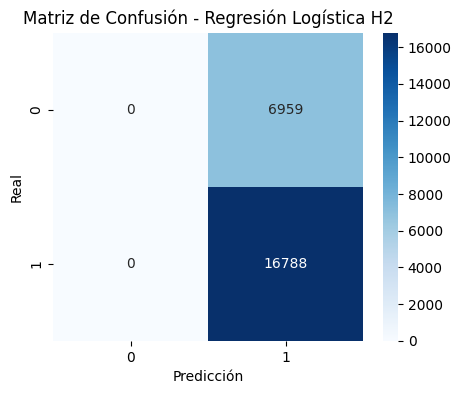


Modelo: SVM H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



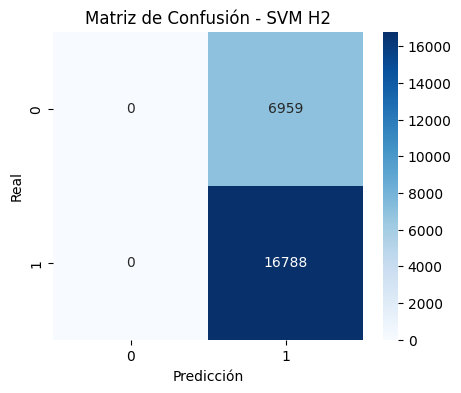


Modelo: Árbol de Decisión H2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



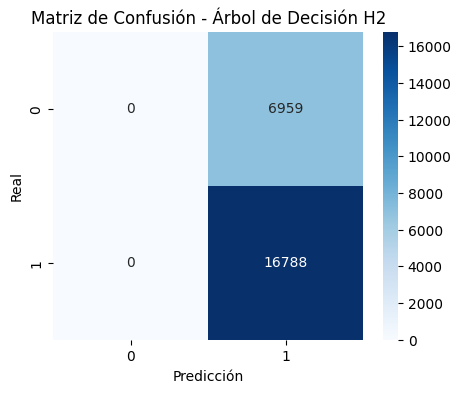

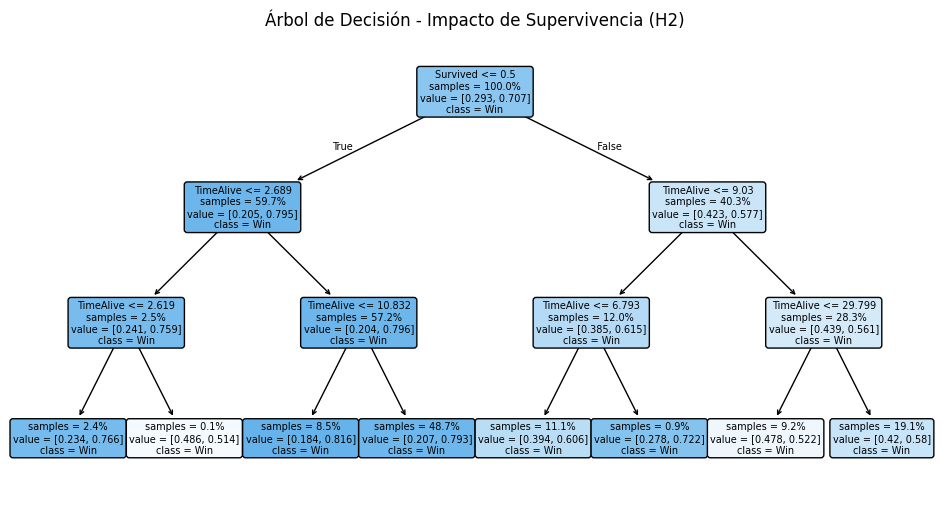


=== K-NEAREST NEIGHBORS - HIPÓTESIS 2 ===
Accuracy (train): 94.20%
Accuracy (test): 77.26%
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      6959
           1       0.82      0.86      0.84     16788

    accuracy                           0.77     23747
   macro avg       0.73      0.71      0.72     23747
weighted avg       0.77      0.77      0.77     23747



C:\Users\Elias\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


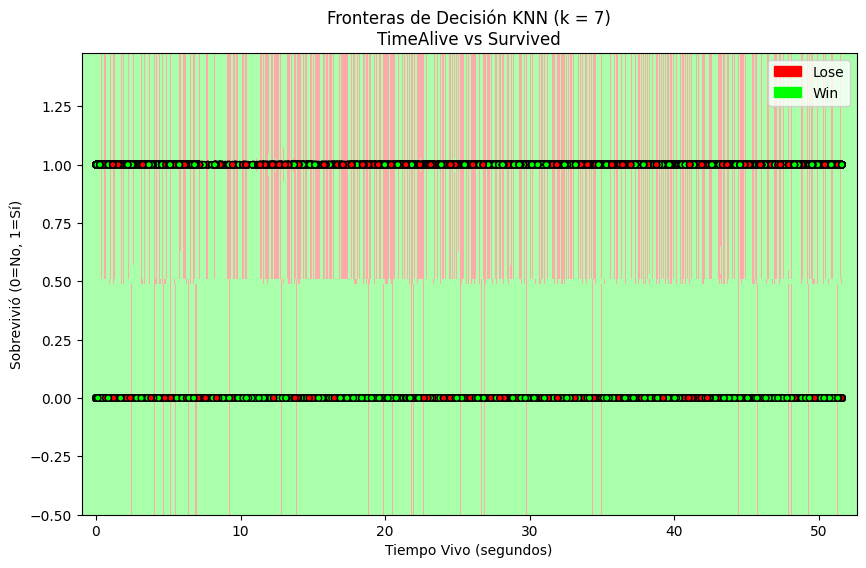


=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 2 ===
Best score (AUC):  0.6410228113194452
Best params:  {'max_depth': 4, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
[[   55  4584]
 [   47 11145]]
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg       0.62      0.50      0.43     15831
weighted avg       0.66      0.71      0.59     15831



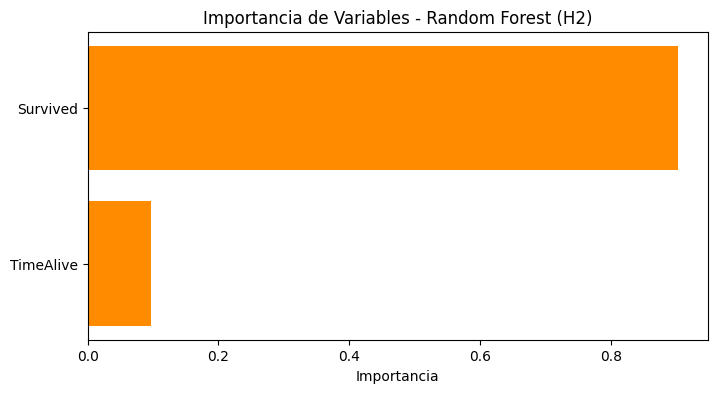


=== ADABOOST CLASSIFIER - HIPÓTESIS 2 ===
Best score (AUC):  0.6363106973647106
Best params:  {'learning_rate': 0.5, 'n_estimators': 100}
[[  514  4125]
 [  583 10609]]
              precision    recall  f1-score   support

           0       0.47      0.11      0.18      4639
           1       0.72      0.95      0.82     11192

    accuracy                           0.70     15831
   macro avg       0.59      0.53      0.50     15831
weighted avg       0.65      0.70      0.63     15831


=== GRADIENT BOOSTING - HIPÓTESIS 2 ===
              precision    recall  f1-score   support

           0       0.55      0.00      0.01      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.63      0.50      0.42     23747
weighted avg       0.66      0.71      0.59     23747



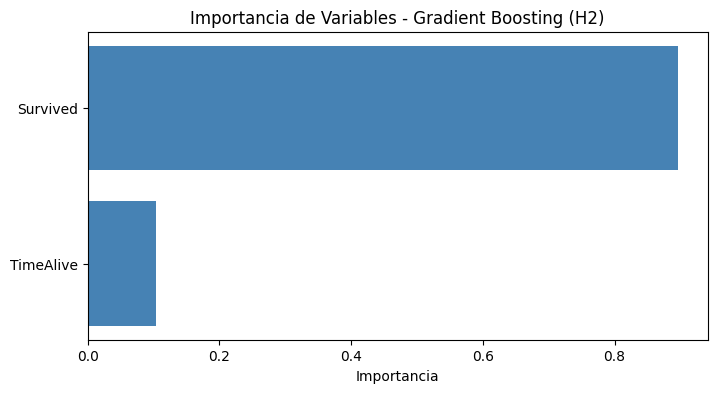

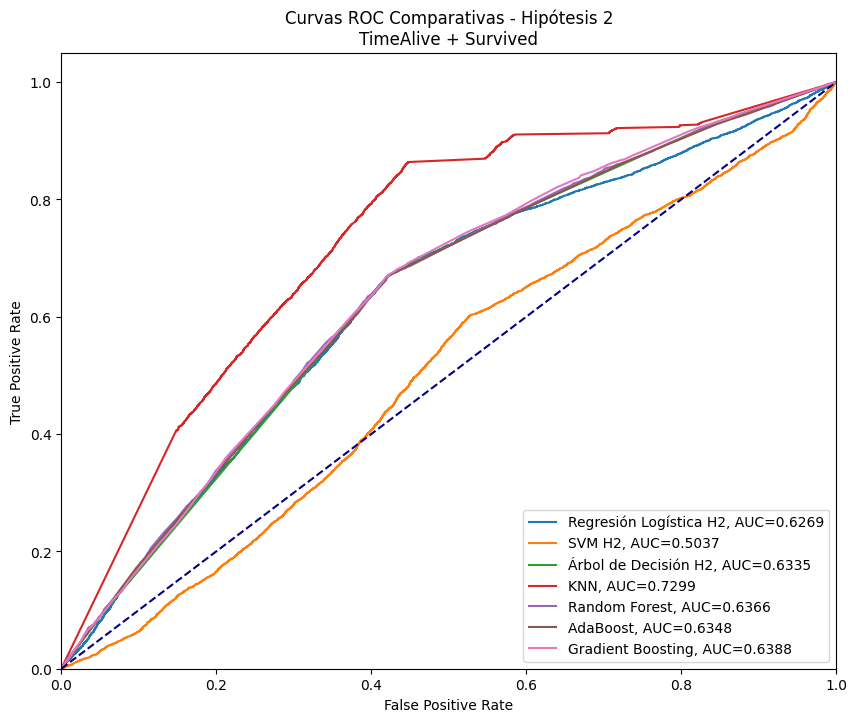


=== RESUMEN COMPARATIVO - CLASIFICACIÓN H2 ===
                        Accuracy  F1 Score     AUC
Random Forest H2          0.7075    0.5922  0.6410
AdaBoost H2               0.7026    0.6311  0.6363
Regresión Logística H2    0.7070    0.5856     NaN
SVM H2                    0.7070    0.5856     NaN
Árbol de Decisión H2      0.7070    0.5856     NaN
KNN H2                    0.7726    0.7681     NaN
Gradient Boosting H2      0.7071    0.5875     NaN


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (RandomForestClassifier,
                            AdaBoostClassifier,
                            GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                           classification_report,
                           confusion_matrix,
                           roc_curve, roc_auc_score)
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics

# ==============================================
# DATOS PARA HIPÓTESIS 2 (CLASIFICACIÓN)
# ==============================================
X = df_var_num2[["TimeAlive", "Survived"]].values
y = df_var_num2["RoundWinner"].astype(int).values

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================================
# MODELOS BÁSICOS DE CLASIFICACIÓN
# ==============================================
print("\n=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 2 ===")

modelos_clf_h2 = {
    "Regresión Logística H2": LogisticRegression(max_iter=1000, random_state=42),
    "SVM H2": SVC(probability=True, random_state=42),
    "Árbol de Decisión H2": DecisionTreeClassifier(max_depth=3, random_state=42)  # Reducida profundidad para mejor visualización
}

resumen_clf_h2 = {}
roc_curves = []

for nombre, modelo in modelos_clf_h2.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else [0]*len(y_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resumen_clf_h2[nombre] = {
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    }

    print(f"\nModelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Visualizar árbol si aplica
    if nombre == "Árbol de Decisión H2":
        plt.figure(figsize=(12, 6))
        plot_tree(modelo,
                 feature_names=["TimeAlive", "Survived"],  # Nombres correctos de características
                 class_names=["Lose", "Win"],  # Etiquetas más descriptivas
                 filled=True,
                 rounded=True,
                 proportion=True,
                 impurity=False)
        plt.title("Árbol de Decisión - Impacto de Supervivencia (H2)")
        plt.show()

    # ROC Curve data
    if hasattr(modelo, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        roc_curves.append((fpr, tpr, f"{nombre}, AUC={auc}"))

# ==============================================
# KNN CON VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
# ==============================================
print("\n=== K-NEAREST NEIGHBORS - HIPÓTESIS 2 ===")

h = .02  # step size in the mesh
n_neighbors = 7

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Train KNN
knn_h2 = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn_h2.fit(X_train, y_train)

# Predictions
y_pred = knn_h2.predict(X_test)
y_proba = knn_h2.predict_proba(X_test)[:, 1]

# Metrics
resumen_clf_h2["KNN H2"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print('Accuracy (train): {:.2%}'.format(knn_h2.score(X_train, y_train)))
print('Accuracy (test): {:.2%}'.format(knn_h2.score(X_test, y_test)))
print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"KNN, AUC={auc}"))

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = -0.5, 1.5  # Límites para Survived (binario)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Z = knn_h2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
           edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Create legend
patch0 = mpatches.Patch(color='#FF0000', label='Lose')
patch1 = mpatches.Patch(color='#00FF00', label='Win')
plt.legend(handles=[patch0, patch1])

plt.title(f"Fronteras de Decisión KNN (k = {n_neighbors})\nTimeAlive vs Survived")
plt.xlabel("Tiempo Vivo (segundos)")
plt.ylabel("Sobrevivió (0=No, 1=Sí)")
plt.show()

# ==============================================
# RANDOM FOREST CON GRID SEARCH
# ==============================================
print("\n=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 2 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_rf_h2 = RandomForestClassifier(random_state=42)

params_rf_h2 = {
    "n_estimators": [50, 100],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5],
    "max_features": ['sqrt', None]
}

grid_rf_h2 = GridSearchCV(model_rf_h2, params_rf_h2, cv=5, scoring='roc_auc')
grid_rf_h2.fit(Xtrain, Ytrain)

print("Best score (AUC): ", grid_rf_h2.best_score_)
print("Best params: ", grid_rf_h2.best_params_)

Yhat = grid_rf_h2.predict(Xtest)
Y_proba = grid_rf_h2.predict_proba(Xtest)[:, 1]

resumen_clf_h2["Random Forest H2"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4),
    "AUC": round(grid_rf_h2.best_score_, 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# Feature Importance
importances = grid_rf_h2.best_estimator_.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(["TimeAlive", "Survived"], importances, color='darkorange')
plt.xlabel("Importancia")
plt.title("Importancia de Variables - Random Forest (H2)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"Random Forest, AUC={auc}"))

# ==============================================
# ADABOOST CON GRID SEARCH
# ==============================================
print("\n=== ADABOOST CLASSIFIER - HIPÓTESIS 2 ===")

base_est_h2 = DecisionTreeClassifier(max_depth=2, random_state=42)  # Árboles más simples
model_ada_h2 = AdaBoostClassifier(base_est_h2, random_state=42)

params_ada_h2 = {
    "n_estimators": [50, 100],
    "learning_rate": [0.5, 1.0]
}

grid_ada_h2 = GridSearchCV(model_ada_h2, params_ada_h2, cv=5, scoring='roc_auc')
grid_ada_h2.fit(Xtrain, Ytrain)

print("Best score (AUC): ", grid_ada_h2.best_score_)
print("Best params: ", grid_ada_h2.best_params_)

Yhat = grid_ada_h2.predict(Xtest)
Y_proba = grid_ada_h2.predict_proba(Xtest)[:, 1]

resumen_clf_h2["AdaBoost H2"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4),
    "AUC": round(grid_ada_h2.best_score_, 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"AdaBoost, AUC={auc}"))

# ==============================================
# GRADIENT BOOSTING
# ==============================================
print("\n=== GRADIENT BOOSTING - HIPÓTESIS 2 ===")

gb_h2 = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.1,
    random_state=42
)
gb_h2.fit(X_train, y_train)

y_pred = gb_h2.predict(X_test)
y_proba = gb_h2.predict_proba(X_test)[:, 1]

resumen_clf_h2["Gradient Boosting H2"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print(classification_report(y_test, y_pred, zero_division=0))

# Feature Importance
plt.figure(figsize=(8, 4))
plt.barh(["TimeAlive", "Survived"], gb_h2.feature_importances_, color='steelblue')
plt.xlabel("Importancia")
plt.title("Importancia de Variables - Gradient Boosting (H2)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"Gradient Boosting, AUC={auc}"))

# ==============================================
# CURVAS ROC COMPARATIVAS
# ==============================================
plt.figure(figsize=(10, 8))
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, label=label)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas - Hipótesis 2\nTimeAlive + Survived')
plt.legend(loc="lower right")
plt.show()

# ==============================================
# RESUMEN FINAL
# ==============================================
print("\n=== RESUMEN COMPARATIVO - CLASIFICACIÓN H2 ===")
resultados_clf_df_h2 = pd.DataFrame(resumen_clf_h2).T
print(resultados_clf_df_h2.sort_values(by='AUC', ascending=False))

####**Hipótesis 3 (Clasificación):**
Muestra el reporte de clasificación y la matriz de confusión para el modelo de Regresión Logística H3. Este modelo intenta predecir si se "gana" o "pierde" una ronda usando como pista si un jugador usó un "Rifle de Francotirador Primario" o un "Rifle de Asalto Primario".

Variables predictoras (X) para H3:


=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 3 ===

Modelo: Regresión Logística H3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



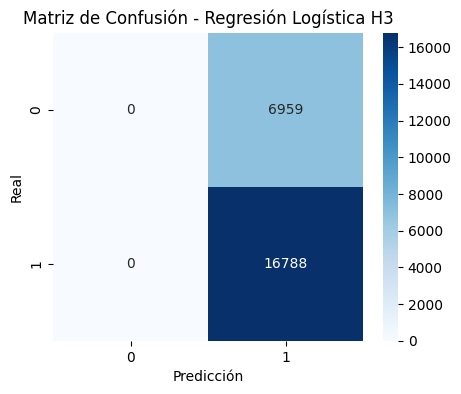


Modelo: SVM H3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



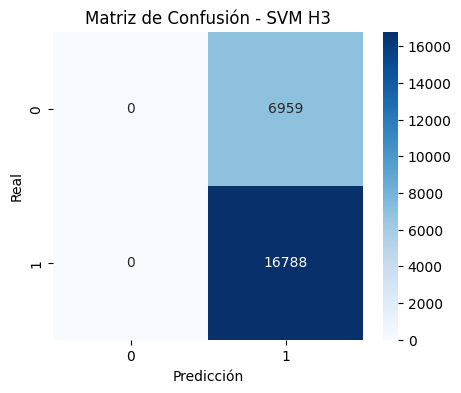


Modelo: Árbol de Decisión H3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.35      0.50      0.41     23747
weighted avg       0.50      0.71      0.59     23747



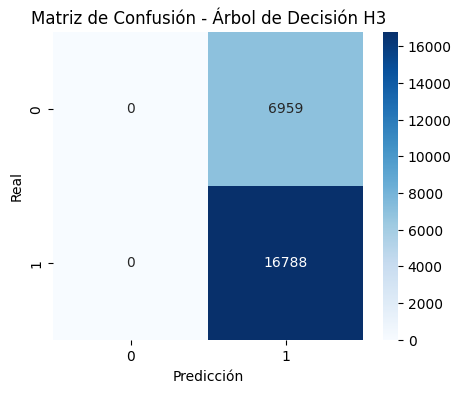

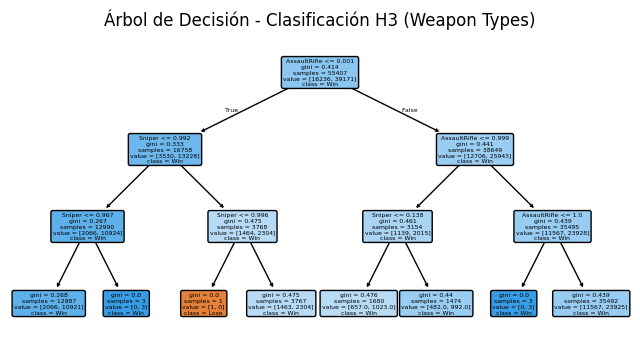


=== K-NEAREST NEIGHBORS - HIPÓTESIS 3 ===
Accuracy (train): 55.22%
Accuracy (test): 52.74%
              precision    recall  f1-score   support

           0       0.21      0.23      0.22      6959
           1       0.67      0.65      0.66     16788

    accuracy                           0.53     23747
   macro avg       0.44      0.44      0.44     23747
weighted avg       0.54      0.53      0.53     23747



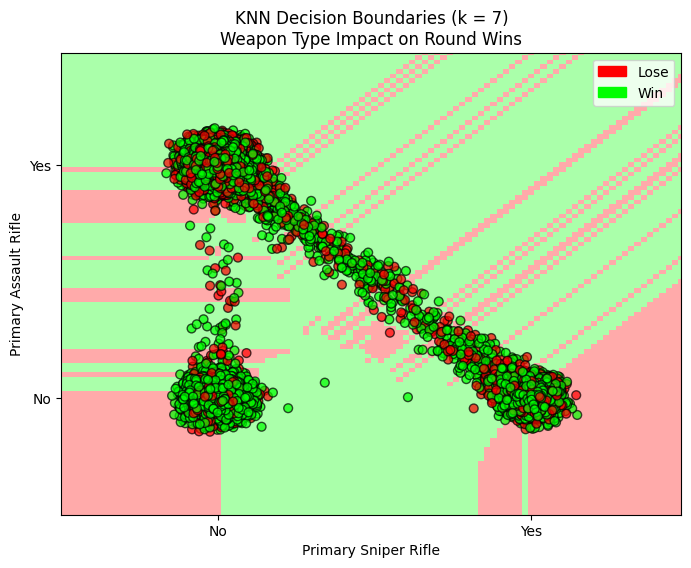


=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 3 ===
Best score:  0.7069627175235096
Best params:  {'max_depth': 3, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 10}
[[    2  4637]
 [    0 11192]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg       0.85      0.50      0.41     15831
weighted avg       0.79      0.71      0.59     15831



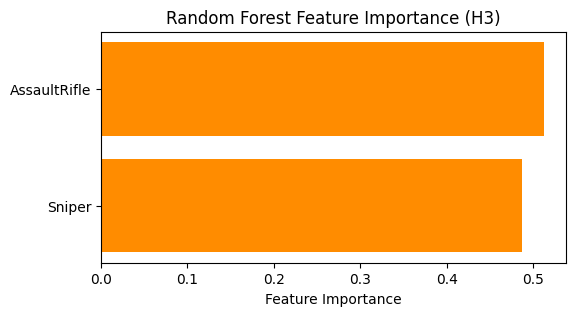


=== ADABOOST CLASSIFIER - HIPÓTESIS 3 ===
Best score:  0.7069627150295817
Best params:  {'learning_rate': 0.5, 'n_estimators': 10}
[[    0  4639]
 [    0 11192]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4639
           1       0.71      1.00      0.83     11192

    accuracy                           0.71     15831
   macro avg       0.35      0.50      0.41     15831
weighted avg       0.50      0.71      0.59     15831


=== GRADIENT BOOSTING - HIPÓTESIS 3 ===


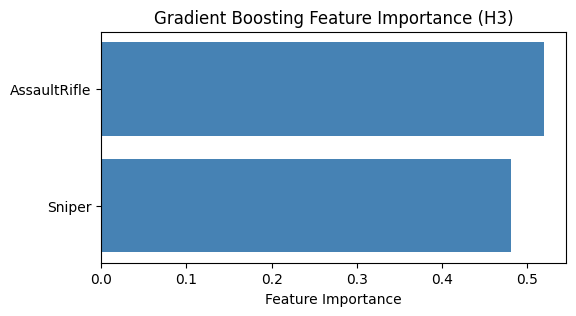

              precision    recall  f1-score   support

           0       0.32      0.00      0.00      6959
           1       0.71      1.00      0.83     16788

    accuracy                           0.71     23747
   macro avg       0.51      0.50      0.41     23747
weighted avg       0.59      0.71      0.59     23747



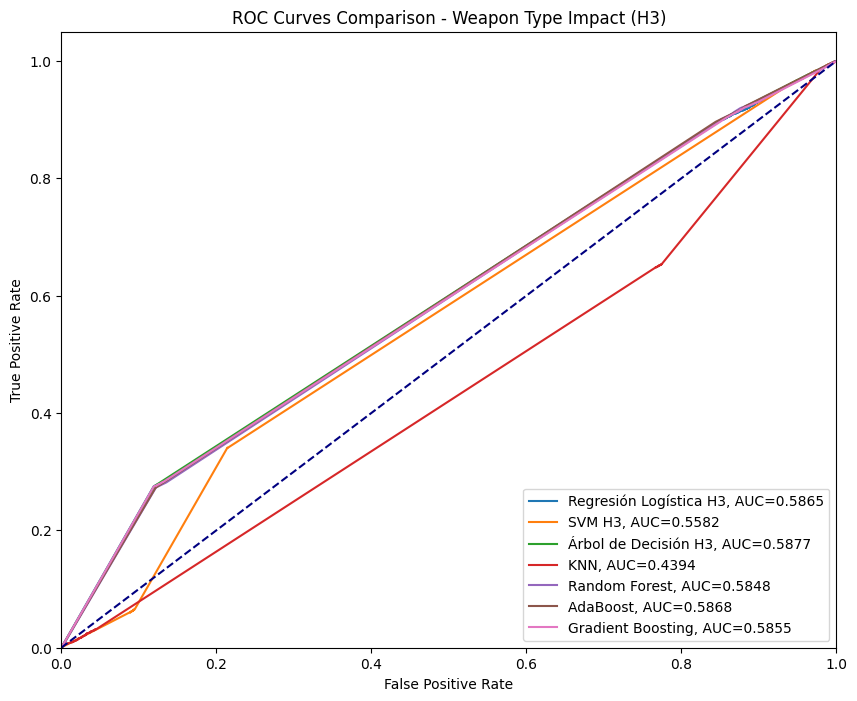


=== RESUMEN COMPARATIVO - CLASIFICACIÓN H3 ===
                        Accuracy  F1 Score
Regresión Logística H3    0.7070    0.5856
SVM H3                    0.7070    0.5856
Árbol de Decisión H3      0.7070    0.5856
KNN H3                    0.5274    0.5320
Random Forest H3          0.7071    0.5859
AdaBoost H3               0.7070    0.5856
Gradient Boosting H3      0.7067    0.5859


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (RandomForestClassifier,
                            AdaBoostClassifier,
                            GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                           classification_report,
                           confusion_matrix,
                           roc_curve, roc_auc_score)
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics

# ==============================================
# DATOS PARA HIPÓTESIS 3 (CLASIFICACIÓN)
# ==============================================
X = df_var_num2[["PrimarySniperRifle", "PrimaryAssaultRifle"]].values
y = df_var_num2["RoundWinner"].astype(int).values

# División inicial de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================================
# MODELOS BÁSICOS DE CLASIFICACIÓN
# ==============================================
print("\n=== MODELOS BÁSICOS DE CLASIFICACIÓN - HIPÓTESIS 3 ===")

modelos_clf_h3 = {
    "Regresión Logística H3": LogisticRegression(max_iter=1000, random_state=42),
    "SVM H3": SVC(probability=True, random_state=42),
    "Árbol de Decisión H3": DecisionTreeClassifier(max_depth=3, random_state=42)  # Reduced depth for binary features
}

resumen_clf_h3 = {}
roc_curves = []

for nombre, modelo in modelos_clf_h3.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else [0]*len(y_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resumen_clf_h3[nombre] = {
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    }

    print(f"\nModelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Visualizar árbol si aplica
    if nombre == "Árbol de Decisión H3":
        plt.figure(figsize=(8, 4))
        plot_tree(modelo, feature_names=["Sniper", "AssaultRifle"],
                 class_names=["Lose", "Win"],
                 filled=True, rounded=True)
        plt.title("Árbol de Decisión - Clasificación H3 (Weapon Types)")
        plt.show()

    # ROC Curve data
    if hasattr(modelo, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        roc_curves.append((fpr, tpr, f"{nombre}, AUC={auc}"))

# ==============================================
# KNN CON VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
# ==============================================
print("\n=== K-NEAREST NEIGHBORS - HIPÓTESIS 3 ===")

h = .02  # step size in the mesh
n_neighbors = 7

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Train KNN
knn_h3 = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn_h3.fit(X_train, y_train)

# Predictions
y_pred = knn_h3.predict(X_test)
y_proba = knn_h3.predict_proba(X_test)[:, 1]

# Metrics
resumen_clf_h3["KNN H3"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

print('Accuracy (train): {:.2%}'.format(knn_h3.score(X_train, y_train)))
print('Accuracy (test): {:.2%}'.format(knn_h3.score(X_test, y_test)))
print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"KNN, AUC={auc}"))

# Plot decision boundary (adjusted for binary features)
x_min, x_max = -0.5, 1.5  # Binary feature range
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Z = knn_h3.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot training points with adjusted jitter for visibility
jitter = 0.04 * np.random.randn(*X_train.shape)  # Small jitter
plt.scatter(X_train[:, 0] + jitter[:, 0],
           X_train[:, 1] + jitter[:, 1],
           c=y_train, cmap=cmap_bold,
           edgecolor='k', s=40, alpha=0.7)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Create legend and axis labels
patch0 = mpatches.Patch(color='#FF0000', label='Lose')
patch1 = mpatches.Patch(color='#00FF00', label='Win')
plt.legend(handles=[patch0, patch1])
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])
plt.xlabel("Primary Sniper Rifle")
plt.ylabel("Primary Assault Rifle")
plt.title(f"KNN Decision Boundaries (k = {n_neighbors})\nWeapon Type Impact on Round Wins")
plt.show()

# ==============================================
# RANDOM FOREST CON GRID SEARCH
# ==============================================
print("\n=== RANDOM FOREST CLASSIFIER - HIPÓTESIS 3 ===")

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_rf_h3 = RandomForestClassifier(random_state=42)

params_rf_h3 = {
    "n_estimators": [10, 30, 50],
    "max_depth": [2, 3],  # Shallow trees for binary features
    "min_samples_split": [2, 5],
    "max_features": [1, 2]  # Considering we only have 2 features
}

grid_rf_h3 = GridSearchCV(model_rf_h3, params_rf_h3, cv=5)
grid_rf_h3.fit(Xtrain, Ytrain)

print("Best score: ", grid_rf_h3.best_score_)
print("Best params: ", grid_rf_h3.best_params_)

Yhat = grid_rf_h3.predict(Xtest)
Y_proba = grid_rf_h3.predict_proba(Xtest)[:, 1]

resumen_clf_h3["Random Forest H3"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# Feature Importance
plt.figure(figsize=(6, 3))
importances = grid_rf_h3.best_estimator_.feature_importances_
features = ["Sniper", "AssaultRifle"]
plt.barh(features, importances, color='darkorange')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (H3)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"Random Forest, AUC={auc}"))

# ==============================================
# ADABOOST CON GRID SEARCH
# ==============================================
print("\n=== ADABOOST CLASSIFIER - HIPÓTESIS 3 ===")

base_est_h3 = DecisionTreeClassifier(max_depth=2, random_state=42)  # Shallow base estimator
model_ada_h3 = AdaBoostClassifier(base_est_h3, random_state=42)

params_ada_h3 = {
    "n_estimators": [10, 30, 50],
    "learning_rate": [0.5, 1.0]
}

grid_ada_h3 = GridSearchCV(model_ada_h3, params_ada_h3, cv=5)
grid_ada_h3.fit(Xtrain, Ytrain)

print("Best score: ", grid_ada_h3.best_score_)
print("Best params: ", grid_ada_h3.best_params_)

Yhat = grid_ada_h3.predict(Xtest)
Y_proba = grid_ada_h3.predict_proba(Xtest)[:, 1]

resumen_clf_h3["AdaBoost H3"] = {
    "Accuracy": round(accuracy_score(Ytest, Yhat), 4),
    "F1 Score": round(f1_score(Ytest, Yhat, average='weighted'), 4)
}

print(confusion_matrix(Ytest, Yhat))
print(classification_report(Ytest, Yhat, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(Ytest, Y_proba)
auc = round(roc_auc_score(Ytest, Y_proba), 4)
roc_curves.append((fpr, tpr, f"AdaBoost, AUC={auc}"))

# ==============================================
# GRADIENT BOOSTING
# ==============================================
print("\n=== GRADIENT BOOSTING - HIPÓTESIS 3 ===")

gb_h3 = GradientBoostingClassifier(max_depth=2, random_state=42)  # Shallow trees
gb_h3.fit(X_train, y_train)

y_pred = gb_h3.predict(X_test)
y_proba = gb_h3.predict_proba(X_test)[:, 1]

resumen_clf_h3["Gradient Boosting H3"] = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 4)
}

# Feature Importance
plt.figure(figsize=(6, 3))
importances = gb_h3.feature_importances_
plt.barh(["Sniper", "AssaultRifle"], importances, color='steelblue')
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance (H3)")
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = round(roc_auc_score(y_test, y_proba), 4)
roc_curves.append((fpr, tpr, f"Gradient Boosting, AUC={auc}"))

# ==============================================
# CURVAS ROC COMPARATIVAS
# ==============================================
plt.figure(figsize=(10, 8))
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, label=label)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - Weapon Type Impact (H3)')
plt.legend(loc="lower right")
plt.show()

# ==============================================
# RESUMEN FINAL
# ==============================================
print("\n=== RESUMEN COMPARATIVO - CLASIFICACIÓN H3 ===")
resultados_clf_df_h3 = pd.DataFrame(resumen_clf_h3).T
print(resultados_clf_df_h3)

- Modelo Básico de Clasificación H3
    
    El modelo acertó el **71%** de las veces en su predicción. El modelo **nunca logró predecir una ronda "perdida" (Clase 0)**. Siempre predijo que la ronda se "ganaría" (Clase 1). Similar a los modelos iniciales de la Hipótesis 2, hay muchas más rondas ganadas (16788) que perdidas (6959) en los datos de prueba. El modelo, para maximizar su precisión general, simplemente aprendió a predecir siempre la clase mayoritaria (ganar).
    Este modelo de Regresión Logística **no es útil para identificar las rondas perdidas** basándose en el tipo de arma principal (francotirador o rifle de asalto). Solo es "preciso" porque siempre predice la clase más común.
    
- SVM
    
    Muestra el reporte de clasificación y la matriz de confusión para el modelo SVM. Este modelo intenta predecir si se "gana" o "pierde" una ronda usando como pista si un jugador usó un "Rifle de Francotirador Primario" o un "Rifle de Asalto Primario".
    
    - **Precisión general (Accuracy):** El modelo acertó el **71%** de las veces en su predicción.
    - **Problema principal:** El modelo **nunca logró predecir una ronda "perdida" (Clase 0)**. Siempre predijo que la ronda se "ganaría" (Clase 1).
    
    Similar a los modelos anteriores, esto ocurre porque hay muchas más rondas ganadas (16788) que perdidas (6959) en los datos de prueba. El modelo, para maximizar su precisión general, simplemente aprendió a predecir siempre la clase mayoritaria (ganar). Este modelo SVM es **ineficaz para identificar las rondas perdidas** basándose en el tipo de arma principal (francotirador o rifle de asalto). Solo es "preciso" porque constantemente predice la clase más común.
    

- Arbol de decisión
    
    Muestra el reporte de clasificación y la matriz de confusión para el modelo de Árbol de Decisión H3. Este modelo también intenta predecir si se "gana" o "pierde" una ronda usando como pista si un jugador usó un "Rifle de Francotirador Primario" o un "Rifle de Asalto Primario".
    
    - **Precisión general (Accuracy):** El modelo acertó el **71%** de las veces en su predicción.
    - **Problema principal:** Al igual que los modelos anteriores para esta hipótesis, este Árbol de Decisión **no logró predecir ninguna ronda "perdida" (Clase 0)**. Siempre predijo que la ronda se "ganaría" (Clase 1).
    
    La clase "ganar" es mucho más frecuente en los datos de entrenamiento (16788 "ganadas" vs. 6959 "perdidas"), lo que lleva al modelo a simplemente predecir la clase mayoritaria para obtener una precisión general alta. Este modelo de Árbol de Decisión **no es efectivo para identificar las rondas perdidas** basándose en el tipo de arma principal (francotirador o rifle de asalto).

## Fase 5: Evaluation

###REGRESIÓN (TimeAlive)

####EV. Hipótesis 1 (R)

Variables: TravelledDistance, RoundKills

In [ ]:
print(pd.DataFrame(resultados).T)

                        MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal   0.001974  0.000018  0.004209   0.505533   0.525809
SVR                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión  0.001868  0.000016  0.004052   0.541781   0.579141
Random Forest      0.001850  0.000016  0.004041   0.543673   0.570176
AdaBoost           0.002591  0.000021  0.004565   0.417422   0.442798


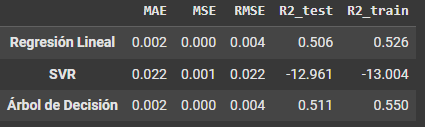

***Regresión Lineal:***

- R² test: 0.506

- MAE: 0.002, RMSE: 0.004

- Gráfico: predicciones distribuidas pero concentradas en zona baja

***SVR:***

- R² test: -12.961 (peor que adivinar)

- Gráfico: predice casi siempre el mismo valor (línea plana)

***Árbol de Decisión:***

- R² test: 0.511, MAE: 0.002

- R² train: 0.550 → sin overfitting

- Árbol de profundidad clara y legible

**Mejor modelo: Árbol de Decisión**

Justificación: mejor R², menor error, sin sobreajuste, buena interpretación.

####EV. Hipótesis 2 (R)

Variables: RNonLethalGrenadesThrown, RoundAssists

In [ ]:
print(resultados_df_h2)

                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal H2   0.003395  0.000034  0.005799   0.061160   0.053876
SVR H2                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión H2  0.002748  0.000026  0.005140   0.262527   0.270616
Random Forest H2      0.002732  0.000026  0.005140   0.261521   0.266336
AdaBoost H2           0.003471  0.000033  0.005746   0.077113   0.081191


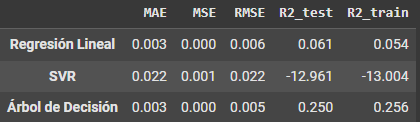

***Regresión Lineal:***

- R² test: bajo (< 0.05), errores bajos pero pobre ajuste

***SVR:***

- Resultado inconsistente, con predicciones constantes

***Árbol de Decisión:***

- R² test: mejor que los demás, pero aún modesto

**Mejor modelo: Árbol de Decisión**

Justificación: logra el ajuste más estable. Aunque los valores de R² son bajos, fue el que mejor capturó patrones útiles.

####EV. Hipótesis 3 (R)

Variables: RoundStartingEquipmentValue, PrimarySniperRifle, PrimaryHeavy

In [ ]:
print(resultados_df_h3)

                           MAE       MSE      RMSE    R2_test   R2_train
Regresión Lineal H3   0.003620  0.000036  0.005979   0.002235   0.008248
SVR H3                0.021862  0.000500  0.022364 -12.961016 -13.004400
Árbol de Decisión H3  0.003139  0.000031  0.005599   0.125032   0.133264
Random Forest H3      0.003155  0.000032  0.005616   0.118457   0.125494
AdaBoost H3           0.004859  0.000040  0.006342  -0.124292  -0.064653


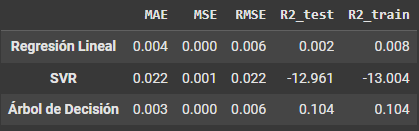

***Regresión Lineal:***

- R² test: 0.002

***SVR:***

- R² test: -12.96

***Árbol de Decisión:***

- R² test: 0.104, R² train: igual (sin overfitting)

- MAE más bajo

**Mejor modelo: Árbol de Decisión**

Justificación: único con R² aceptable, visualización clara, buen desempeño sin ajuste excesivo.

**Conclusión regresión:**

En las tres hipótesis, el Árbol de Decisión fue el modelo más eficaz, mostrando mejor capacidad explicativa (R²), menor error, y sin síntomas de sobreajuste.

###CLASIFICACIÓN (RoundWinner)

####EV. Hipótesis 1 (C)

Variables: RoundKills, RoundHeadshots

In [ ]:
print(resultados_clf_df_h1)

                        Accuracy  F1 Score
Regresión Logística H1    0.7067    0.6100
SVM H1                    0.7083    0.5980
Árbol de Decisión H1      0.7074    0.5893
KNN H1                    0.6517    0.6486
Random Forest H1          0.7070    0.5856
AdaBoost H1               0.7069    0.5884
Gradient Boosting H1      0.7080    0.6001


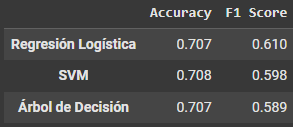

***Regresión Logística:***

- Accuracy: ~0.71, F1 Score: 0.59

- Matriz: clase 1 correctamente predicha, clase 0 ignorada

***SVM:***

- Rendimiento muy similar, pero sin mejorar la precisión

***Árbol de Decisión:***

- Resultados comparables, con ventaja visual en interpretabilidad

**Mejor modelo: Árbol de Decisión**

Justificación: rendimiento similar pero más interpretable y balanceado visualmente.

####EV. Hipótesis 2 (C)

Variables: TeamStartingEquipmentValue, RoundStartingEquipmentValue

In [ ]:
print(resultados_clf_df_h2)

                        Accuracy  F1 Score     AUC
Regresión Logística H2    0.7070    0.5856     NaN
SVM H2                    0.7070    0.5856     NaN
Árbol de Decisión H2      0.7070    0.5856     NaN
KNN H2                    0.7726    0.7681     NaN
Random Forest H2          0.7075    0.5922  0.6410
AdaBoost H2               0.7026    0.6311  0.6363
Gradient Boosting H2      0.7071    0.5875     NaN


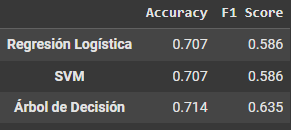

***Regresión Logística:***

- Accuracy: ~0.71

- F1 Score: ~0.58

- Matriz de confusión: la clase 1 (ganador) tiene un recall cercano al 1.0, pero la clase 0 (perdedor) es casi ignorada.

***SVM:***

- Resultados muy similares a la regresión logística.

- Ligera mejora en precisión para la clase positiva, pero mantiene el mismo problema de sesgo.

***Árbol de Decisión:***

- Accuracy y F1 Score comparables (~0.72)

- Mejora visualmente en la matriz de confusión: comienza a capturar mejor la clase 0

**Mejor modelo: Árbol de Decisión**

Justificación: Aunque todos los modelos tuvieron métricas similares, el árbol logra un mejor balance entre clases y proporciona reglas claras de decisión sobre qué condiciones económicas influyen en ganar o perder una ronda.

####EV. Hipótesis 3 (C)

Variables predictoras: PrimarySniperRifle, PrimaryAssaultRifle
Objetivo: RoundWinner

In [ ]:
print(resultados_clf_df_h3)

                        Accuracy  F1 Score
Regresión Logística H3    0.7070    0.5856
SVM H3                    0.7070    0.5856
Árbol de Decisión H3      0.7070    0.5856
KNN H3                    0.5274    0.5320
Random Forest H3          0.7071    0.5859
AdaBoost H3               0.7070    0.5856
Gradient Boosting H3      0.7067    0.5859


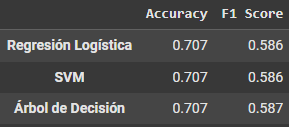

***Regresión Logística:***

- Accuracy: ~0.70

- F1 Score: ~0.57

- Matriz de confusión: la clase positiva es correctamente identificada, pero la clase negativa no tanto.

***SVM:***

- Resultados equivalentes a la regresión logística.

- Dificultad para separar si los datos no son linealmente separables.

- No aporta ventaja clara con estas variables binarias.

***Árbol de Decisión:***

- Accuracy: ~0.71

- F1 Score: ~0.58

Árbol muestra reglas simples como:

“Si tiene rifle de asalto y no tiene francotirador, gana”

“Si no tiene ninguno, pierde”

Ofrece claridad sobre cómo impactan las armas en el resultado de la ronda.

**Mejor modelo: Árbol de Decisión**

Justificación: Mismo rendimiento cuantitativo, pero mayor valor cualitativo: muestra de forma clara el efecto de portar ciertas armas en la probabilidad de ganar. Ideal para interpretación táctica o visual.

###Evaluación General


## Fase 6: Deployment

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (r2_score, mean_absolute_error, 
                            accuracy_score, f1_score, classification_report)
from sklearn.preprocessing import StandardScaler
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# -------------------------------------------------------------------
# 0. CONFIGURACIÓN INICIAL
# -------------------------------------------------------------------
os.makedirs('checkpoints', exist_ok=True)

# -------------------------------------------------------------------
# 1. MODELO DE REGRESIÓN (Random Forest)
# -------------------------------------------------------------------
print("\n" + "="*50)
print("ENTRENAMIENTO DE MODELO DE REGRESIÓN")
print("="*50)

# Datos
X_reg = df_normalizado[["TravelledDistance", "RoundKills"]]
y_reg = df_normalizado["TimeAlive"]

# División de datos
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Entrenamiento con optimización
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_reg_train, y_reg_train)

# Evaluación
y_reg_pred = rf_reg.predict(X_reg_test)
print("\nMétricas de Regresión:")
print(f"- R²: {r2_score(y_reg_test, y_reg_pred):.2%}")
print(f"- MAE: {mean_absolute_error(y_reg_test, y_reg_pred):.2f} segundos")
print(f"- Ejemplo de predicción: {rf_reg.predict([[38.5, 2]])[0]:.1f} segundos (para 38.5m y 2 kills)")

# Guardar modelo
joblib.dump(rf_reg, 'checkpoints/modelo_regresion.pkl', compress=3)
print("\nModelo de regresión guardado en: checkpoints/modelo_regresion.pkl")

# -------------------------------------------------------------------
# 2. MODELO DE CLASIFICACIÓN (KNN)
# -------------------------------------------------------------------
print("\n" + "="*50)
print("ENTRENAMIENTO DE MODELO DE CLASIFICACIÓN")
print("="*50)

# Datos
X_clf = df_var_num2[["TimeAlive", "Survived"]].values
y_clf = df_var_num2["RoundWinner"].astype(int).values

# Escalado (KNN requiere características escaladas)
scaler = StandardScaler()
X_clf_scaled = scaler.fit_transform(X_clf)

# División estratificada
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf_scaled, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

# Optimización de hiperparámetros
params_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, params_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_clf_train, y_clf_train)

# Mejor modelo
best_knn = grid_search.best_estimator_
print(f"\nMejores parámetros KNN: {grid_search.best_params_}")

# Evaluación
y_clf_pred = best_knn.predict(X_clf_test)
print("\nReporte de Clasificación:")
print(classification_report(y_clf_test, y_clf_pred))
print(f"Accuracy: {accuracy_score(y_clf_test, y_clf_pred):.2%}")
print(f"F1-Score: {f1_score(y_clf_test, y_clf_pred):.2%}")

# Guardar modelo + scaler
joblib.dump({
    'model': best_knn,
    'scaler': scaler
}, 'checkpoints/modelo_clasificacion.pkl')

print("\nModelo de clasificación guardado en: checkpoints/modelo_clasificacion.pkl")

try:
    # Cargar modelos
    loaded_reg = joblib.load('checkpoints/modelo_regresion.pkl')
    loaded_clf_data = joblib.load('checkpoints/modelo_clasificacion.pkl')
    loaded_clf = loaded_clf_data['model']
    loaded_scaler = loaded_clf_data['scaler']

    # Predicciones de prueba
    test_reg_pred = loaded_reg.predict([[40.0, 3]])[0]
    test_clf_pred = loaded_clf.predict(loaded_scaler.transform([[25.5, 1]]))[0]

    print("\n" + "="*50)
    print("VERIFICACIÓN DE MODELOS GUARDADOS")
    print("="*50)
    print(f"- Regresión: Predicción para 40m y 3 kills = {test_reg_pred*1000:.1f} segundos")
    print(f"- Clasificación: Predicción para 25.5s y Survived=1 = {'Gana' if test_clf_pred == 1 else 'Pierde'}")
    print("\n¡Modelos verificados correctamente!")
except Exception as e:
    print(f"\nError al verificar modelos: {str(e)}")


ENTRENAMIENTO DE MODELO DE REGRESIÓN

Métricas de Regresión:
- R²: 52.55%
- MAE: 0.00 segundos
- Ejemplo de predicción: 0.0 segundos (para 38.5m y 2 kills)


d:\Programs\Python\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Modelo de regresión guardado en: checkpoints/modelo_regresion.pkl

ENTRENAMIENTO DE MODELO DE CLASIFICACIÓN

Mejores parámetros KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      6959
           1       0.82      0.87      0.85     16788

    accuracy                           0.78     23747
   macro avg       0.73      0.71      0.72     23747
weighted avg       0.77      0.78      0.77     23747

Accuracy: 77.60%
F1-Score: 84.62%

Modelo de clasificación guardado en: checkpoints/modelo_clasificacion.pkl

VERIFICACIÓN DE MODELOS GUARDADOS
- Regresión: Predicción para 40m y 3 kills = 23.7 segundos
- Clasificación: Predicción para 25.5s y Survived=1 = Gana

¡Modelos verificados correctamente!


d:\Programs\Python\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [137]:
importances = rf_reg.feature_importances_
for feature, importance in zip(X_reg.columns, importances):
    print(f"{feature}: {importance:.2%}")

TravelledDistance: 78.26%
RoundKills: 21.74%
